<h1><div class="alert alert-block alert-info">
    Strategy to Customer Retetion through Churn Analysis
</div></h1>

## Objective

<hr>

Explore the main service(s) the TelCo should focus on to define its strategy for customer retention improvement.

## Description of the Data

<hr>

The raw data contains 7043 rows (customers) and 21 columns (features). The data is right-censored, considering tenure as the time in months and churn represents the status at the end of the study.

The metadata can be divided into the following groups:

- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents
- Censoring - customers who left within the last month – the event is stored in the column called Churn and the time to it is on column tenure. 

Source: https://www.kaggle.com/blastchar/telco-customer-churn

In [3]:
options( warn = 2 )
options(repr.plot.width=16, repr.plot.height=10)

In [4]:
library(dplyr) 
library(survival)
library(ggplot2) 
library(survminer)
library(corrplot)
library(RColorBrewer)
library(LTRCtrees) # or survival tree
library(fmsb) # for radar plot
library(scales)
library(rpivotTable)  # for displaying the data
library(rpart.plot)
library(survRM2)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: ggpubr

Loading required package: magrittr

corrplot 0.84 loaded

Loading required package: rpart



## Loading and Cleaning the Data

<hr>

In [5]:
churn = read.csv('WA_Fn-UseC_-Telco-Customer-Churn.csv',header = TRUE, sep = ',')

In [6]:
glimpse(churn)

Observations: 7,043
Variables: 21
$ customerID       <fct> 7590-VHVEG, 5575-GNVDE, 3668-QPYBK, 7795-CFOCW, 92...
$ gender           <fct> Female, Male, Male, Male, Female, Female, Male, Fe...
$ SeniorCitizen    <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
$ Partner          <fct> Yes, No, No, No, No, No, No, No, Yes, No, Yes, No,...
$ Dependents       <fct> No, No, No, No, No, No, Yes, No, No, Yes, Yes, No,...
$ tenure           <int> 1, 34, 2, 45, 2, 8, 22, 10, 28, 62, 13, 16, 58, 49...
$ PhoneService     <fct> No, Yes, Yes, No, Yes, Yes, Yes, No, Yes, Yes, Yes...
$ MultipleLines    <fct> No phone service, No, No, No phone service, No, Ye...
$ InternetService  <fct> DSL, DSL, DSL, DSL, Fiber optic, Fiber optic, Fibe...
$ OnlineSecurity   <fct> No, Yes, Yes, Yes, No, No, No, Yes, No, Yes, Yes, ...
$ OnlineBackup     <fct> Yes, No, Yes, No, No, No, Yes, No, No, Yes, No, No...
$ DeviceProtection <fct> No, Yes, No, Yes, No, Yes, No, No, Yes, No, No, No...
$ TechSupport     

### Description of the variables

- <i>Customer ID:</i> Customer ID
- <i>Gender:</i> Whether the customer is a male or a female
- <i>Senior Citizen:</i> Whether the customer is a senior citizen or not (1, 0)
- <i>Partner:</i> Whether the customer has a partner or not (Yes, No)
- <i>Dependents:</i> Whether the customer has dependents or not (Yes, No)
- <i>Tenure:</i> Number of months the customer has stayed with the company
- <i>Phone Service:</i> Whether the customer has a phone service or not (Yes, No)
- <i>Multiple Lines:</i> Whether the customer has multiple lines or not (Yes, No, No phone service)
- <i>Internet Service Customer’s:</i> internet service provider (DSL, Fiber optic, No)
- <i>Online Security:</i> Whether the customer has online security or not (Yes, No, No internet service)
- <i>Online Backup:</i> Whether the customer has online backup or not (Yes, No, No internet service)
- <i>Device Protection:</i> Whether the customer has device protection or not (Yes, No, No internet service)
- <i>Tech Support:</i> Whether the customer has tech support or not (Yes, No, No internet service)
- <i>Streaming TV:</i> Whether the customer has streaming TV or not (Yes, No, No internet service)
- <i>Streaming Movies:</i> Whether the customer has streaming movies or not (Yes, No, No internet service)
- <i>Contract:</i> The contract term of the customer (Month-to-month, One year, Two year)
- <i>Paperless Billing:</i> Whether the customer has paperless billing or not (Yes, No)
- <i>Payment Method:</i> The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
- <i>Monthly Charges:</i> The amount charged to the customer monthly
- <i>Total Charges:</i> The total amount charged to the customer
- <i>Churn:</i> Whether the customer churned or not (Yes or No)

In [7]:
head(churn)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
,<fct>,<fct>,<int>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,...,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>
1,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
2,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
3,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
4,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
5,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
6,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes


### Dealing with NAs

We have only 11 rows with NA values, that are in the column 'TotalCharges'. As we can see the 'TotalCharges' is closely dependent on Monthly Charges, so we are going to use just Monthly Charges in our study.

In [8]:
sum(is.na(churn))

[1] 11

In [9]:
df_sub = subset(churn, is.na(churn$TotalCharges) == FALSE)
df_sub$calculated_total = df_sub$MonthlyCharges*df_sub$tenure

sum_of_total = sum(df_sub$TotalCharges)
sum_calculated_total = sum(df_sub$calculated_total)
paste("Proportion of total charges explained by Tenure times Monthly Charges:", 
      paste((100*sum_calculated_total/sum_of_total),"%"))

[1] "Proportion of total charges explained by Tenure times Monthly Charges: 99.9932907406485 %"

In [10]:
# Remove the column TotalCharges of the dataframe
churn = select(churn, -TotalCharges)
summary(churn)

      customerID      gender     SeniorCitizen    Partner    Dependents
 0002-ORFBO:   1   Female:3488   Min.   :0.0000   No :3641   No :4933  
 0003-MKNFE:   1   Male  :3555   1st Qu.:0.0000   Yes:3402   Yes:2110  
 0004-TLHLJ:   1                 Median :0.0000                        
 0011-IGKFF:   1                 Mean   :0.1621                        
 0013-EXCHZ:   1                 3rd Qu.:0.0000                        
 0013-MHZWF:   1                 Max.   :1.0000                        
 (Other)   :7037                                                       
     tenure      PhoneService          MultipleLines     InternetService
 Min.   : 0.00   No : 682     No              :3390   DSL        :2421  
 1st Qu.: 9.00   Yes:6361     No phone service: 682   Fiber optic:3096  
 Median :29.00                Yes             :2971   No         :1526  
 Mean   :32.37                                                          
 3rd Qu.:55.00                                             

### Adapting variables

For the Surv function the status indicator needs to be a 0=alive, 1=dead variable, so we introduce the variable Event based on the Churn.

Senior Citizen by the description of the data is categorical and was loaded as integer, so we adapt it.

In [11]:
churn = churn %>% mutate(event = ifelse(Churn=='No', 0, 1),
                SeniorCitizen = as.factor(SeniorCitizen)
                )

### Visualizing the data

Analyzing the variables effect on the tenure we can have an initial idea of which ones are important to explain the customers behavior.

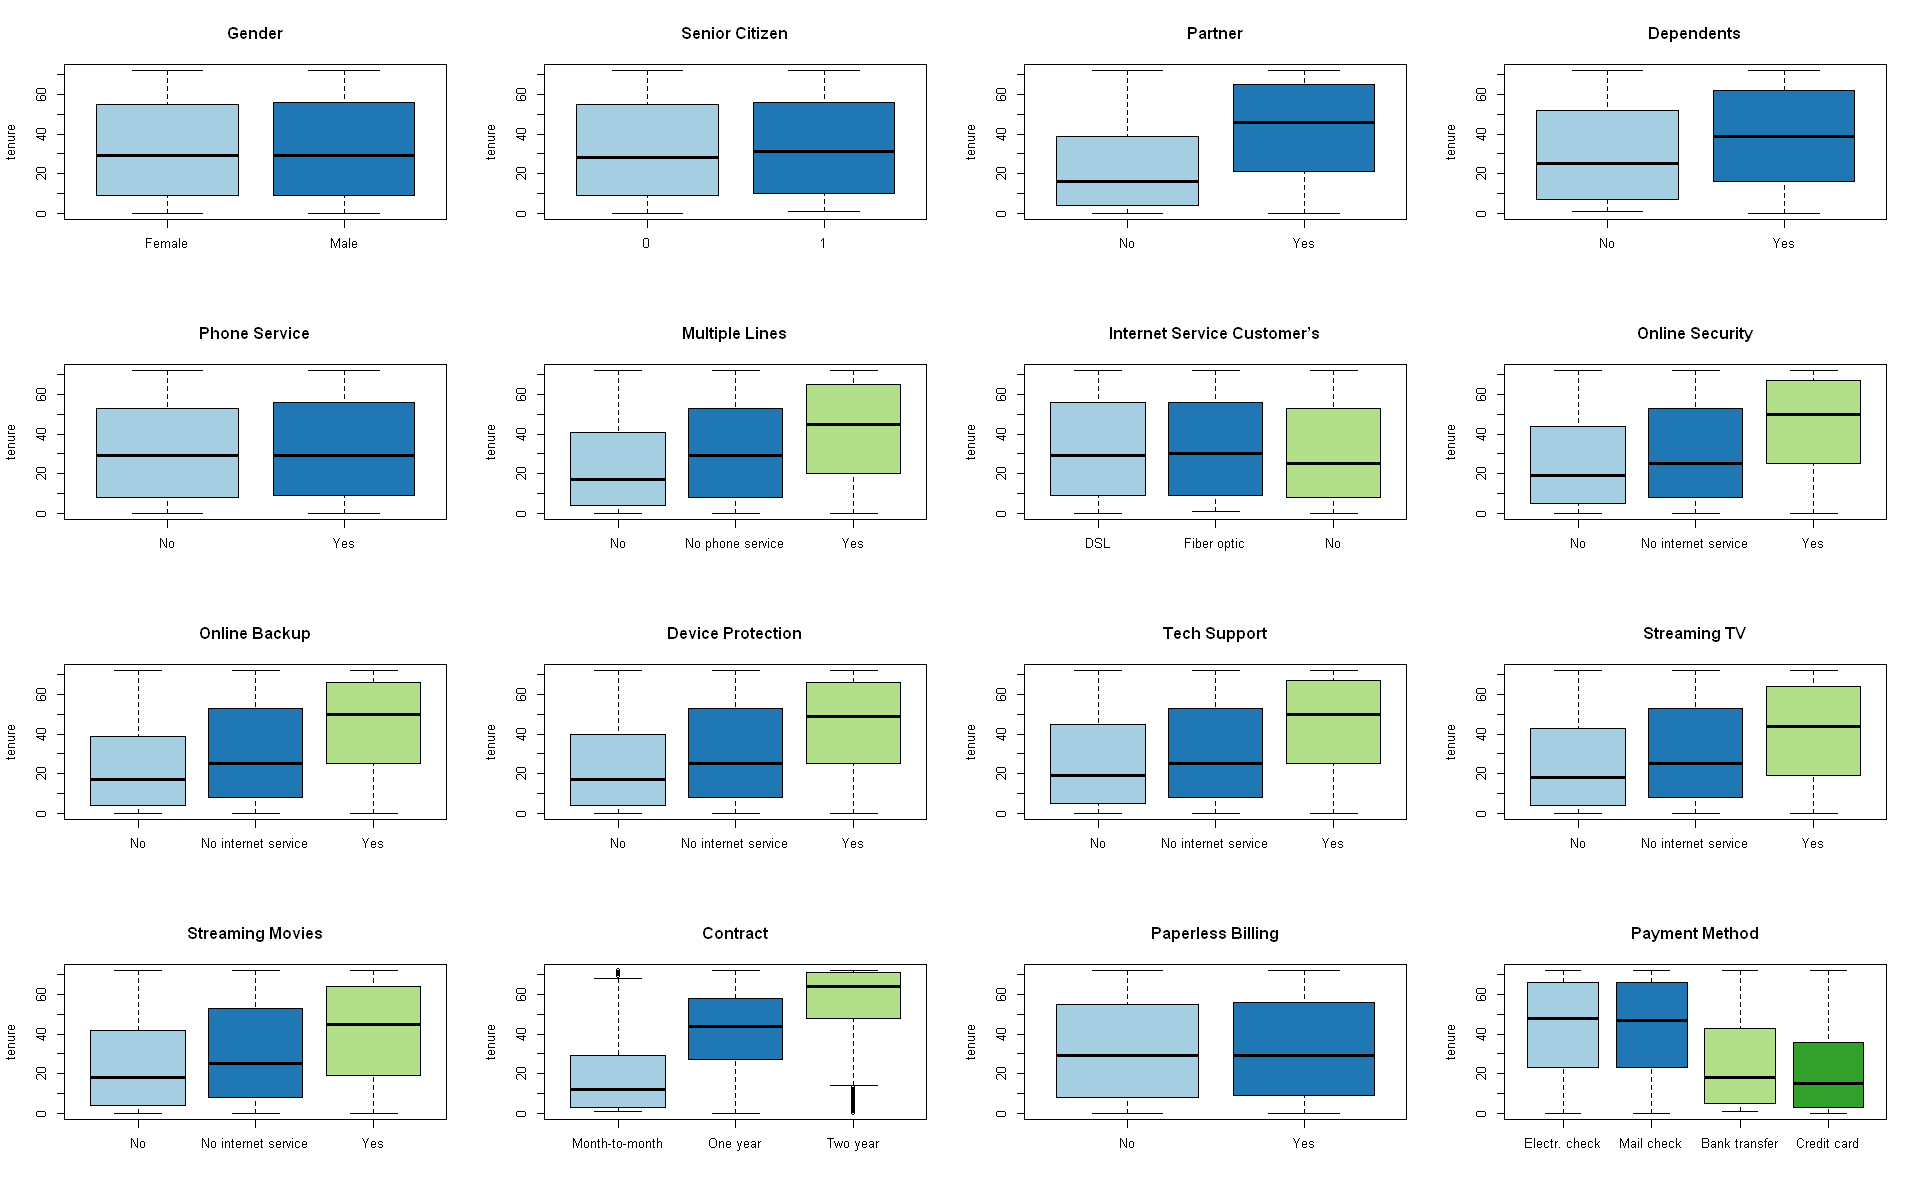

In [12]:
par(mfrow=c(4,4))

myPalette <- brewer.pal(5, "Paired") 

boxplot(tenure~gender, data=churn, xlab = "", col=myPalette, main="Gender")
boxplot(tenure~SeniorCitizen, data=churn, xlab = "", col=myPalette, main="Senior Citizen")
boxplot(tenure~Partner, data=churn, xlab = "", col=myPalette, main="Partner")
boxplot(tenure~Dependents, data=churn, xlab = "", col=myPalette, main="Dependents")

boxplot(tenure~PhoneService, data=churn, xlab = "", col=myPalette, main="Phone Service")
boxplot(tenure~MultipleLines, data=churn, xlab = "", col=myPalette, main="Multiple Lines")
boxplot(tenure~InternetService, data=churn, xlab = "", col=myPalette, main="Internet Service Customer’s")
boxplot(tenure~OnlineSecurity, data=churn, xlab = "",col=myPalette,  main="Online Security")

boxplot(tenure~OnlineBackup, data=churn, xlab = "", col=myPalette, main="Online Backup")
boxplot(tenure~DeviceProtection, data=churn, xlab = "", col=myPalette, main="Device Protection")
boxplot(tenure~TechSupport, data=churn, xlab = "", col=myPalette,  main="Tech Support")
boxplot(tenure~StreamingTV, data=churn, xlab = "", col=myPalette, main="Streaming TV")

boxplot(tenure~StreamingMovies, data=churn, xlab = "", col=myPalette,  main="Streaming Movies")
boxplot(tenure~Contract, data=churn, xlab = "", col=myPalette,  main="Contract")
boxplot(tenure~PaperlessBilling, data=churn, xlab = "", col=myPalette,  main="Paperless Billing")
boxplot(tenure~PaymentMethod, data=churn, xlab = "", col=myPalette, main="Payment Method", names = c('Electr. check', 'Mail check', 'Bank transfer', 'Credit card'))


It seems that we can not stablish a linear relation between charges and tenure, as we can see in the chart below:

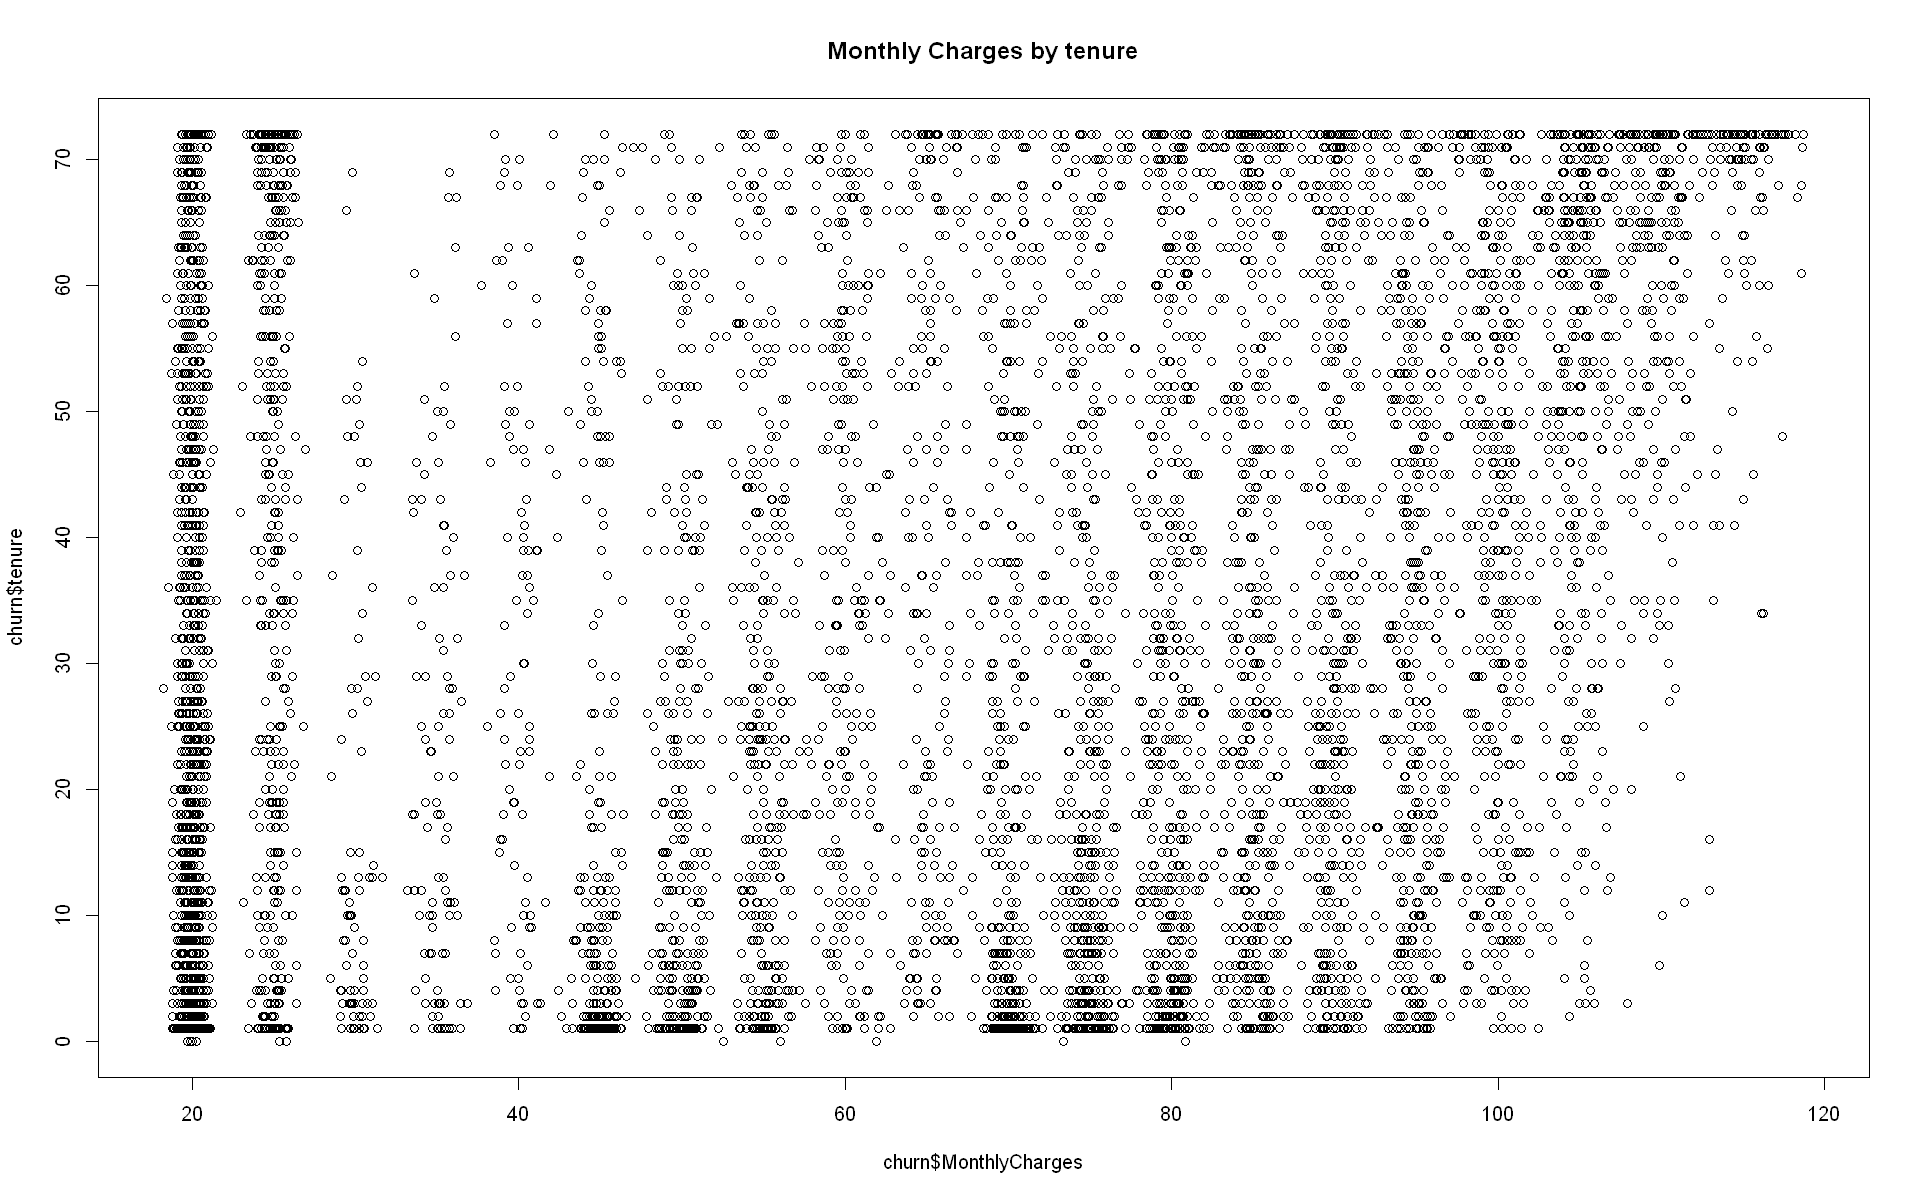

In [13]:
plot(churn$MonthlyCharges, churn$tenure, main= 'Monthly Charges by tenure')

Let's explore to check the assumption that monthly charge is dependent on the other variables of the data set. To do so we ran a linear regression to check this hypothesis, and by analyzing the adjusted R-squared we can say that this is a good model to predict monthly charges, but it could be improved removing some variables that are not significative to the model.

In [14]:
lm.model = lm(MonthlyCharges ~ gender + SeniorCitizen + Partner + 
                          Dependents + PhoneService + MultipleLines + InternetService +
                          OnlineSecurity +OnlineBackup+DeviceProtection + 
                          TechSupport + StreamingTV + StreamingMovies + Contract +
                          PaperlessBilling + PaymentMethod, data =churn)
summary(lm.model)


Call:
lm(formula = MonthlyCharges ~ gender + SeniorCitizen + Partner + 
    Dependents + PhoneService + MultipleLines + InternetService + 
    OnlineSecurity + OnlineBackup + DeviceProtection + TechSupport + 
    StreamingTV + StreamingMovies + Contract + PaperlessBilling + 
    PaymentMethod, data = churn)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.2309 -0.6144 -0.0057  0.6080  4.8404 

Coefficients: (7 not defined because of singularities)
                                       Estimate Std. Error  t value Pr(>|t|)
(Intercept)                           24.968629   0.057368  435.235   <2e-16
genderMale                             0.023526   0.024466    0.962    0.336
SeniorCitizen1                         0.014370   0.035572    0.404    0.686
PartnerYes                            -0.038667   0.029004   -1.333    0.183
DependentsYes                          0.013077   0.031347    0.417    0.677
PhoneServiceYes                       20.050301   0.047992  417.781   <2e-16
M

Removing the variables related to customer and contract categories we achieve a model of charges based on services with an excelent fit (shown by the adjusted R-squared). We conclude that we don't need to use Monthly Charges to build our survival analysis because this information is already captured by the services.

In [15]:
lm.model = lm(MonthlyCharges ~ PhoneService + MultipleLines + InternetService +
                          OnlineSecurity +OnlineBackup+DeviceProtection + 
                          TechSupport + StreamingTV + StreamingMovies, data =churn)
summary(lm.model)


Call:
lm(formula = MonthlyCharges ~ PhoneService + MultipleLines + 
    InternetService + OnlineSecurity + OnlineBackup + DeviceProtection + 
    TechSupport + StreamingTV + StreamingMovies, data = churn)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.2527 -0.6132 -0.0059  0.6003  4.7973 

Coefficients: (7 not defined because of singularities)
                                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)                          24.95251    0.04478   557.2   <2e-16 ***
PhoneServiceYes                      20.05241    0.04783   419.2   <2e-16 ***
MultipleLinesNo phone service              NA         NA      NA       NA    
MultipleLinesYes                      5.01220    0.02815   178.0   <2e-16 ***
InternetServiceFiber optic           24.95737    0.03356   743.6   <2e-16 ***
InternetServiceNo                   -25.04904    0.04261  -587.9   <2e-16 ***
OnlineSecurityNo internet service          NA         NA      NA       NA    
OnlineSecurityYes   

# Analysis
<hr>


## Kaplan-Meir

We can observe in the Kaplan-Meier chart that in one year the company lost in the first year 15% of customer, 6% in the second year and 4% in the third year.

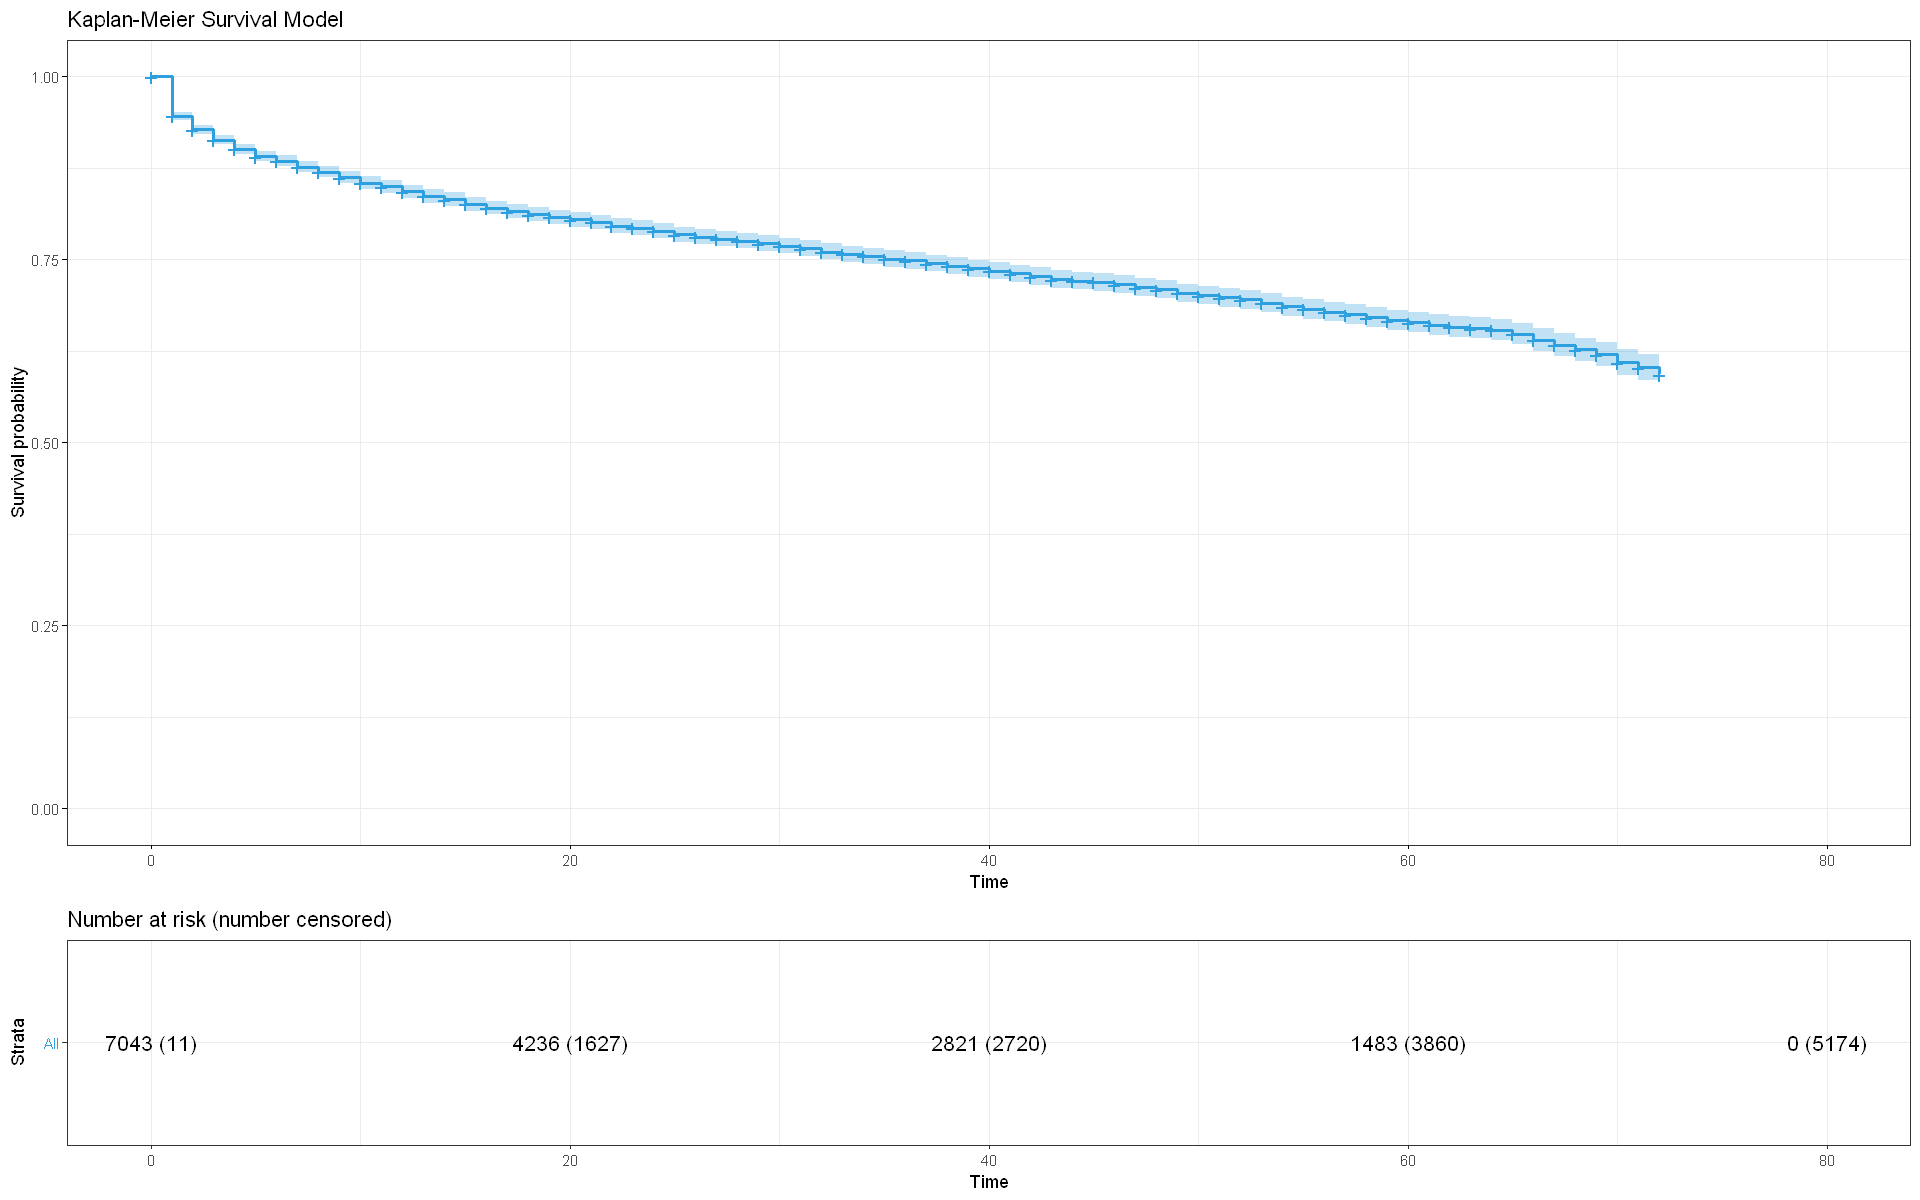

In [16]:
km.model <- survfit(Surv(churn$tenure, churn$event)~1, data = churn, type="kaplan-meier")
ggsurvplot(km.model,
          risk.table = "nrisk_cumcensor", # Add risk table
          ggtheme = theme_bw(), # Change ggplot2 theme
          palette = c("#2E9FDF"),
          title ='Kaplan-Meier Survival Model', 
          legend = 'none')

#### a) Demographic Analysis

We used the Logrank test to confirm Kaplan-Meier estimation that gender do not have a different pattern in relation to customer retention.  

By observing the Kaplan-Meier charts we see that there is higher hazard of churn customers without partners, seniors and without dependents.

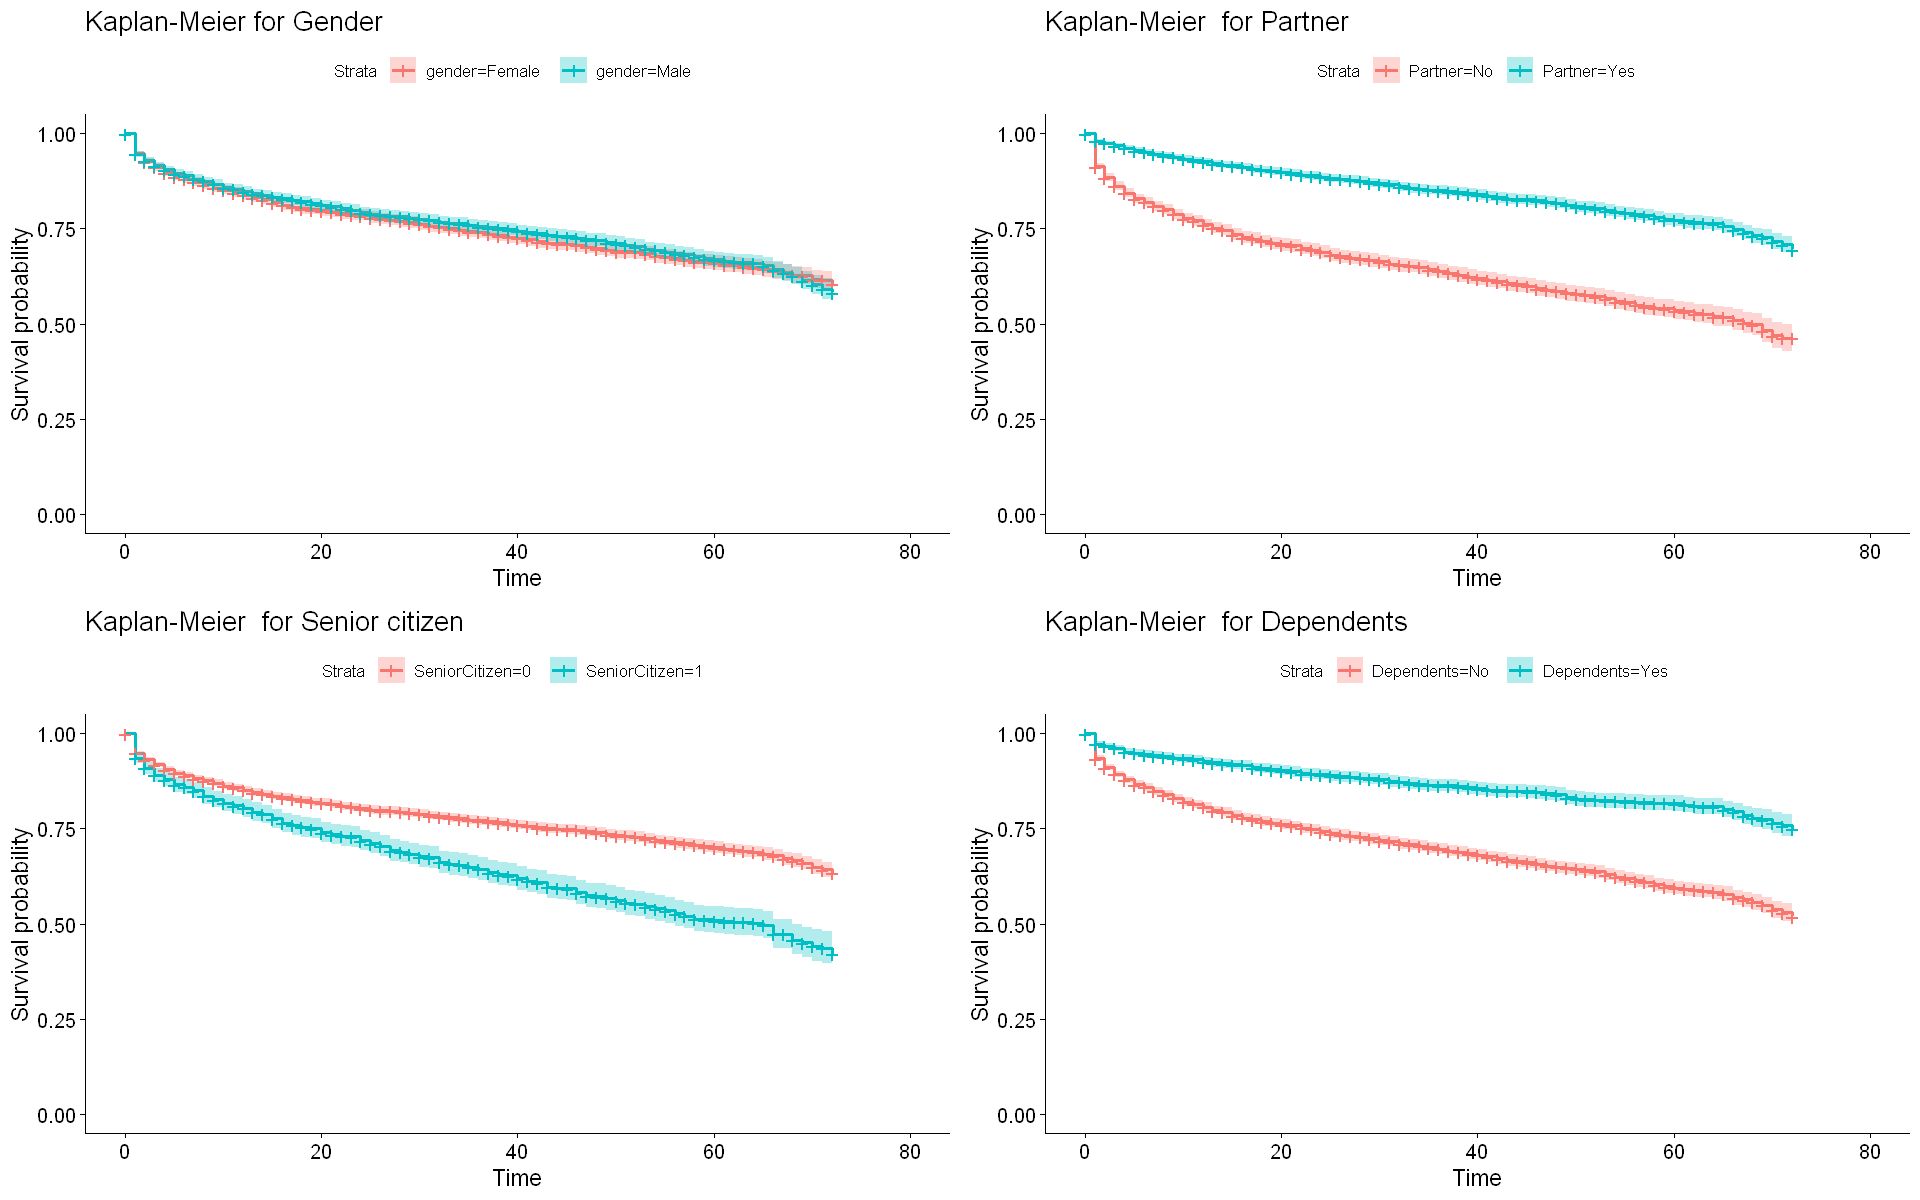

In [17]:
d_splots <- list()
d_splots[[1]] = ggsurvplot(survfit(Surv(tenure, event) ~ gender, data = churn), conf.int = TRUE,
           title = 'Kaplan-Meier for Gender', xlab = 'Time')
d_splots[[2]] = ggsurvplot(survfit(Surv(tenure, event) ~ SeniorCitizen, data = churn), conf.int = TRUE,
           title = 'Kaplan-Meier  for Senior citizen', xlab = 'Time')
d_splots[[3]] = ggsurvplot(survfit(Surv(tenure, event) ~ Partner, data = churn), conf.int = TRUE,
           title = 'Kaplan-Meier  for Partner', xlab = 'Time')
d_splots[[4]] = ggsurvplot(survfit(Surv(tenure, event) ~ Dependents, data = churn), conf.int = TRUE,
           title = 'Kaplan-Meier  for Dependents', xlab = 'Time')

arrange_ggsurvplots(d_splots, nrow = 2, ncol = 2)

In [18]:
#Logrank for Gender
survdiff(Surv(tenure, event) ~ gender, data = churn)

Call:
survdiff(formula = Surv(tenure, event) ~ gender, data = churn)

                 N Observed Expected (O-E)^2/E (O-E)^2/V
gender=Female 3488      939      923     0.261     0.526
gender=Male   3555      930      946     0.255     0.526

 Chisq= 0.5  on 1 degrees of freedom, p= 0.5 

#### b) Customer Account Analysis

It is impressive the difference on hazard that comes from month-to-month contracts when compared to the other types. We can also observe the same trend when electronic checks are used as payment method. An surprising indicator is that customer who do not receive paper bills have lower survival time.

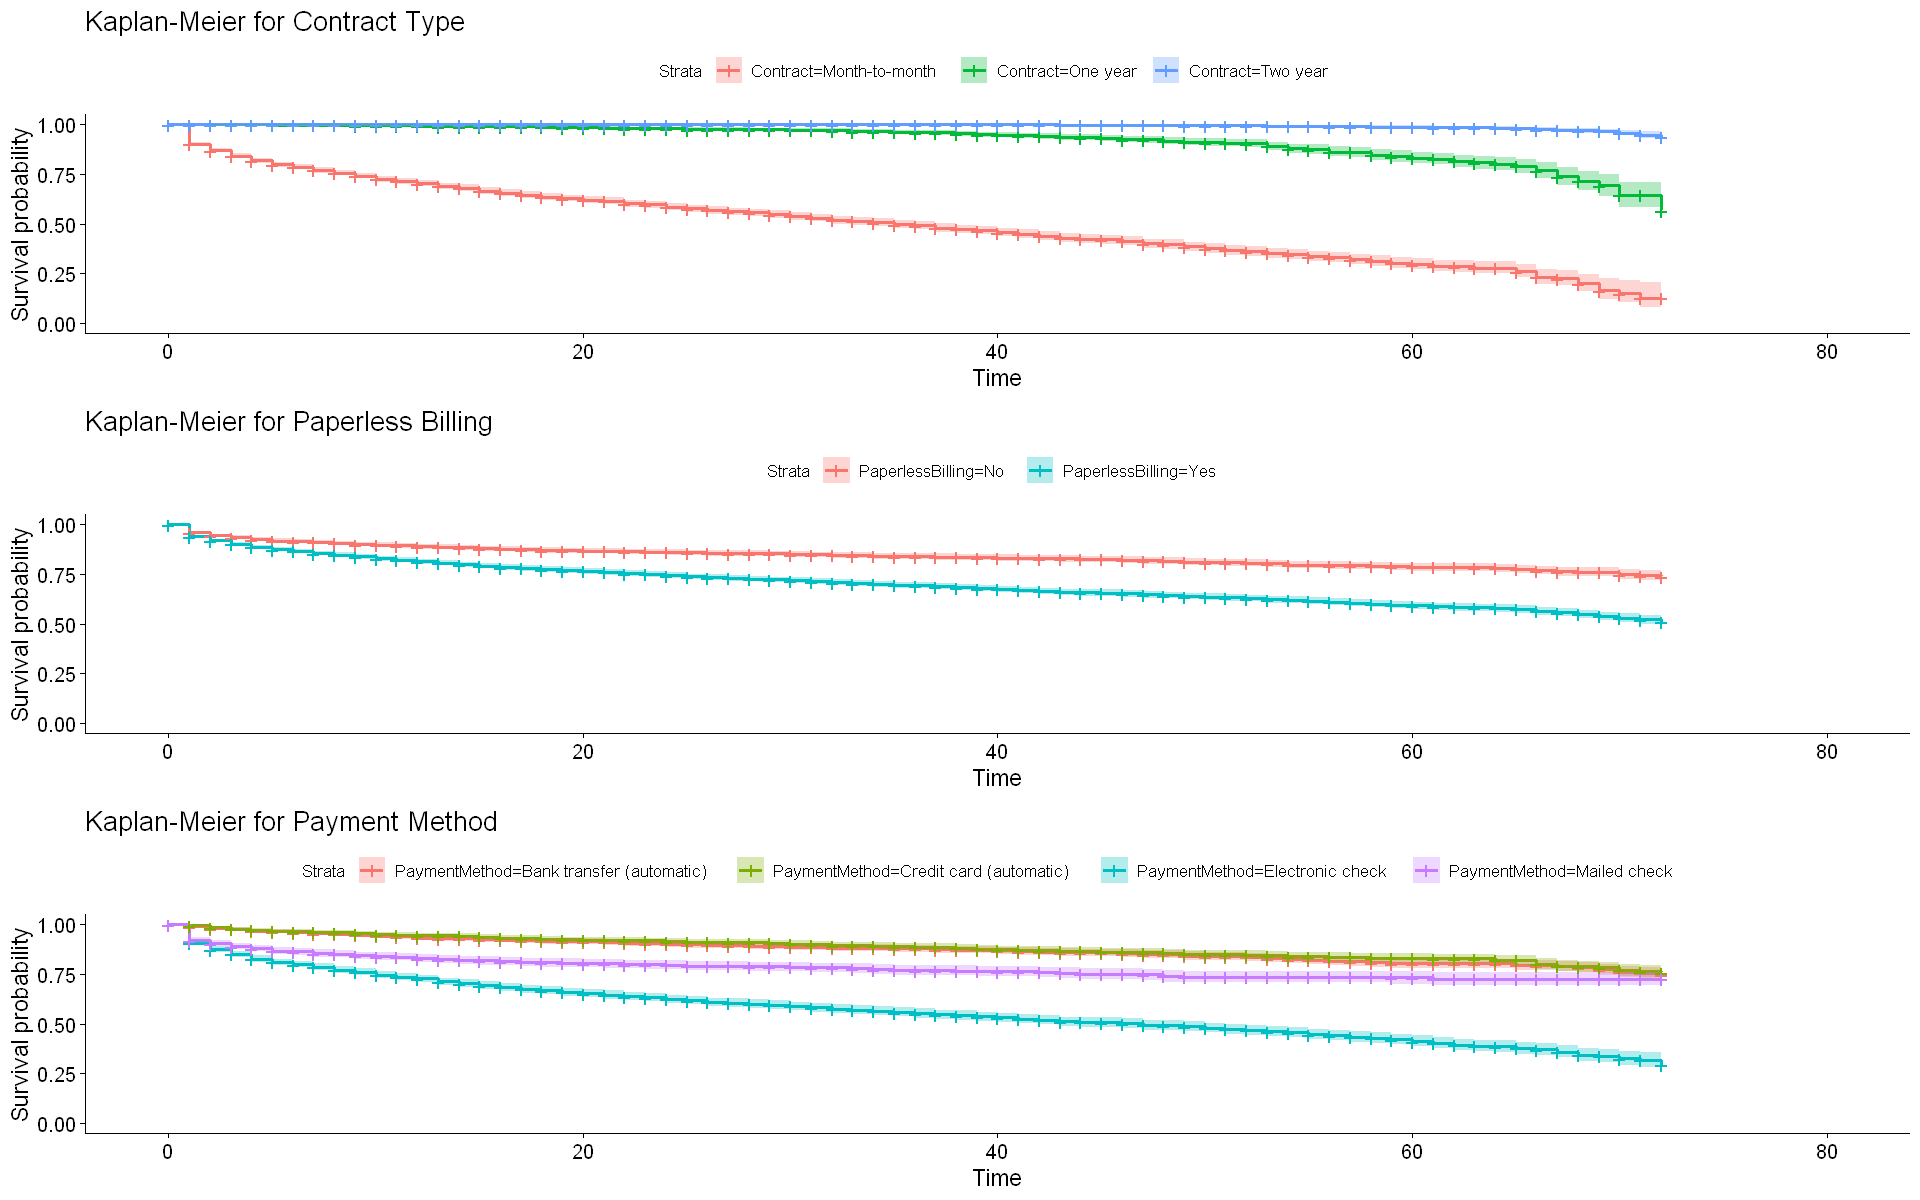

In [19]:
c_splots <- list()

c_splots[[1]] = ggsurvplot(survfit(Surv(tenure, event) ~ Contract, data = churn), conf.int = TRUE,
           title = 'Kaplan-Meier for Contract Type', xlab = 'Time')  
c_splots[[2]] = ggsurvplot(survfit(Surv(tenure, event) ~ PaperlessBilling, data = churn), conf.int = TRUE,
           title = 'Kaplan-Meier for Paperless Billing', xlab = 'Time')
c_splots[[3]] = ggsurvplot(survfit(Surv(tenure, event) ~ PaymentMethod, data = churn), conf.int = TRUE,
           title = 'Kaplan-Meier for Payment Method', xlab = 'Time')

arrange_ggsurvplots(c_splots, nrow = 3, ncol = 1)

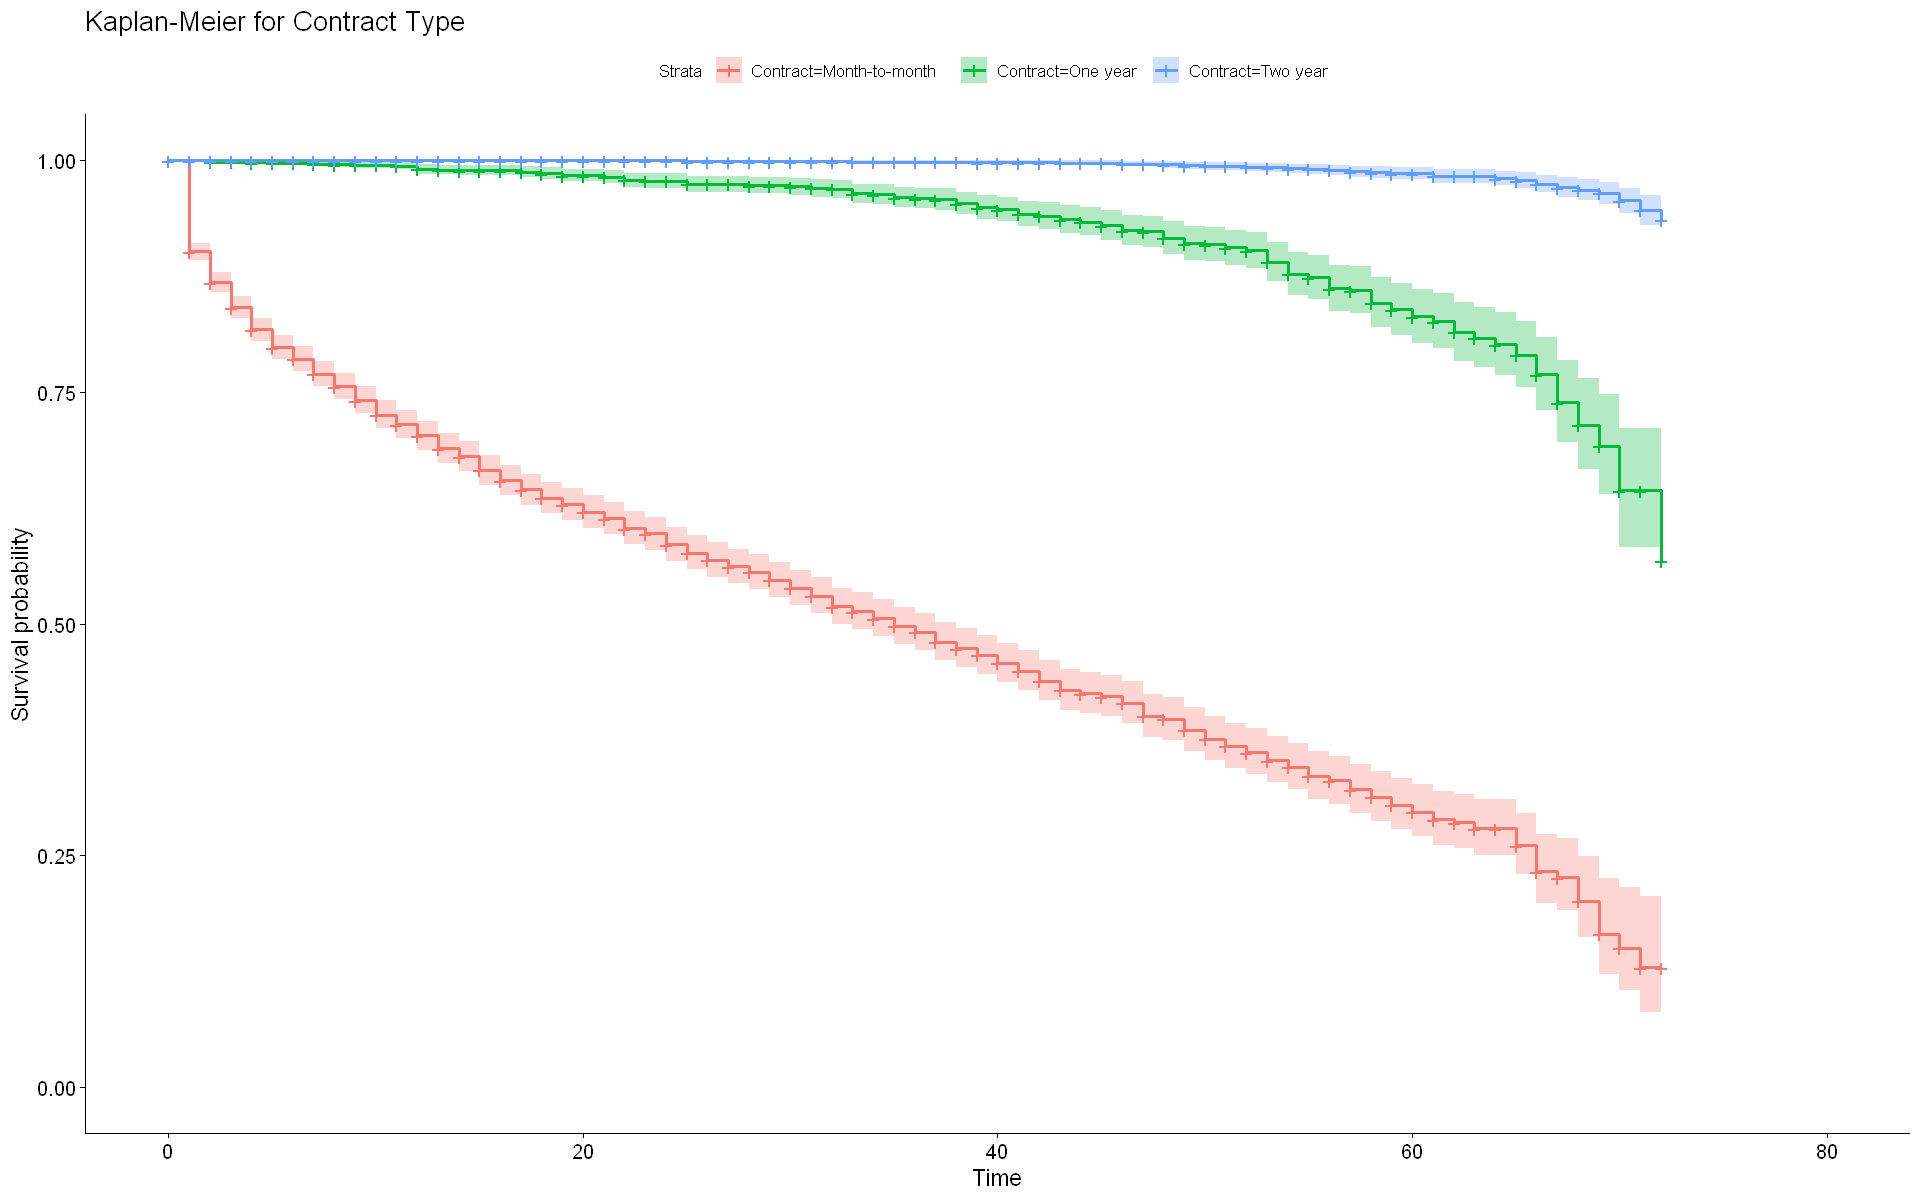

In [20]:
ggsurvplot(survfit(Surv(tenure, event) ~ Contract, data = churn), conf.int = TRUE,
           title = 'Kaplan-Meier for Contract Type', xlab = 'Time')  

#### c) Services Analysis

We used the Logrank test to confirm Kaplan-Meier estimation that phone service do not have a different pattern in relation to customer retention.

One interesting finding from the survival curves is that customer without internet service have higher survival time when compared to those who contracted this service. The inexistance of technical support is also a factor that increases the hazard when compared to other categories. 

The absence of services related to risk mitigation in the perspective of the consumer (device protection, online security and online backup) represent higher hazard of churn.

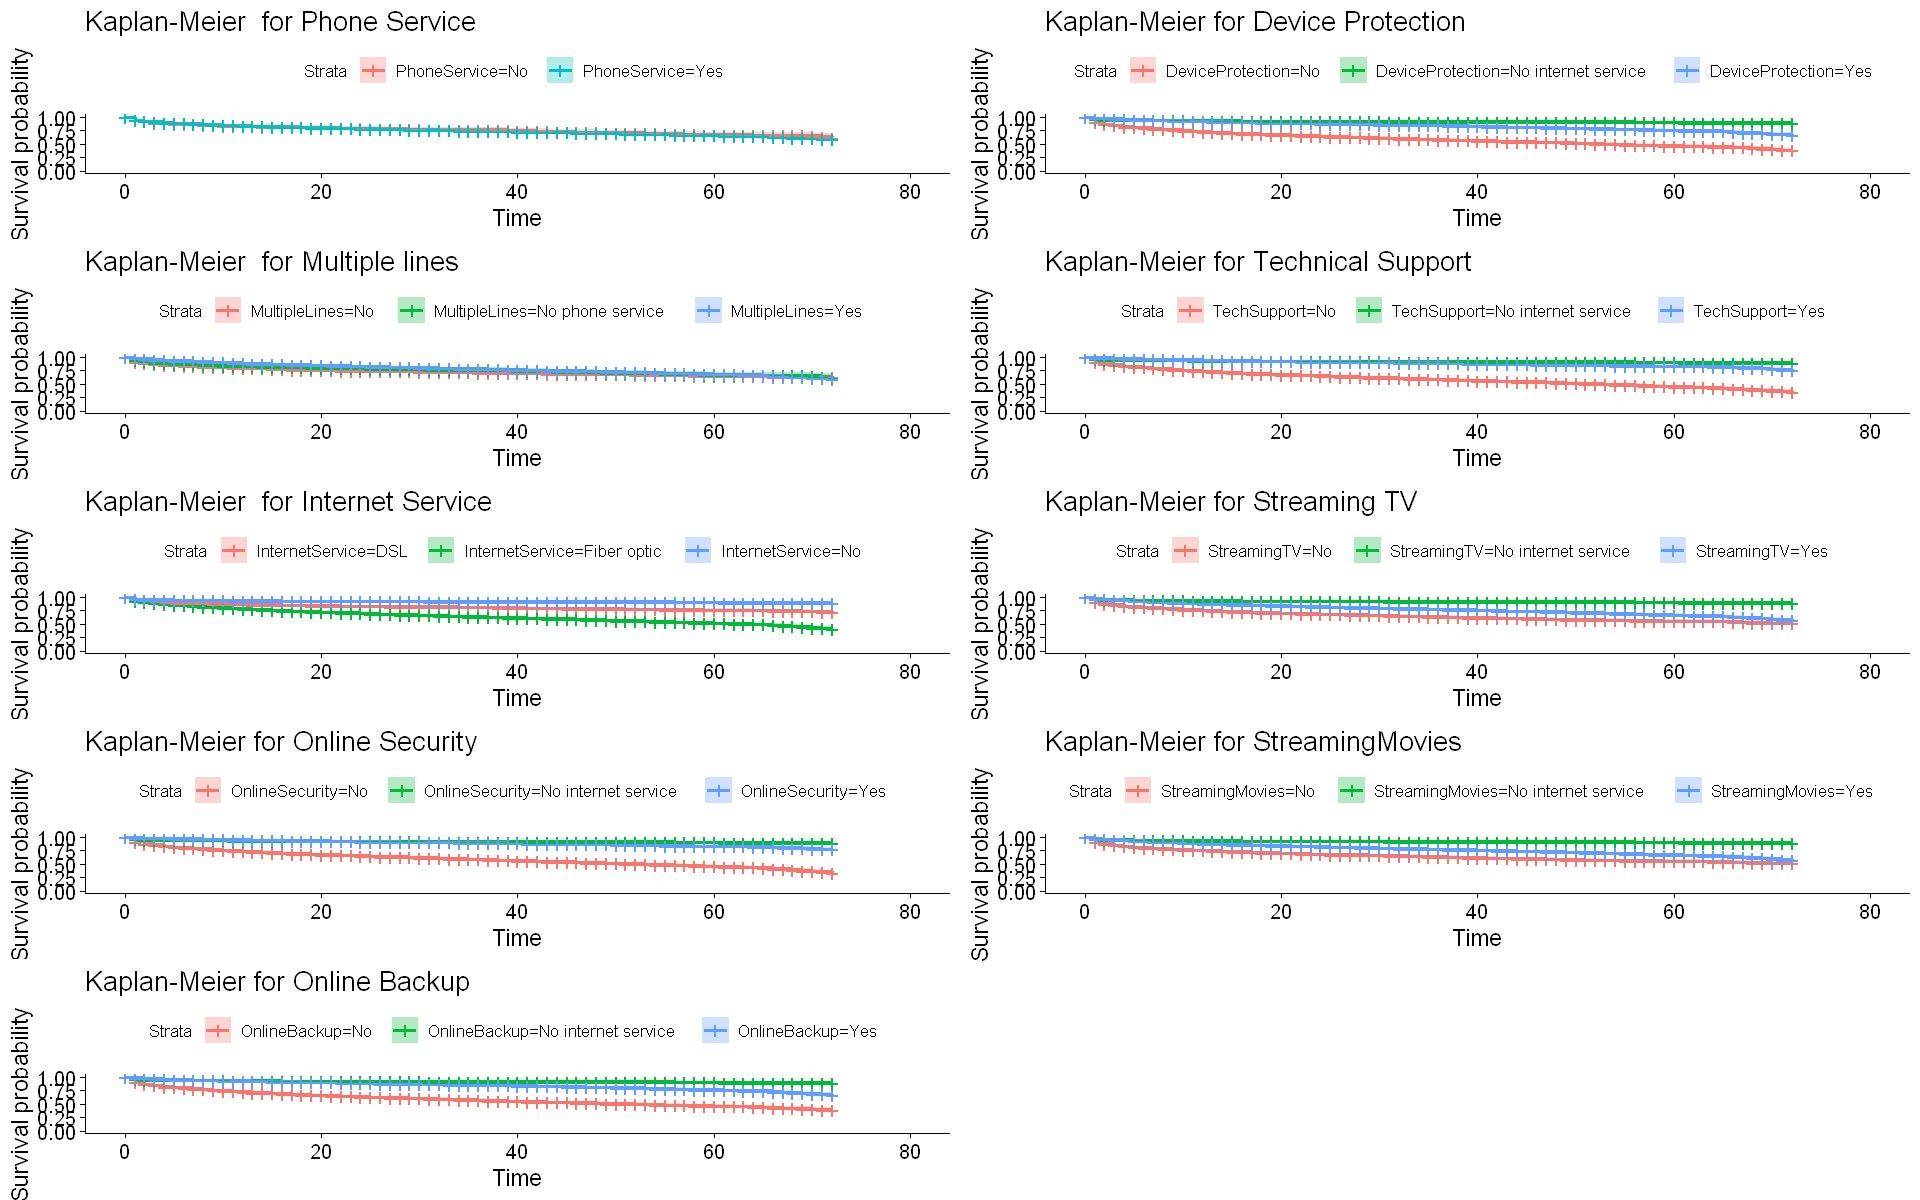

In [21]:
s_splots <- list()
s_splots[[1]] = ggsurvplot(survfit(Surv(tenure, event) ~ PhoneService, data = churn), conf.int = TRUE,
           title = 'Kaplan-Meier  for Phone Service', xlab = 'Time')
s_splots[[2]] = ggsurvplot(survfit(Surv(tenure, event) ~ MultipleLines, data = churn), conf.int = TRUE,
           title = 'Kaplan-Meier  for Multiple lines', xlab = 'Time')
s_splots[[3]] = ggsurvplot(survfit(Surv(tenure, event) ~ InternetService, data = churn), conf.int = TRUE,
           title = 'Kaplan-Meier  for Internet Service', xlab = 'Time')
s_splots[[4]] = ggsurvplot(survfit(Surv(tenure, event) ~ OnlineSecurity, data = churn), conf.int = TRUE,
           title = 'Kaplan-Meier for Online Security', xlab = 'Time')
s_splots[[5]] = ggsurvplot(survfit(Surv(tenure, event) ~ OnlineBackup, data = churn), conf.int = TRUE,
           title = 'Kaplan-Meier for Online Backup', xlab = 'Time')
s_splots[[6]] = ggsurvplot(survfit(Surv(tenure, event) ~ DeviceProtection, data = churn), conf.int = TRUE,
           title = 'Kaplan-Meier for Device Protection', xlab = 'Time')
s_splots[[7]] = ggsurvplot(survfit(Surv(tenure, event) ~ TechSupport, data = churn), conf.int = TRUE,
           title = 'Kaplan-Meier for Technical Support', xlab = 'Time')
s_splots[[8]] = ggsurvplot(survfit(Surv(tenure, event) ~ StreamingTV, data = churn), conf.int = TRUE,
           title = 'Kaplan-Meier for Streaming TV', xlab = 'Time')
s_splots[[9]] = ggsurvplot(survfit(Surv(tenure, event) ~ StreamingMovies, data = churn), conf.int = TRUE,
           title = 'Kaplan-Meier for StreamingMovies', xlab = 'Time')
arrange_ggsurvplots(s_splots, nrow = 5, ncol = 2)

In [22]:
#Logrank for Phone Service
survdiff(Surv(tenure, event) ~ PhoneService, data = churn)

Call:
survdiff(formula = Surv(tenure, event) ~ PhoneService, data = churn)

                    N Observed Expected (O-E)^2/E (O-E)^2/V
PhoneService=No   682      170      178    0.3828     0.431
PhoneService=Yes 6361     1699     1691    0.0404     0.431

 Chisq= 0.4  on 1 degrees of freedom, p= 0.5 

## Cox Proportional Hazards

In [23]:
COXPH_Analysis <- function(covariates) {
    
    # Generates a summary data frame with the result of the coxph regression and the Schoenfeld test of 
    # constant proportionality
    univ_formulas <- sapply(covariates,
                            function(x) as.formula(paste('Surv(tenure, event)~', x)))

    univ_models <- lapply( univ_formulas, function(x){coxph(x, data = churn)})
    univ_results <- lapply(univ_models,
                       function(x){ 
                          sch.test = cox.zph(x)$table[1,'p'][1]
                          sch.test = ifelse(sch.test < .01, scientific(sch.test,1), round(sch.test,2))
                          x <- summary(x)
                          
                          df_coef = as.data.frame(x$coef)
                          df_conf.int = as.data.frame(x$conf.int)
                           
                          for (row in 1:nrow(df_coef)) {
                            #print(df[row,])
                              p.value<-signif(df_coef[row, 5], digits=2)
                              beta<-signif(df_coef[row,1], digits=2);#coeficient beta
                              HR <-signif(df_coef[row,2], digits=2);#exp(beta)
                              HR.confint.lower <- signif(df_conf.int[row,"lower .95"], 2)
                              HR.confint.upper <- signif(df_conf.int[row,"upper .95"],2)
                              HR <- paste0(HR, " (", 
                                           HR.confint.lower, "-", HR.confint.upper, ")")
                              
                              if (nrow(df_coef) > 1 & row > 1) {
                                  res <- cbind(res,c(row.names(df_coef)[row], HR, p.value, sch.test))
                              }
                              else {
                                  res<-c(row.names(df_coef)[row], HR, p.value, sch.test)
                                  names(res)<-c("Type", "HR (95% CI)", 
                                            "Cox PH coefficient p.value", "Schoenfeld test p.value")
                              }
                          }
                          return(res)
                         })
    res <- t(as.data.frame(univ_results, check.names = FALSE))
    as.data.frame(res, row.names = FALSE)
                        }

### a) Demographic Analysis

The cox proportional model shows that gender male versus female has a proportional harzard ratio of .97 with a p-value of 0.47, and a 95% confidence interval of 0.99 to 1.03. Because of the p-value and the fact that the confidence interval for HR includes 1, these results indicate that males do not have a different hazard ratio from female. By the Schoenfeld test we can say that gender proportional hazard can be considered constant throughout time.

The covariates Senior Citizen and Partner are significant to the model, but they cannot be considered constant over the period. The hazard ratio for senior citizen is higher than for young citizens. On the other hand, customers who have partners have lower risk of churn when compared to those who are single.

Having dependents represents a lower risk of churn in relation to those customer on the reference group, and it has a constant behaviour over the entire period. This variable is considered statistically significant.

In [24]:
COXPH_Analysis(c('gender','SeniorCitizen','Partner','Dependents'))

Type,HR (95% CI),Cox PH coefficient p.value,Schoenfeld test p.value
<fct>,<fct>,<fct>,<fct>
genderMale,0.97 (0.88-1.1),0.47,0.18
SeniorCitizen1,1.7 (1.6-1.9),6.4e-25,2e-05
PartnerYes,0.38 (0.34-0.41),4.3e-88,2e-11
DependentsYes,0.41 (0.36-0.46),3.6e-49,0.1


### b) Customer Account Analysis

The contract 'Month-to-month is the reference level and presents higher risk of churn when compared to "One year" or "Two year". The covariates is statistically significant but it's p-value demonstrate that it is not constant.

Customers who made a choice by paperless billing have higher risk of churn in relation to those customer on the reference group, but the hazard ratio is not constant over the entire period. This variable is considered statistically significant.

Electronic checks and mailed check payments represent higher risk of churn than automatic bank transfer, while automatic credit card to have no difference from the control group. This variable cannot be considered constant over time, and only automatic credit card is considered not statistically significant for the model.

In [25]:
COXPH_Analysis(c('Contract','PaperlessBilling','PaymentMethod'))

Type,HR (95% CI),Cox PH coefficient p.value,Schoenfeld test p.value
<fct>,<fct>,<fct>,<fct>
ContractOne year,0.11 (0.095-0.13),5.8e-152,8e-25
ContractTwo year,0.015 (0.011-0.02),5e-161,8e-25
PaperlessBillingYes,2 (1.8-2.3),3.6e-41,1e-04
PaymentMethodCredit card (automatic),0.92 (0.77-1.1),0.34,4e-18
PaymentMethodElectronic check,4.2 (3.7-4.9),8.4e-95,4e-18
PaymentMethodMailed check,2 (1.7-2.3),1.4e-15,4e-18


### c) Services Analysis

The covariate phone services is the only one that is not statistically significant to the model, and that has a constant hazard ratio over time. 

Customer with fiber optic service present a higher risk of churn rate when compared to those who have DSL. While customers with no internet access have lower risk of churn when compared to the reference group of the covariates. 

In [26]:
COXPH_Analysis(c('PhoneService','MultipleLines','InternetService','OnlineSecurity',
                 'OnlineBackup','DeviceProtection','TechSupport','StreamingTV', 'StreamingMovies'))

Type,HR (95% CI),Cox PH coefficient p.value,Schoenfeld test p.value
<fct>,<fct>,<fct>,<fct>
PhoneServiceYes,1.1 (0.9-1.2),0.52,0.13
MultipleLinesNo phone service,0.82 (0.7-0.97),0.018,2e-27
MultipleLinesYes,0.76 (0.69-0.84),2.3e-08,2e-27
InternetServiceFiber optic,2.2 (2-2.5),1.9e-48,9e-21
InternetServiceNo,0.41 (0.33-0.5),2e-17,9e-21
OnlineSecurityNo internet service,0.15 (0.13-0.19),1.1e-81,6e-17
OnlineSecurityYes,0.22 (0.2-0.25),2.2e-120,6e-17
OnlineBackupNo internet service,0.15 (0.13-0.18),6.9e-82,8e-25
OnlineBackupYes,0.33 (0.29-0.36),2.9e-98,8e-25


After analyzing the result of the Schoenfeld test for the individual covariates we draw the conclusion that we cannot accept the assumption of proportionality of hazards is constant over time for the majority of variables in the dataset. So it invalidates to the use of a cox proportional model to explain the churn.

## Stratified Proportional Hazards Models

An alternative to the proportionality of hazards is to use the stratified proportional hazards, but the concordance level is to low, so we conclude that it is not a good model to predict the churn.

In [27]:
coxph.full.model =  coxph(Surv(tenure, event) ~ gender + strata(SeniorCitizen) + strata(Partner) + 
                          Dependents + PhoneService + strata(MultipleLines) + strata(InternetService) +
                          strata(OnlineSecurity) + strata(OnlineBackup) + strata(DeviceProtection) + 
                          strata(TechSupport) + strata(StreamingTV) + strata(StreamingMovies) + strata(Contract) +
                          strata(PaperlessBilling) + strata(PaymentMethod),
                          data = churn)
summary(coxph.full.model)

Call:
coxph(formula = Surv(tenure, event) ~ gender + strata(SeniorCitizen) + 
    strata(Partner) + Dependents + PhoneService + strata(MultipleLines) + 
    strata(InternetService) + strata(OnlineSecurity) + strata(OnlineBackup) + 
    strata(DeviceProtection) + strata(TechSupport) + strata(StreamingTV) + 
    strata(StreamingMovies) + strata(Contract) + strata(PaperlessBilling) + 
    strata(PaymentMethod), data = churn)

  n= 7043, number of events= 1869 

                     coef exp(coef)  se(coef)      z Pr(>|z|)
genderMale      -0.006774  0.993249  0.067700 -0.100    0.920
DependentsYes   -0.060602  0.941198  0.108558 -0.558    0.577
PhoneServiceYes        NA        NA  0.000000     NA       NA

                exp(coef) exp(-coef) lower .95 upper .95
genderMale         0.9932      1.007    0.8698     1.134
DependentsYes      0.9412      1.062    0.7608     1.164
PhoneServiceYes        NA         NA        NA        NA

Concordance= 0.496  (se = 0.019 )
Likelihood ratio test= 0.

## Survival Trees

Once we cannot use Cox Proportional Hazards model to analyze the features that impact the churn throught the period we decided to analyze the survival trees, and to be more assertive we are going to do this analysis taking into consideration the customer profile.

Once we previously verified that gender has no impact on the churn, therefore the profile studied will use only the variables SeniorCitizen, Partner and Dependents. 

In [28]:
profile = churn %>%
    group_by(SeniorCitizen, Partner, Dependents) %>%
    summarise(Customers=n(), Churn=sum(event))

In [29]:
profile = as.data.frame(profile)
profile['% Customers'] = round((profile['Customers']/sum(profile['Customers']))*100,1)
profile['% Profile Internal Churn'] = round((profile['Churn']/profile['Customers'])*100,1)
profile['% Overall Churn'] = round(profile['% Customers']*profile['% Profile Internal Churn']/100,1)
profile[order(-profile$`% Overall Churn`),]

,SeniorCitizen,Partner,Dependents,Customers,Churn,% Customers,% Profile Internal Churn,% Overall Churn
,<fct>,<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,No,No,2719,847,38.6,31.2,12.0
5,1,No,No,561,276,8.0,49.2,3.9
3,0,Yes,No,1163,242,16.5,20.8,3.4
4,0,Yes,Yes,1666,229,23.7,13.7,3.2
7,1,Yes,No,490,178,7.0,36.3,2.5
2,0,No,Yes,353,75,5.0,21.2,1.1
8,1,Yes,Yes,83,20,1.2,24.1,0.3
6,1,No,Yes,8,2,0.1,25.0,0.0


The churn rate of the company over the period was of 26.5%, of which 45.3% comes from young customers without partners and dependents and 14.7% from seniors, also without partners and dependents. By applying the Pareto principle to deal with 85% of the churn we will work with 4 segments:

- <b>Segment 1:</b> young citizens without partners and dependents;
- <b>Segment 2:</b> senior citizens without partners and dependents;
- <b>Segment 3:</b> young citizens with partners and no dependents;
- <b>Segment 4:</b> young citizens with partners and dependents;

In [30]:
# Young Citizens without partners and dependents
seg1 = churn[which(churn$SeniorCitizen == 0 & churn$Partner == 'No' & churn$Dependents == 'No'),]
km.model.seg1 <- survfit(Surv(tenure, event) ~ 1, 
                         data = seg1, type="kaplan-meier")

# Senior Citizens without partners and dependents
seg2 = churn[which(churn$SeniorCitizen == 1 & churn$Partner == 'No' & churn$Dependents == 'No'),]
km.model.seg2 <- survfit(Surv(tenure, event) ~ 1, data = seg2, type="kaplan-meier")

# Young Citizens with partners and without dependents
seg3 = churn[which(churn$SeniorCitizen == 0 & churn$Partner == 'Yes' & churn$Dependents == 'No'),]
km.model.seg3 <- survfit(Surv(tenure, event) ~ 1, data = seg3, type="kaplan-meier")

# Young Citizens with partners and dependents
seg4 = churn[which(churn$SeniorCitizen == 0 & churn$Partner == 'Yes' & churn$Dependents == 'Yes'),]
km.model.seg4 <- survfit(Surv(tenure, event) ~ 1, data = seg4, type="kaplan-meier")

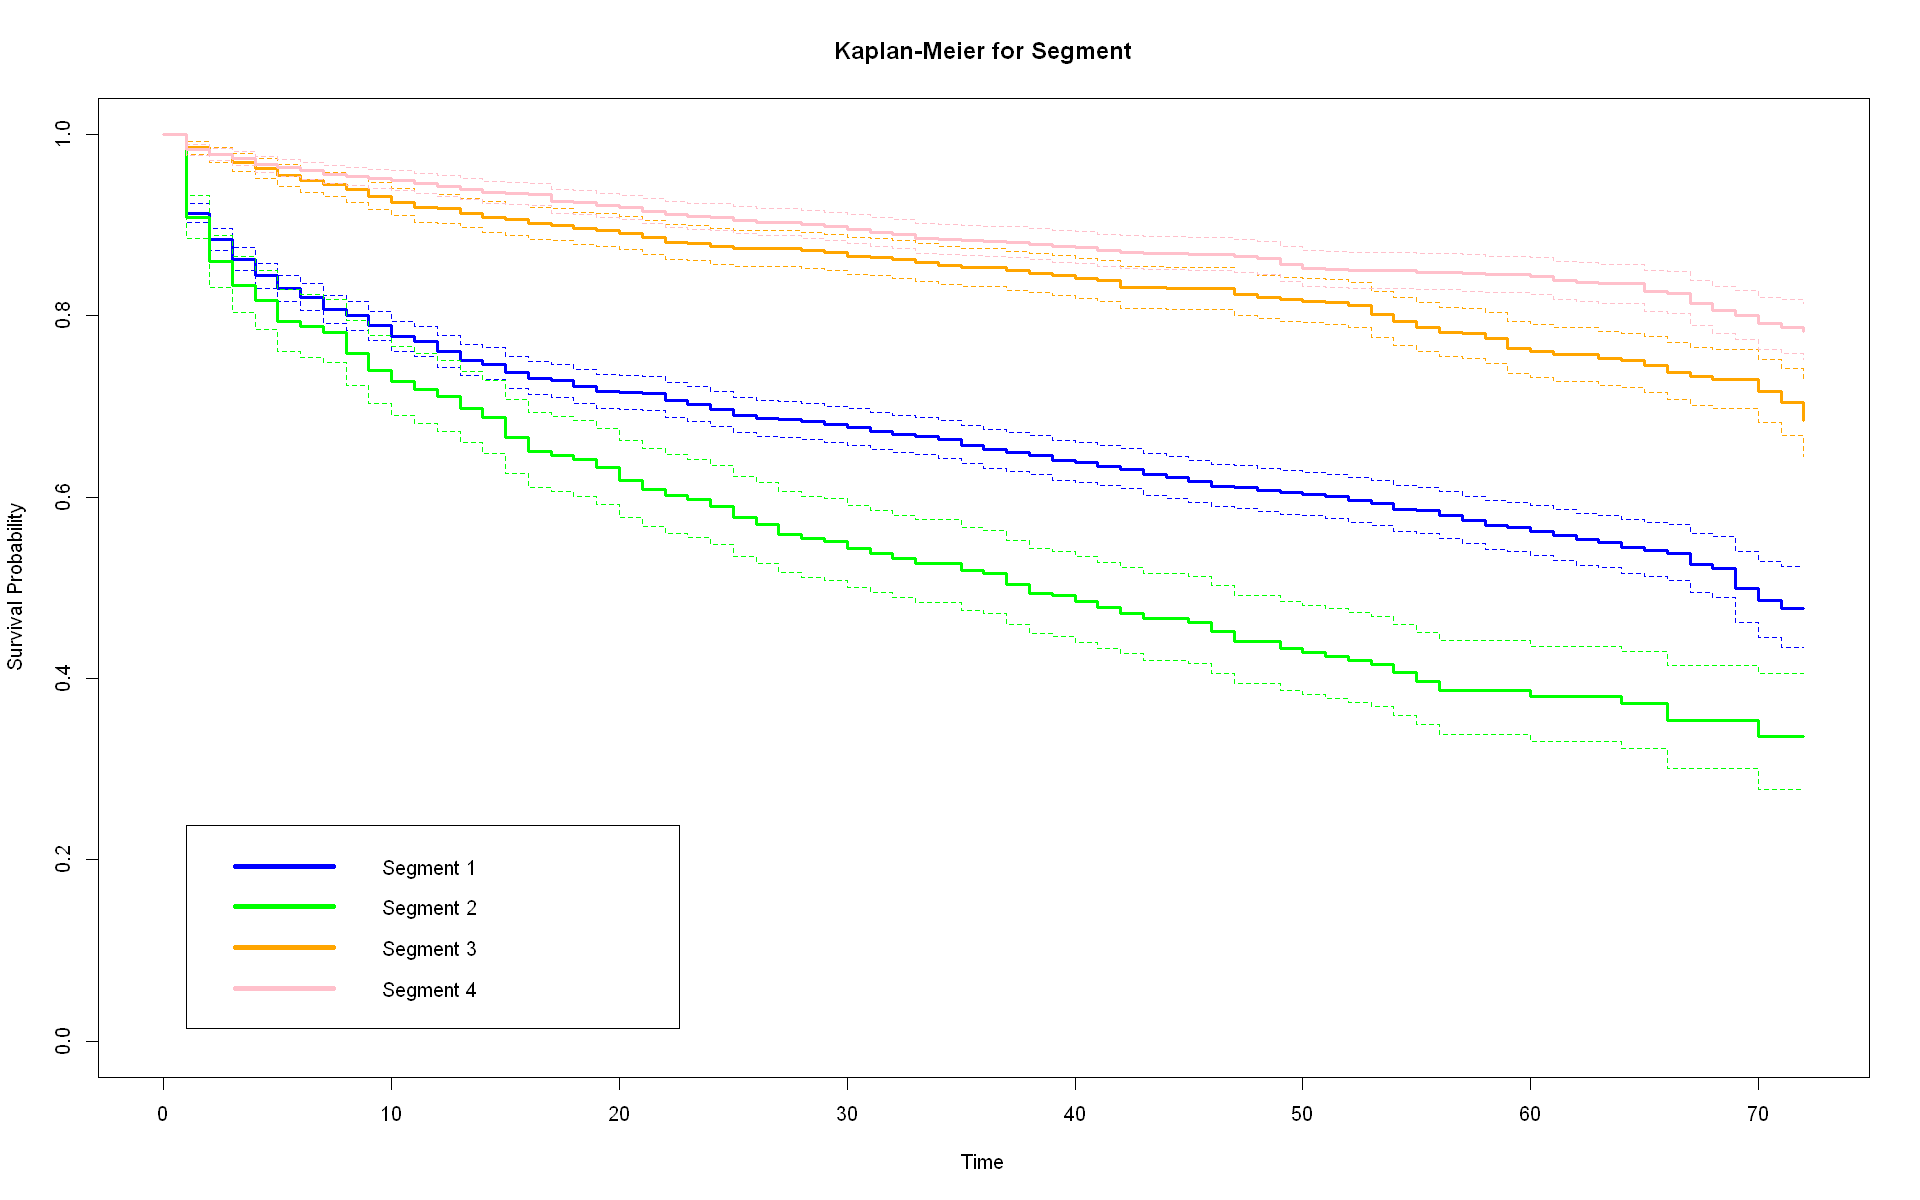

In [31]:
plot(km.model.seg1,, col ='blue', lwd=c(3,1,1), main= 'Kaplan-Meier for Segment', ylab='Survival Probability', xlab='Time')
lines(km.model.seg2, col = 'green', lwd=c(3,1,1))
lines(km.model.seg3, col = 'orange', lwd=c(3,1,1))
lines(km.model.seg4, col = 'pink', lwd=c(3,1,1))

legend("bottomleft", 
  legend = c('Segment 1','Segment 2','Segment 3','Segment 4'),
  col = c( 'blue', 'green' , 'orange', 'pink'), 
  bty = "y", 
  lwd = 4,
  pt.cex = 2, 
  cex = 1, 
  text.col = "black", 
  horiz = F,
  inset=0.05)

From the graph we can draw the conclusion that customers with no partners and no dependents are more propense to churn, and seniority is a factor that increases its speed.

In [32]:
Survival_Tree <- function(df) {
    
  #*****************************************************************************************
  # 1st step: calculating the maximal tree
  #*****************************************************************************************
  Maximal_tree = LTRCART(Surv(start, tenure, event) ~ PhoneService + MultipleLines + InternetService +
                          OnlineSecurity +OnlineBackup+DeviceProtection + TechSupport + StreamingTV + 
                         StreamingMovies + Contract + PaperlessBilling + PaymentMethod, data = df,
                        control = rpart.control(minsplit = 2,cp=10^-12))
   Maximal_tree
  
  #*****************************************************************************************
  # 2nd step: Pruning
  #*****************************************************************************************
  # Calculate the optimal prunings based on a complexity parameter
  Optimal_Prunings=printcp(Maximal_tree)
  
  #*****************************************************************************************
  # 3rd step: Final Selection
  #*****************************************************************************************
  alpha_matrix=Optimal_Prunings[,1]
  
  x_error_min = unique(min(as.vector(Optimal_Prunings[,4]))) # minimum of the crossvalidation error is
  s=Optimal_Prunings[,4]+Optimal_Prunings[,5] # sum of the cross validation error and its standard deviation
                                              # the threshold do to the 1SE rule
  s=unique(min(s)) #to prevent the fact that s may be a vector
  
  alpha = alpha_matrix[min(which(Optimal_Prunings[,4]<=s))]
  p_matches = which((1*(Optimal_Prunings[,4]<=s))==TRUE) #elements that match the criterion
  r = p_matches[1] # only the first element matters
  alpha = Optimal_Prunings[r,1]
  
  Final_Tree = prune(Maximal_tree, cp = alpha)
 
  return(Final_Tree)
}

In order to understand the influence of different services and account properties on churn we are going to assess the survival tree of each of the priortary segments. The idea is to choose the optimal tree, and to do so we applied the pruning using as criterion the minimun cross validation error plus one standard deviation. 

### a) Segment 1

This segment represents 38.6% of the customers and its churn rate is 31%. 


Rates regression tree:
rpart::rpart(formula = Formula, data = DATA, weights = weights, 
    subset = subset, method = "poisson", control = control)

Variables actually used in tree construction:
[1] Contract        InternetService MultipleLines   OnlineBackup   
[5] OnlineSecurity  PaymentMethod   StreamingMovies TechSupport    

Root node error: 2852.3/2719 = 1.049

n= 2719 

          CP nsplit rel error  xerror     xstd
1  0.2434804      0   1.00000 1.00113 0.014464
2  0.0249032      1   0.75652 0.75793 0.013826
3  0.0150214      2   0.73162 0.73639 0.014589
4  0.0100868      3   0.71660 0.72450 0.014850
5  0.0096942      5   0.69642 0.72544 0.015323
6  0.0066891      6   0.68673 0.70164 0.015177
7  0.0042476      7   0.68004 0.69697 0.014857
8  0.0033312      8   0.67579 0.69404 0.014682
9  0.0024201      9   0.67246 0.69078 0.014651
10 0.0021573     10   0.67004 0.69023 0.014666


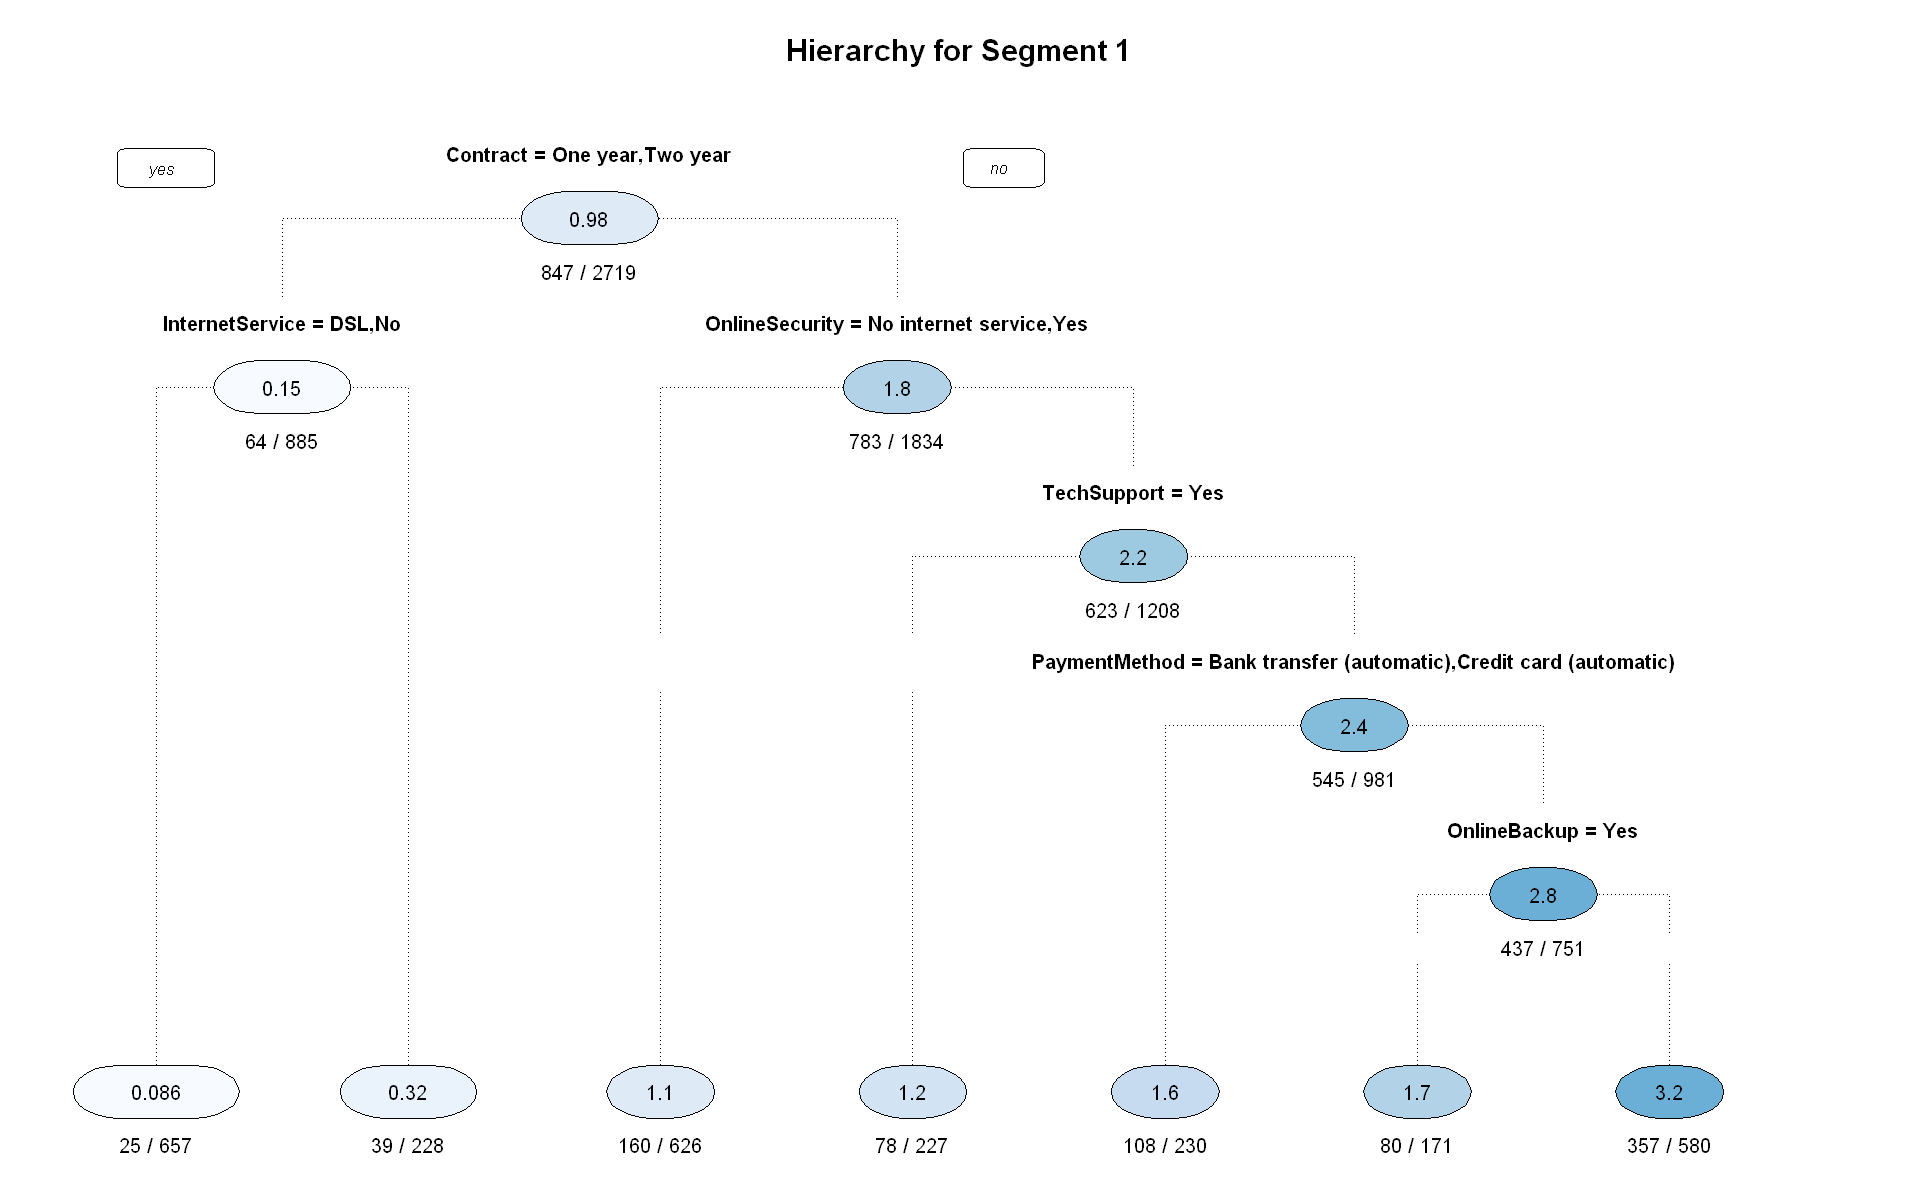

In [33]:
data = seg1
data['start'] = 0
Tree1 = Survival_Tree(data)
rpart.plot(Tree1, roundint=FALSE, type = 1, branch.lty = 3, box.palette = "Blues", cex=1, cex.main = 1.5,
           main = 'Hierarchy for Segment 1', under=TRUE, under.cex=1, clip.right.labs = TRUE, extra=1)

In [34]:
Tree1$variable.importance

Contract      TechSupport   OnlineSecurity     OnlineBackup 
       694.49890        109.66052         82.02006         67.52579 
 InternetService      StreamingTV DeviceProtection    PaymentMethod 
        64.67607         39.42039         36.99196         36.44614

The key findings for this profile considering the variable importance given by the survival tree are:

- 67% of the customer have monthly contracts and its churn rate is 42.7%, while for the other types of contracts this rate is around 7%. The median survival time for monthly contracts is 7 months, while for annual contracts is 36 months.
- Technical support and online security have similar numbers in terms of customers and churn rate. These services are contracted by approximately 20% of the segment and the churn rate for it is 20%, whereas for those who don't have it the rate rises to 45%. The median survival time for customer who do not have neither technical support nor online security is of 8 months.
- Online backup and device protection are present in approximately 27% of the contracts of this segment and the churn rate for it is by coincidence also 27%, whereas for those who don't have it the rate rises to 45%. The median survival time for customer who do not have any of this services is of 8 months.
- Fiber optic is used by 40% of this segment, and considering only these customer to calculate the churn rate the index is 48%. For DSL customer which represents 35.6% of the dataset have a churn rate of 25%. Despite the churn rate for DSL be smaller than for fiber optic the survival median time is 6 months, whereas for fiber optic it is 10 months. 
- In the case of streaming the churn rate for those who have the service and those who don't is approximately the same and is around 37%.
- The mailed check payment method is used by 29% of customer and it is the category that presents the lower tenure over all the contract categories.  

### b) Segment 2

This segment represents 8% of the customers and its churn rate is 49.2%. 


Rates regression tree:
rpart::rpart(formula = Formula, data = DATA, weights = weights, 
    subset = subset, method = "poisson", control = control)

Variables actually used in tree construction:
[1] Contract        OnlineBackup    PaymentMethod   StreamingMovies

Root node error: 699.9/561 = 1.2476

n= 561 

         CP nsplit rel error  xerror     xstd
1 0.2083174      0   1.00000 1.00289 0.028247
2 0.0462531      1   0.79168 0.79782 0.029467
3 0.0229146      2   0.74543 0.78719 0.029788
4 0.0196671      3   0.72251 0.76347 0.029675
5 0.0145541      4   0.70285 0.75235 0.029396
6 0.0096157      5   0.68829 0.73006 0.029451


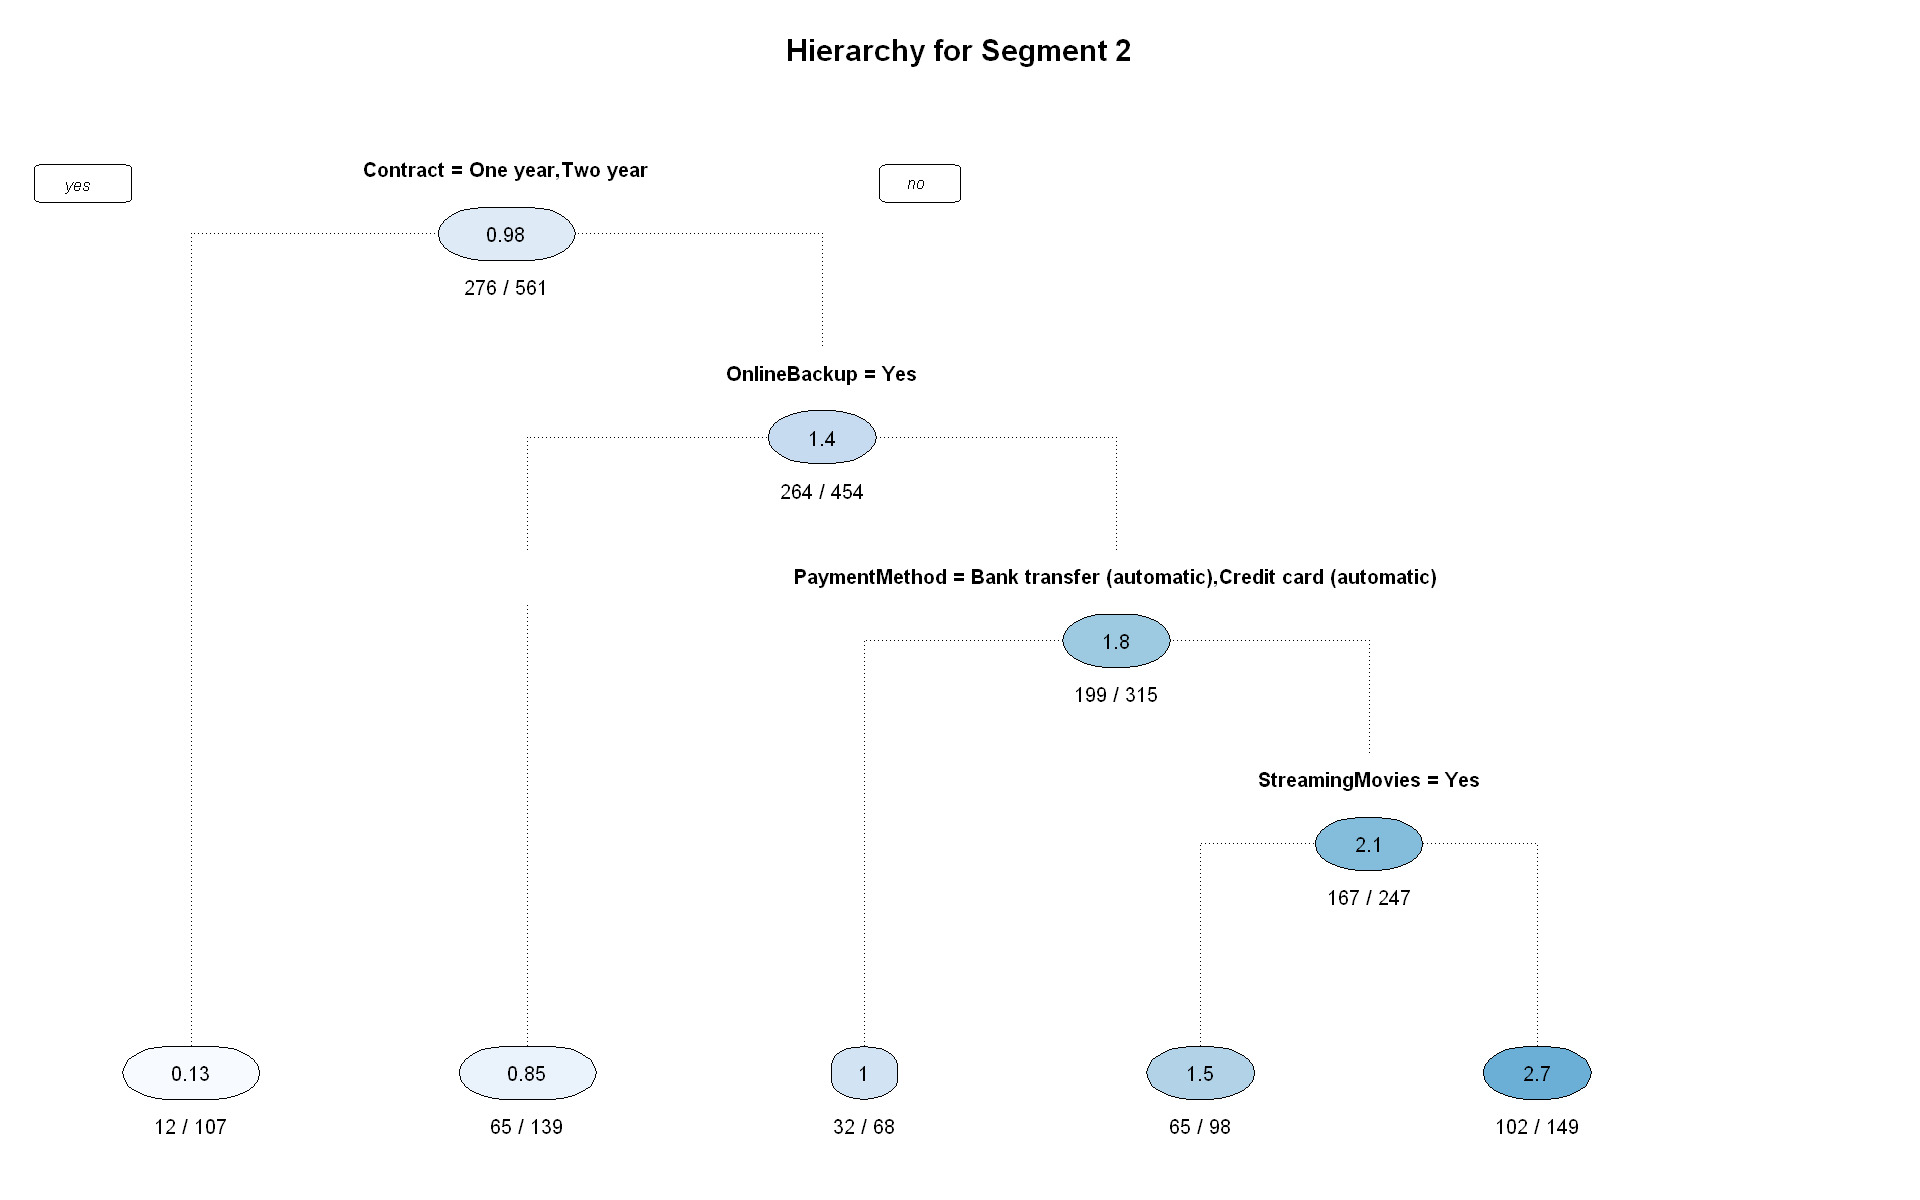

In [35]:
data = seg2
data['start'] = 0
Tree2 = Survival_Tree(data)
rpart.plot(Tree2, roundint=FALSE, type = 1, branch.lty = 3, box.palette = "Blues", cex=1, cex.main = 1.5,
           main = 'Hierarchy for Segment 2', under=TRUE, under.cex=1, clip.right.labs = TRUE, extra=1)

In [36]:
Tree2$variable.importance

Contract     OnlineBackup      TechSupport    PaymentMethod 
     145.8618702       44.6445825       24.1595889       16.0424950 
 StreamingMovies DeviceProtection  InternetService   OnlineSecurity 
      13.7938230       12.5502620       12.2687554       12.2687554 
     StreamingTV    MultipleLines 
       4.6448588        0.1407533

The key findings for this profile considering the variable importance given by the survival tree are:

- 80% of the customer have monthly contracts and its churn rate is 58%, while for the other types of contracts this rate is around 11%. The median survival time for monthly contracts is 13 months, while for annual contracts is approximately 4 years.
- Online backup and device protection are present in approximately 32% of the contracts of this segment and the churn rate for it is around 40%, whereas for those who don't have it the rate rises to 56%. The median survival time for customer who do not have any of this services is of 8 months.
- Technical support and online security have similar numbers in terms of customers and churn rate. These services are contracted by approximately 17% of the segment and the churn rate for it is 28%, whereas for those who don't have it the rate rises to 57%. The median survival time for customer who do not have neither technical support nor online security is of 11 months.
- The electronic check payment method is used by 58% of customer and it is the categoric that presents the lower tenure over all the contract (with median of 7 months) categories with a churn rate of 60%.
- Fiber optic is used by 71% of this segment, and considering only these customer to calculate the churn rate the index is 55%. For DSL customer which represents 23% of the dataset have a churn rate of 38%. Despite the churn rate difference both have survival median time equals 18 months. 
- In the case of streaming the churn rate for those who have the service and those who don't is approximately the same and is around 48%. But it's important to notice that the median survival for those who have streaming is 31 months, and of those who don't only 10 months.

### c) Segment 3

This segment represents 16.5% of the customers and its churn rate is 20.8%. 


Rates regression tree:
rpart::rpart(formula = Formula, data = DATA, weights = weights, 
    subset = subset, method = "poisson", control = control)

Variables actually used in tree construction:
[1] Contract      OnlineBackup  PaymentMethod

Root node error: 1118.5/1163 = 0.96172

n= 1163 

         CP nsplit rel error  xerror     xstd
1 0.2654654      0   1.00000 1.00190 0.037866
2 0.0346091      1   0.73453 0.73701 0.030027
3 0.0207059      2   0.69993 0.71533 0.029842
4 0.0124616      3   0.67922 0.69414 0.029213
5 0.0085267      4   0.66676 0.69182 0.030035


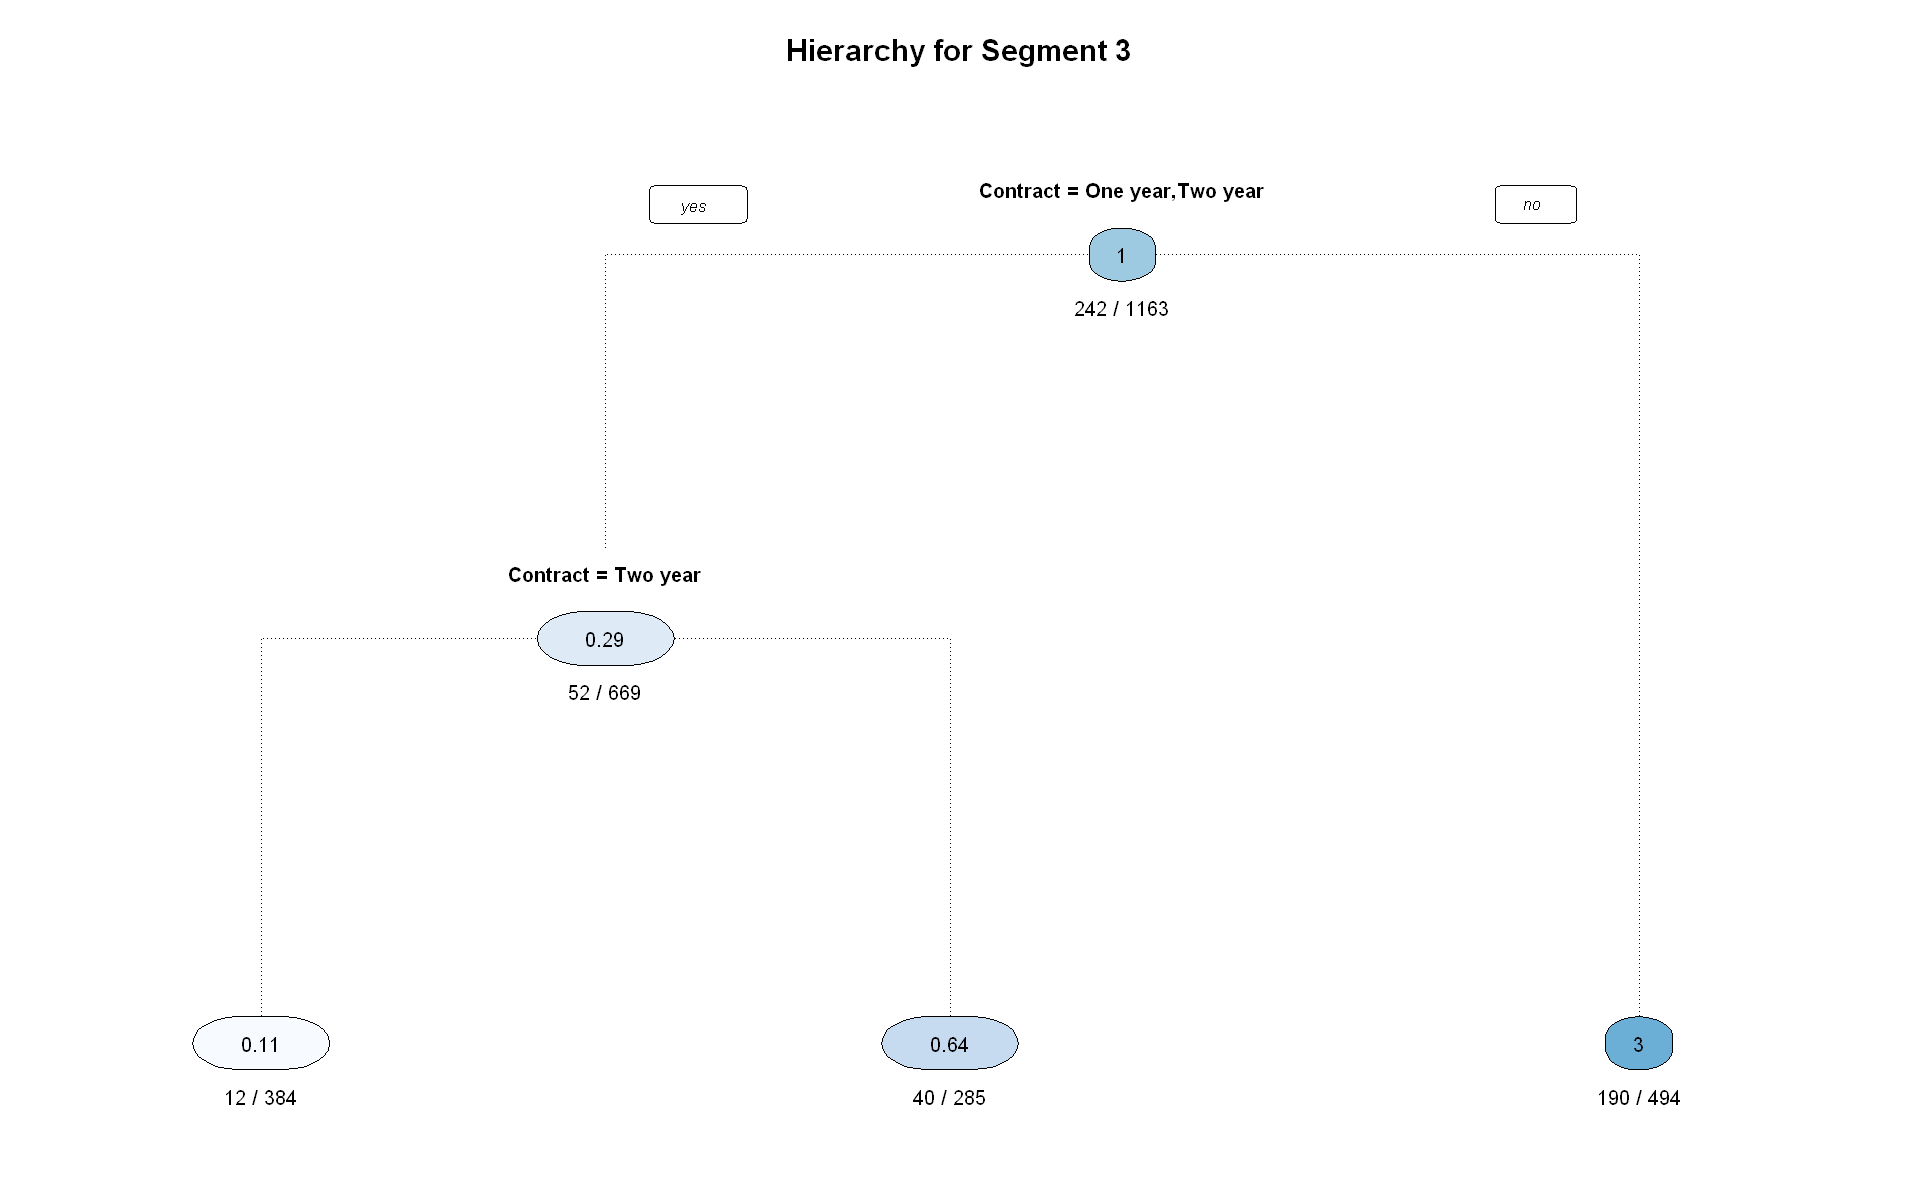

In [37]:
data = seg3
data['start'] = 0
Tree3 = Survival_Tree(data)
rpart.plot(Tree3, roundint=FALSE, type = 1, branch.lty = 3, box.palette = "Blues", cex=1, cex.main = 1.5,
           main = 'Hierarchy for Segment 3', under=TRUE, under.cex=1, clip.right.labs = TRUE, extra=1)

In [38]:
Tree3$variable.importance

Contract      TechSupport   OnlineSecurity DeviceProtection 
      335.715580       106.528682        88.894498        83.234414 
    OnlineBackup  StreamingMovies    PaymentMethod 
       76.973218        68.526796         3.400538

According the pruning criterion the only variable select to build the tree was contract. 42% of the customer have monthly contracts and its churn rate is 38%, while for the other types of contracts this rate is around 7%. The median survival time for monthly contracts is 8 months, while for annual contracts is approximately 4 years.

### d) Segment 4

This segment represents 23.7% of the customers and its churn rate is 13.7%. 


Rates regression tree:
rpart::rpart(formula = Formula, data = DATA, weights = weights, 
    subset = subset, method = "poisson", control = control)

Variables actually used in tree construction:
[1] Contract         DeviceProtection InternetService  OnlineBackup    
[5] OnlineSecurity   PaymentMethod    StreamingMovies 

Root node error: 1232.8/1657 = 0.74399

n= 1657 

         CP nsplit rel error  xerror     xstd
1 0.2736891      0   1.00000 1.00214 0.041646
2 0.0338894      1   0.72631 0.72914 0.033012
3 0.0188826      2   0.69242 0.69707 0.030814
4 0.0111009      3   0.67354 0.69114 0.031307
5 0.0110522      4   0.66244 0.70299 0.033164
6 0.0080776      5   0.65139 0.69410 0.032746
7 0.0063256      6   0.64331 0.68726 0.032667
8 0.0054640      7   0.63698 0.68949 0.033246
9 0.0043995      8   0.63152 0.68568 0.033187


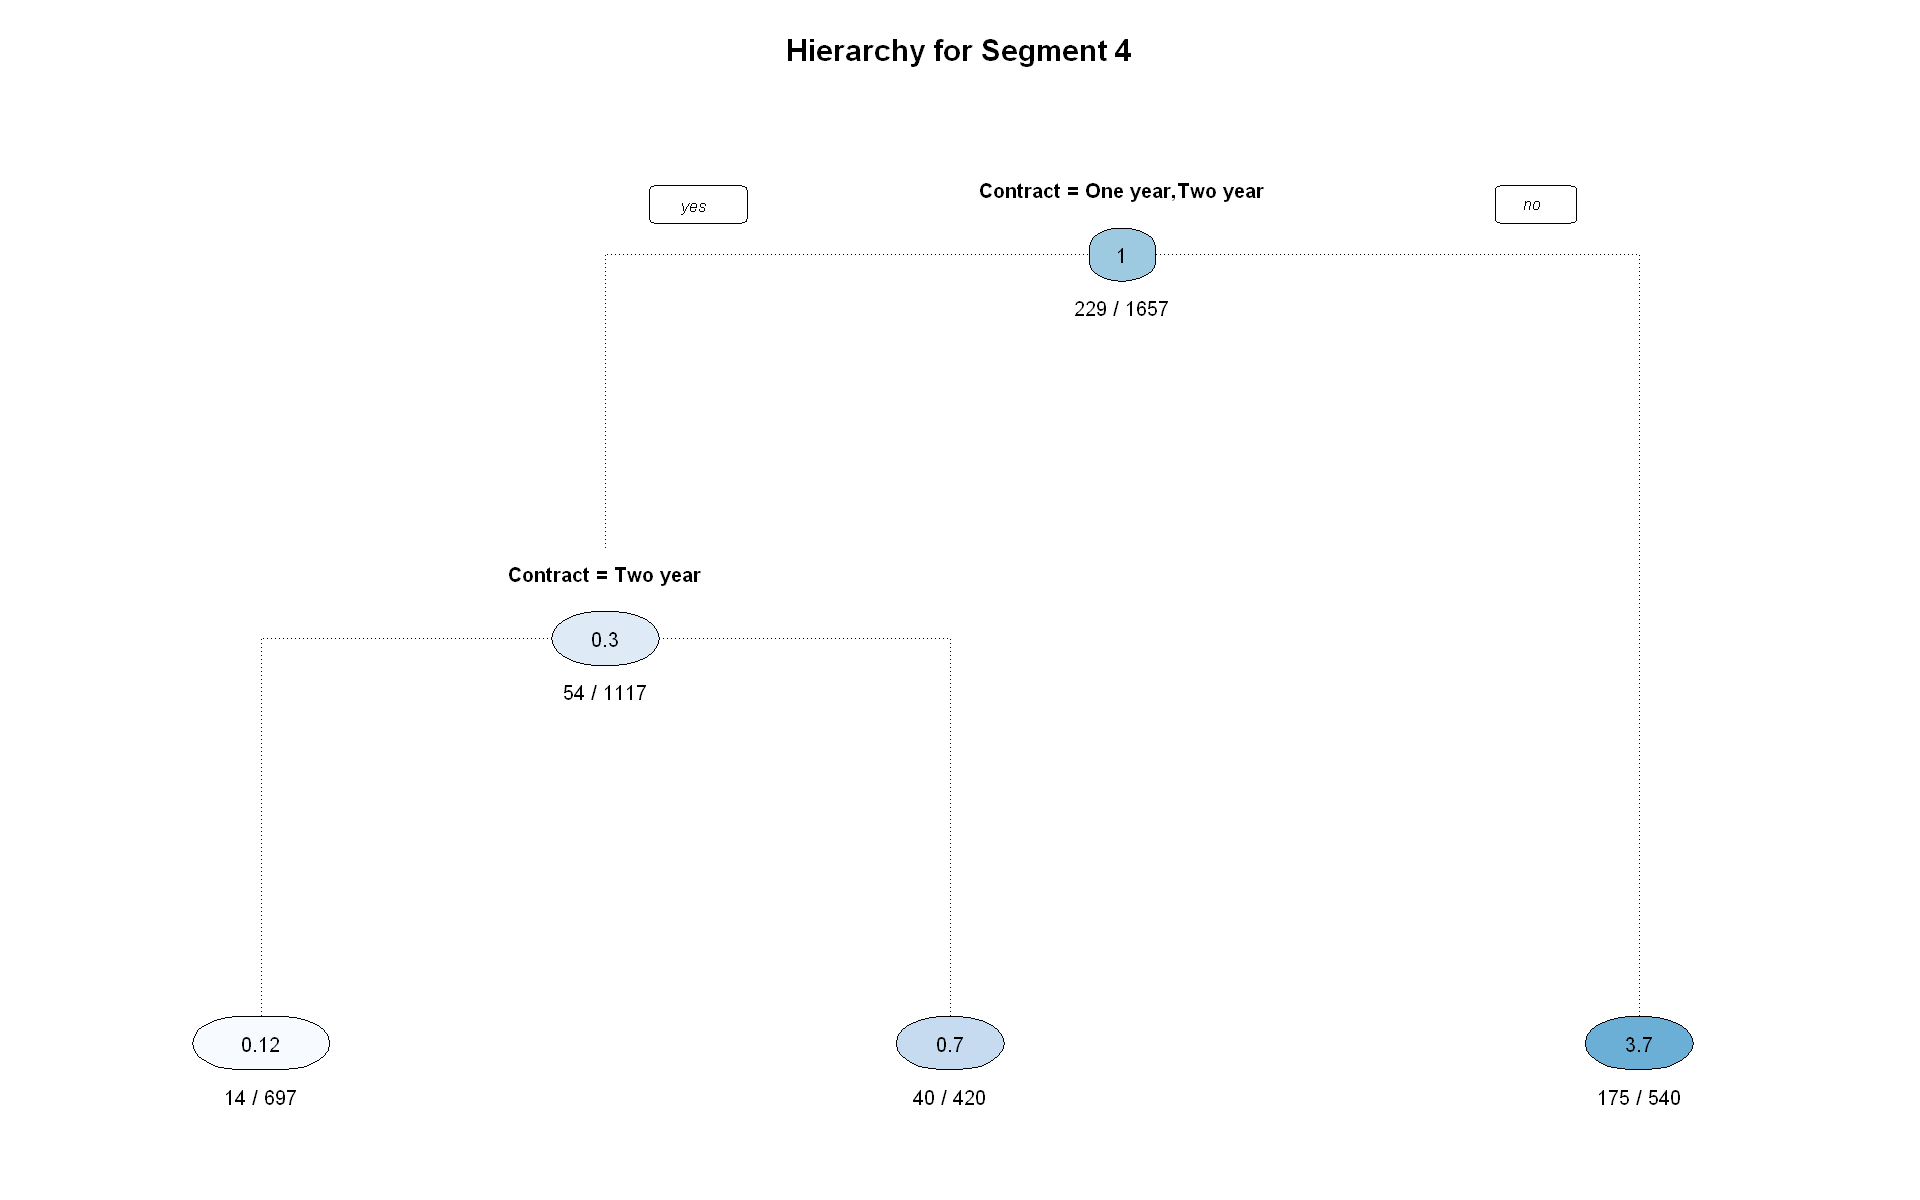

In [39]:
data = seg4[seg4$tenure>0,]
data['start'] = 0
Tree4 = Survival_Tree(data)
rpart.plot(Tree4, roundint=FALSE, type = 1, branch.lty = 3, box.palette = "Blues", cex=1, cex.main = 1.5,
           main = 'Hierarchy for Segment 4', under=TRUE, under.cex=1, clip.right.labs = TRUE, extra=1)

In [40]:
Tree4$variable.importance

Contract      TechSupport    PaymentMethod DeviceProtection 
      379.280621        60.487184        59.401842        57.228339 
  OnlineSecurity  StreamingMovies      StreamingTV 
       52.998252        21.247197         2.091257

According the pruning criterion the only variable select to build the tree was contract. 80% of the customer have monthly contracts and its churn rate is 58%, while for the other types of contracts this rate is around 11%. The median survival time for monthly contracts is 17 months, while for annual contracts is 3.5 years.

### e) Overall Varible Importance

Once we assessed the variable importance for all the segments we will create a ranking to help decide the overall criterion.

In [41]:
COLUMN_NAMES = c('Tree','PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 
                'PaperlessBilling', 'PaymentMethod')
all_parameters = data.frame(matrix(ncol=13,nrow=0, dimnames=list(NULL, COLUMN_NAMES)))

In [42]:
build_ranking <- function(all_parameters, df, id) {
    
    # This function matches all the variable importance with the list of features of the churn dataset 
    # and add this to a dataframe
    transf = FALSE # indicates if we need to transform the data type to avoid errors
    ranking = list()
    for(i in seq(length(COLUMN_NAMES))){
        if (COLUMN_NAMES[i] == 'Tree') {
            ranking = cbind(id)}
        else {
            if (COLUMN_NAMES[i] %in% colnames(df)){
                ranking = cbind(ranking, 100*df[COLUMN_NAMES[i]]/sum(df))
            }
            else {
                ranking = cbind(ranking, 0)
                transf = TRUE
                 }
           }
        }
    ranking = as.data.frame(ranking)
    colnames(ranking) <- COLUMN_NAMES
    all_parameters = rbind(all_parameters, ranking)
    if (transf == TRUE) {
        colnames(all_parameters) <- COLUMN_NAMES
        all_parameters = all_parameters %>% mutate(PhoneService = as.numeric(as.character(PhoneService)),
                                  MultipleLines = as.numeric(as.character(MultipleLines)),
                                  InternetService = as.numeric(as.character(InternetService)),
                                  OnlineSecurity = as.numeric(as.character(OnlineSecurity)),
                                  OnlineBackup = as.numeric(as.character(OnlineBackup)),
                                  DeviceProtection = as.numeric(as.character(DeviceProtection)),
                                  TechSupport = as.numeric(as.character(TechSupport)),
                                  StreamingTV = as.numeric(as.character(StreamingTV)),
                                  StreamingMovies = as.numeric(as.character(StreamingMovies)),
                                  Contract = as.numeric(as.character(Contract)),
                                  PaperlessBilling = as.numeric(as.character(PaperlessBilling)),
                                  PaymentMethod = as.numeric(as.character(PaymentMethod))
                                  )        
    }
    return (all_parameters)
    }

In [43]:
all_parameters = build_ranking(all_parameters, as.data.frame(as.list(Tree1$variable.importance)), 'Segment 1')
all_parameters = build_ranking(all_parameters, as.data.frame(as.list(Tree2$variable.importance)), 'Segment 2')
all_parameters = build_ranking(all_parameters, as.data.frame(as.list(Tree3$variable.importance)), 'Segment 3')
all_parameters = build_ranking(all_parameters, as.data.frame(as.list(Tree4$variable.importance)), 'Segment 4')

In [44]:
rownames(all_parameters) = all_parameters[,1]
all_parameters[,c(1,2,12)] <- NULL

In [45]:
plot_radar <- function(data) {
    
    data <- rbind(rep(ceiling(max(data)),12) , rep(0,12) , data)

    colors_border= c( 'blue', 'green' , 'orange', 'pink')

    # plot with default options:
    radarchart( data, title = 'Ranking of Variables Influencing Churn Rate',
    #custom polygon
    pcol=colors_border , plwd=4 , plty=1,
    #custom the grid
    cglcol="grey", cglty=1, axislabcol="grey", caxislabels=seq(0,20,5), cglwd=0.8,
    #custom labels
    vlcex=1)

# Add a legend
legend(x=1.5, y=1, legend = rownames(data[-c(1,2),]), bty = "n", 
       col=colors_border, text.col = "black", cex=1, pt.cex=3, lwd=4)
    
}

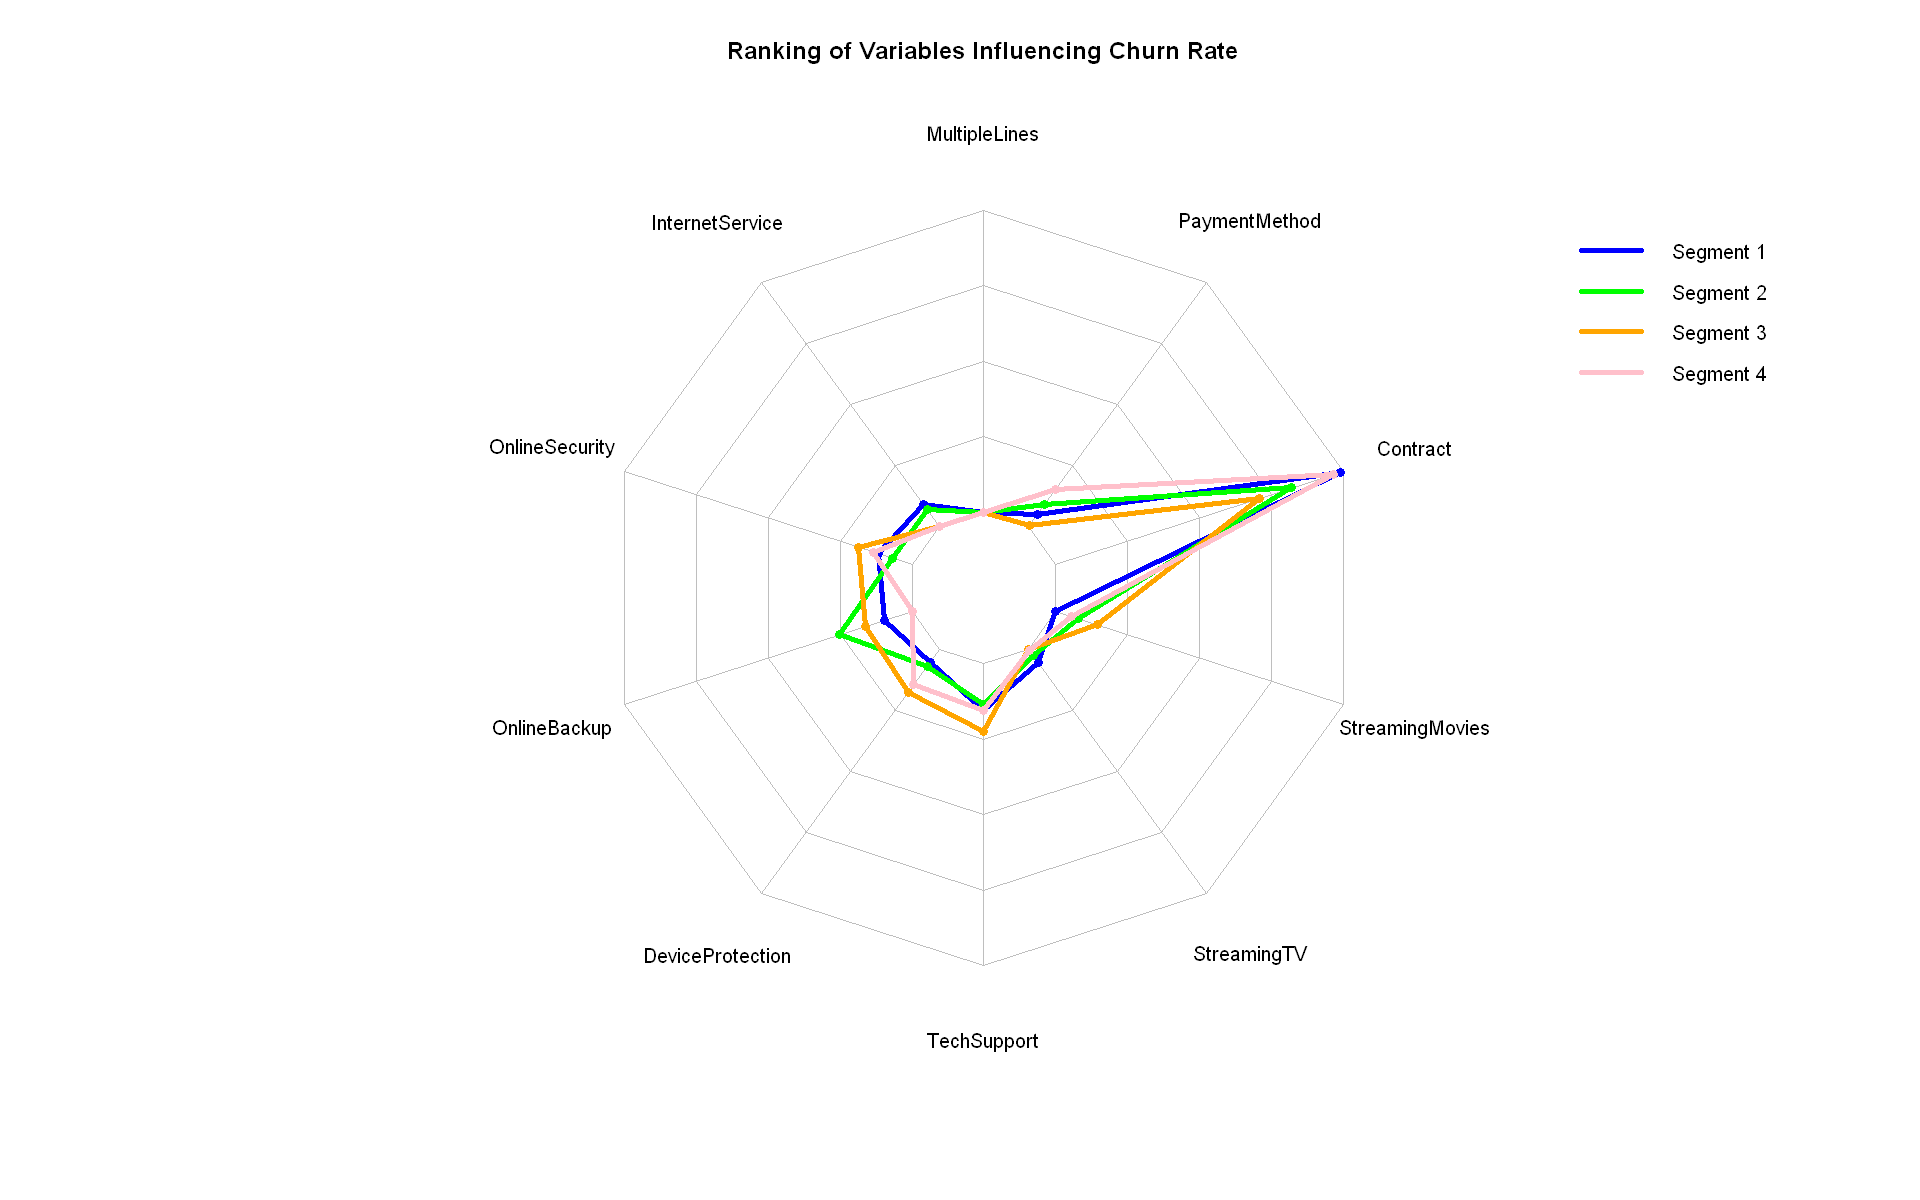

In [46]:
plot_radar(all_parameters)

For all segments contract type is the most important variable when determining the survival time. For the variables that appear on the ranking let's check the overall mean survival time.

## Restricted Mean Survival Time (RMST)

Considering that the proportional hazards assumption does not hold on our case we are going to use the RMST to assess the critical variables in terms of tenure. First we are going to divide the customers into two types:
- With Internet Services
- Only Phone Services

In [107]:
churn_seg = rbind(seg1, seg2, seg3, seg4)

In [108]:
plot_RMST <- function(data, interval=24) {
    plot(rmst2(data$tenure, data$event, data$grp, tau=interval), xlab="Years", ylab="Probability")
    }

### a) Customers with Internet Services

78% of the customers have internet services, from wich 43% use DSL and the others fiber optic.

In [156]:
churn_internet = churn_seg[which(churn_seg$InternetService!='No'),]

##### a.1) Contract Type
Considering the result of the RMST we see that the churn rate for monthly contracts is much faster than for other types of contract, and in the interval of one year the company loses 30% of the customers of this category. The mean survival time in this interval for monthly contract is almost 7 months smaller than for the other types.

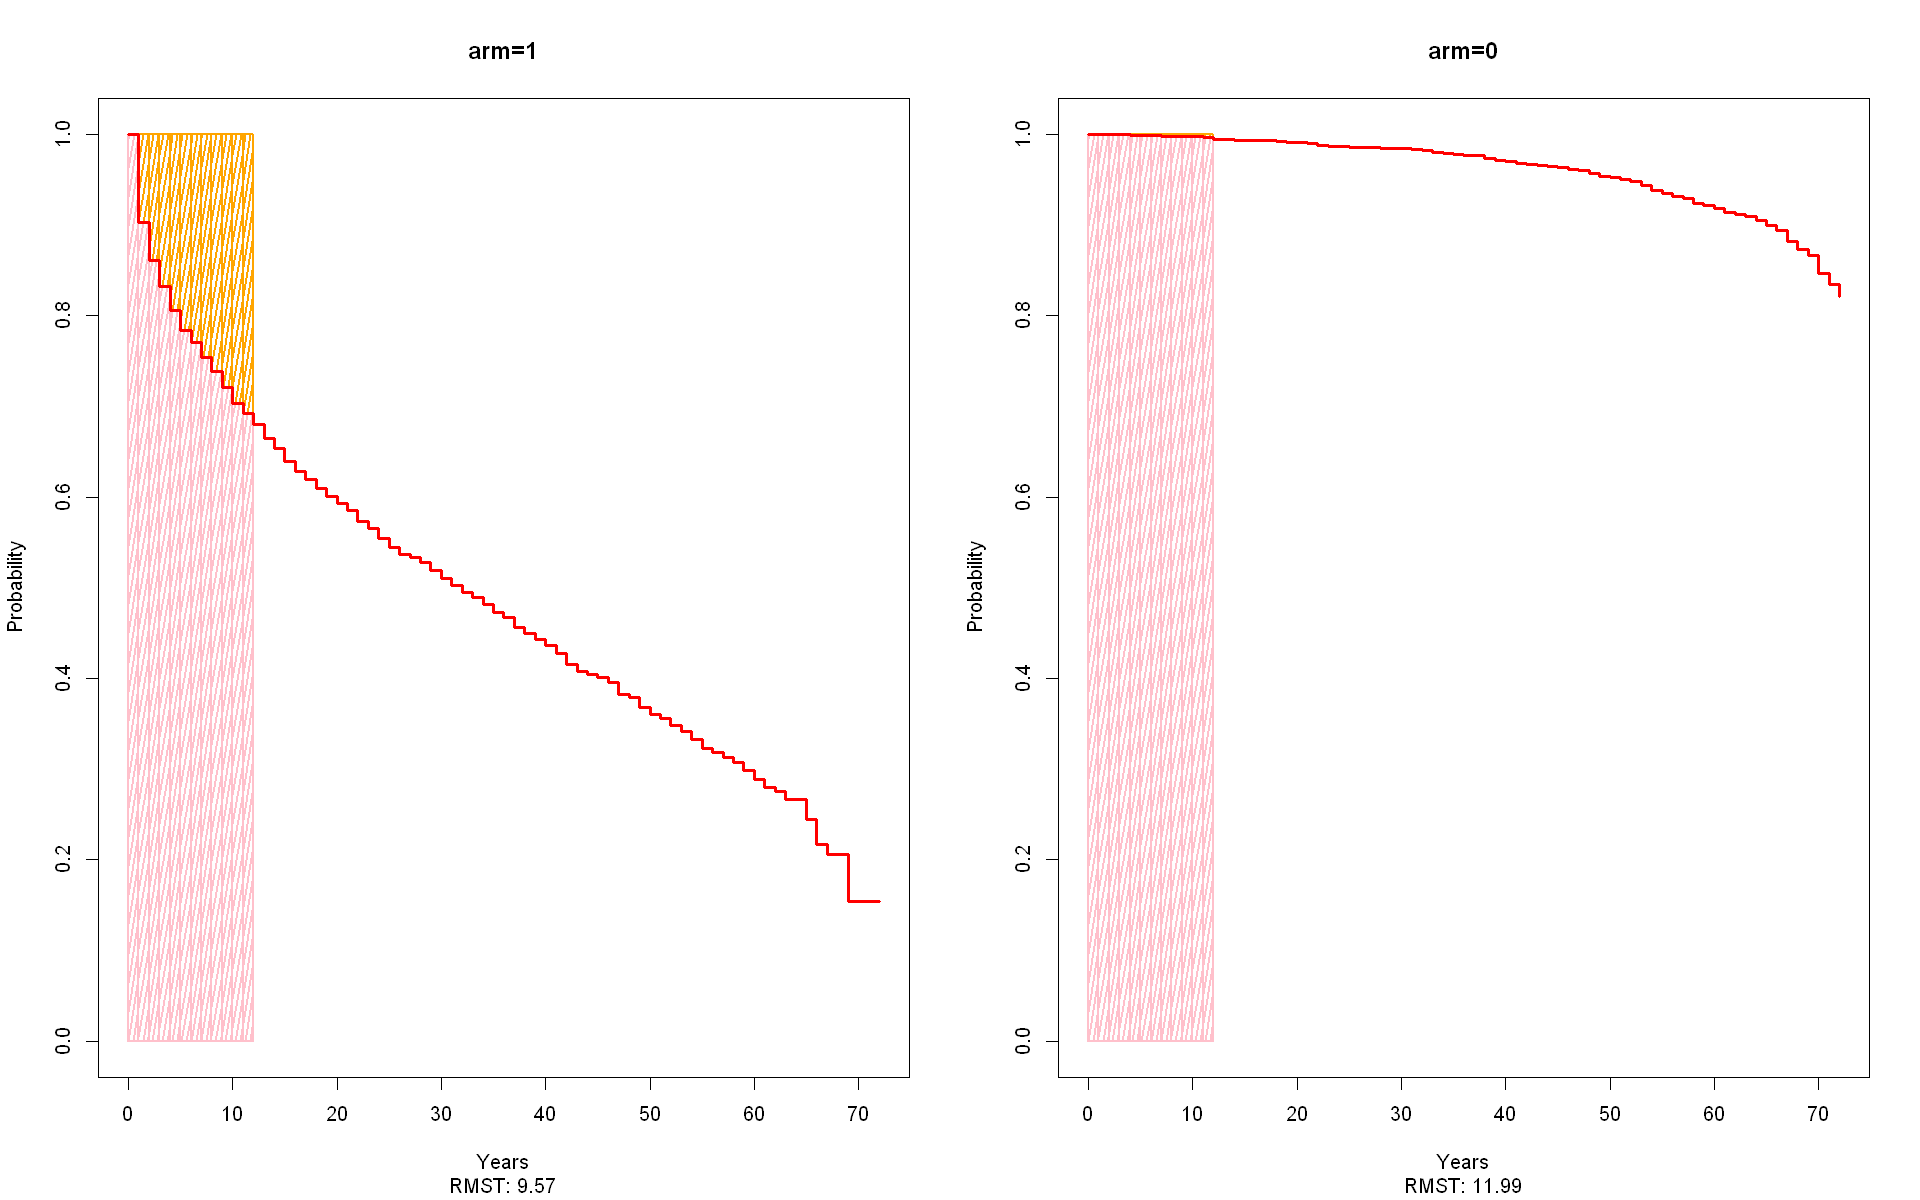

In [159]:
churn_ctr = churn_internet %>% mutate(grp = as.factor(ifelse(Contract=='Month-to-month','1','0')))
plot_RMST(churn_ctr, 12)

##### a.2) Internet Service Technologoy
The DSL survival curve has a churn of 10% on the first year, what reprents half of the churn for fiber optic customers. One factor that can impact on this rate is the customer perception of the service quality, so let's study if technical support has direct interference on survival. 

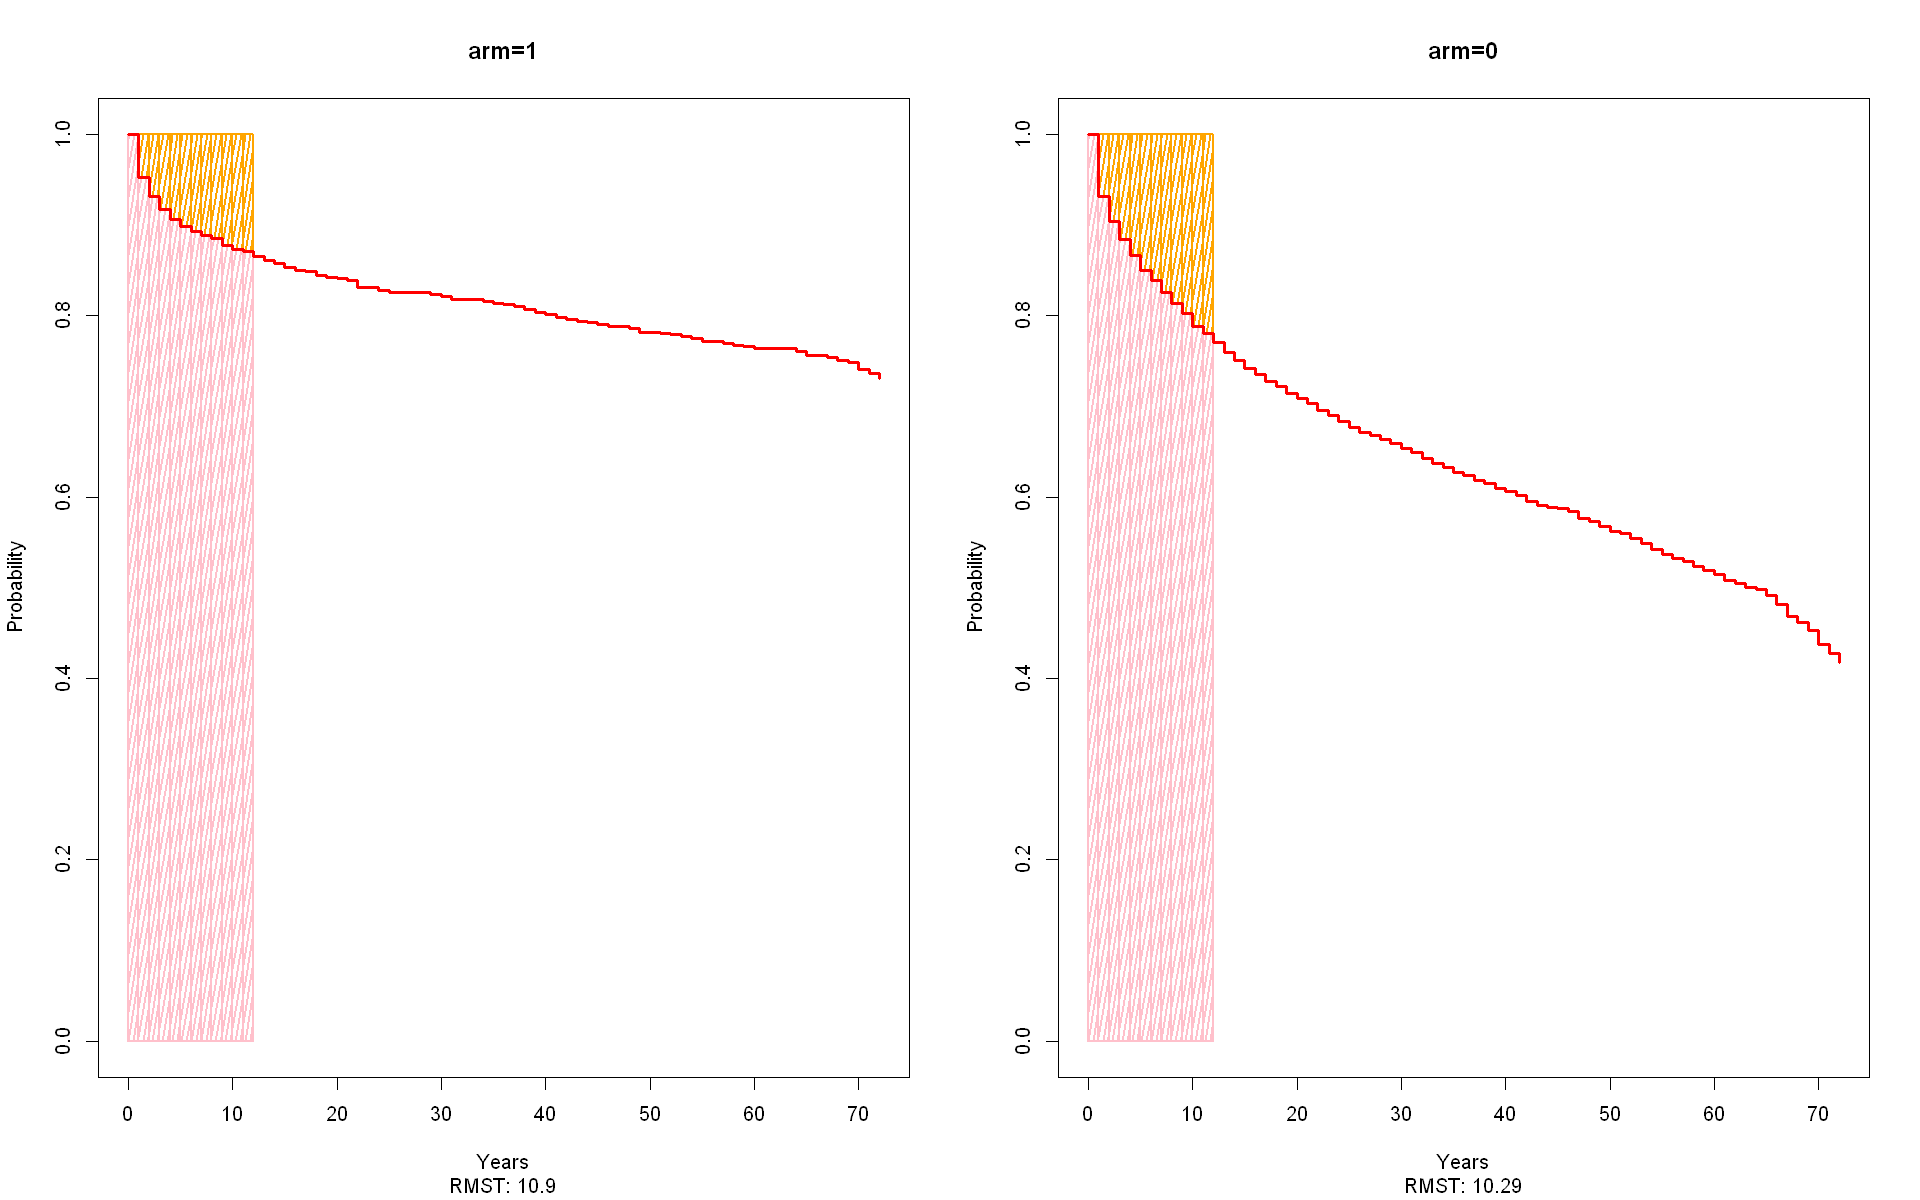

In [153]:
churn_DSL = churn_internet %>% mutate(grp = as.factor(ifelse(InternetService=='DSL','1','0')))
plot_RMST(churn_DSL,12)

##### a.3) Technical Support
The technical support demonstrates to play an important role in customer retention, on the first year the company looses almost 30% of customers who don't have contracted this service, what means 6 times more than compared to those who have it. 

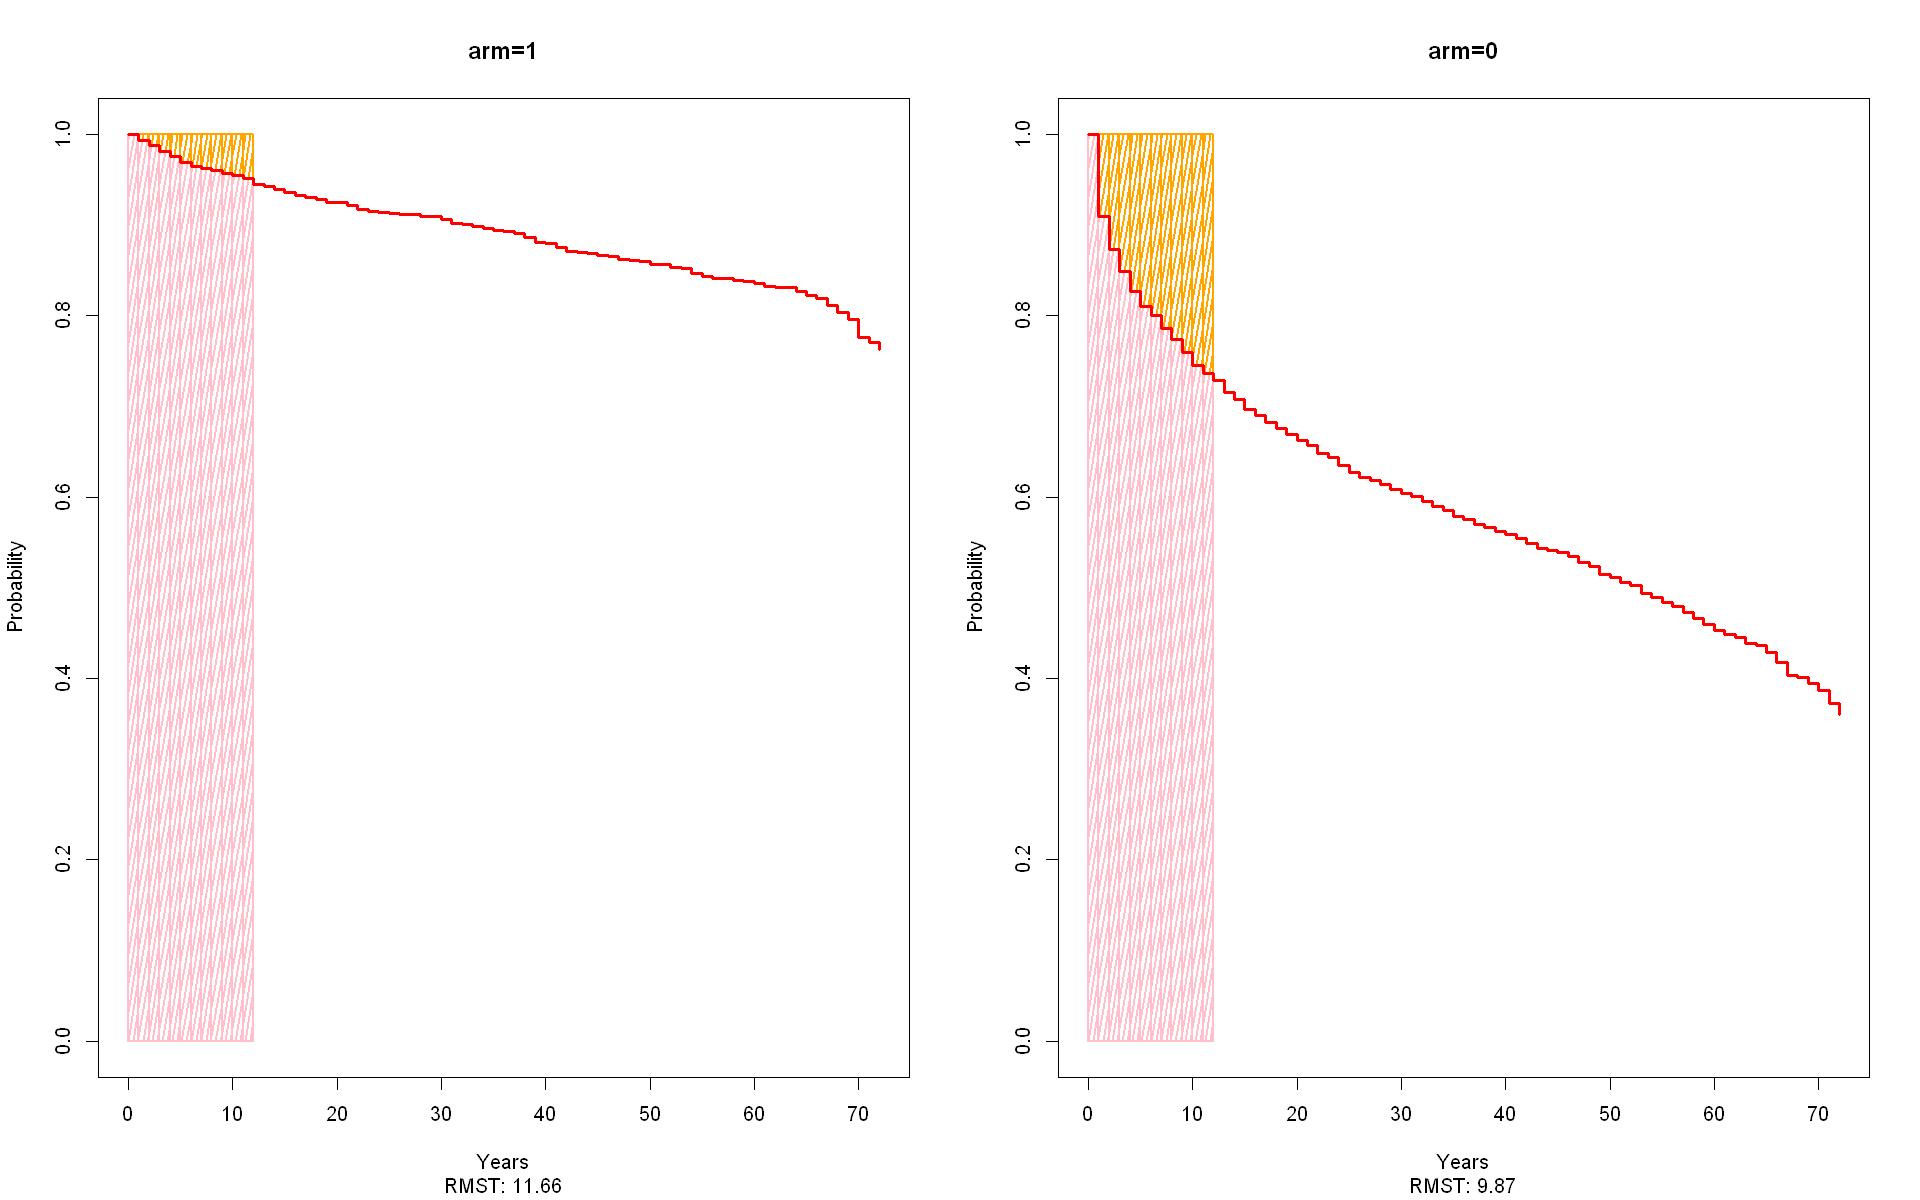

In [175]:
churn_tech = churn_internet %>% mutate(grp = as.factor(ifelse(TechSupport=='Yes','1','0')))
plot_RMST(churn_tech,12)

##### a.4) Device Protection
It has a similarity with the survival for techical support, considering that while customer with technical support present a churn of 5% in the first year, customers with device protection present around 10% of churn.

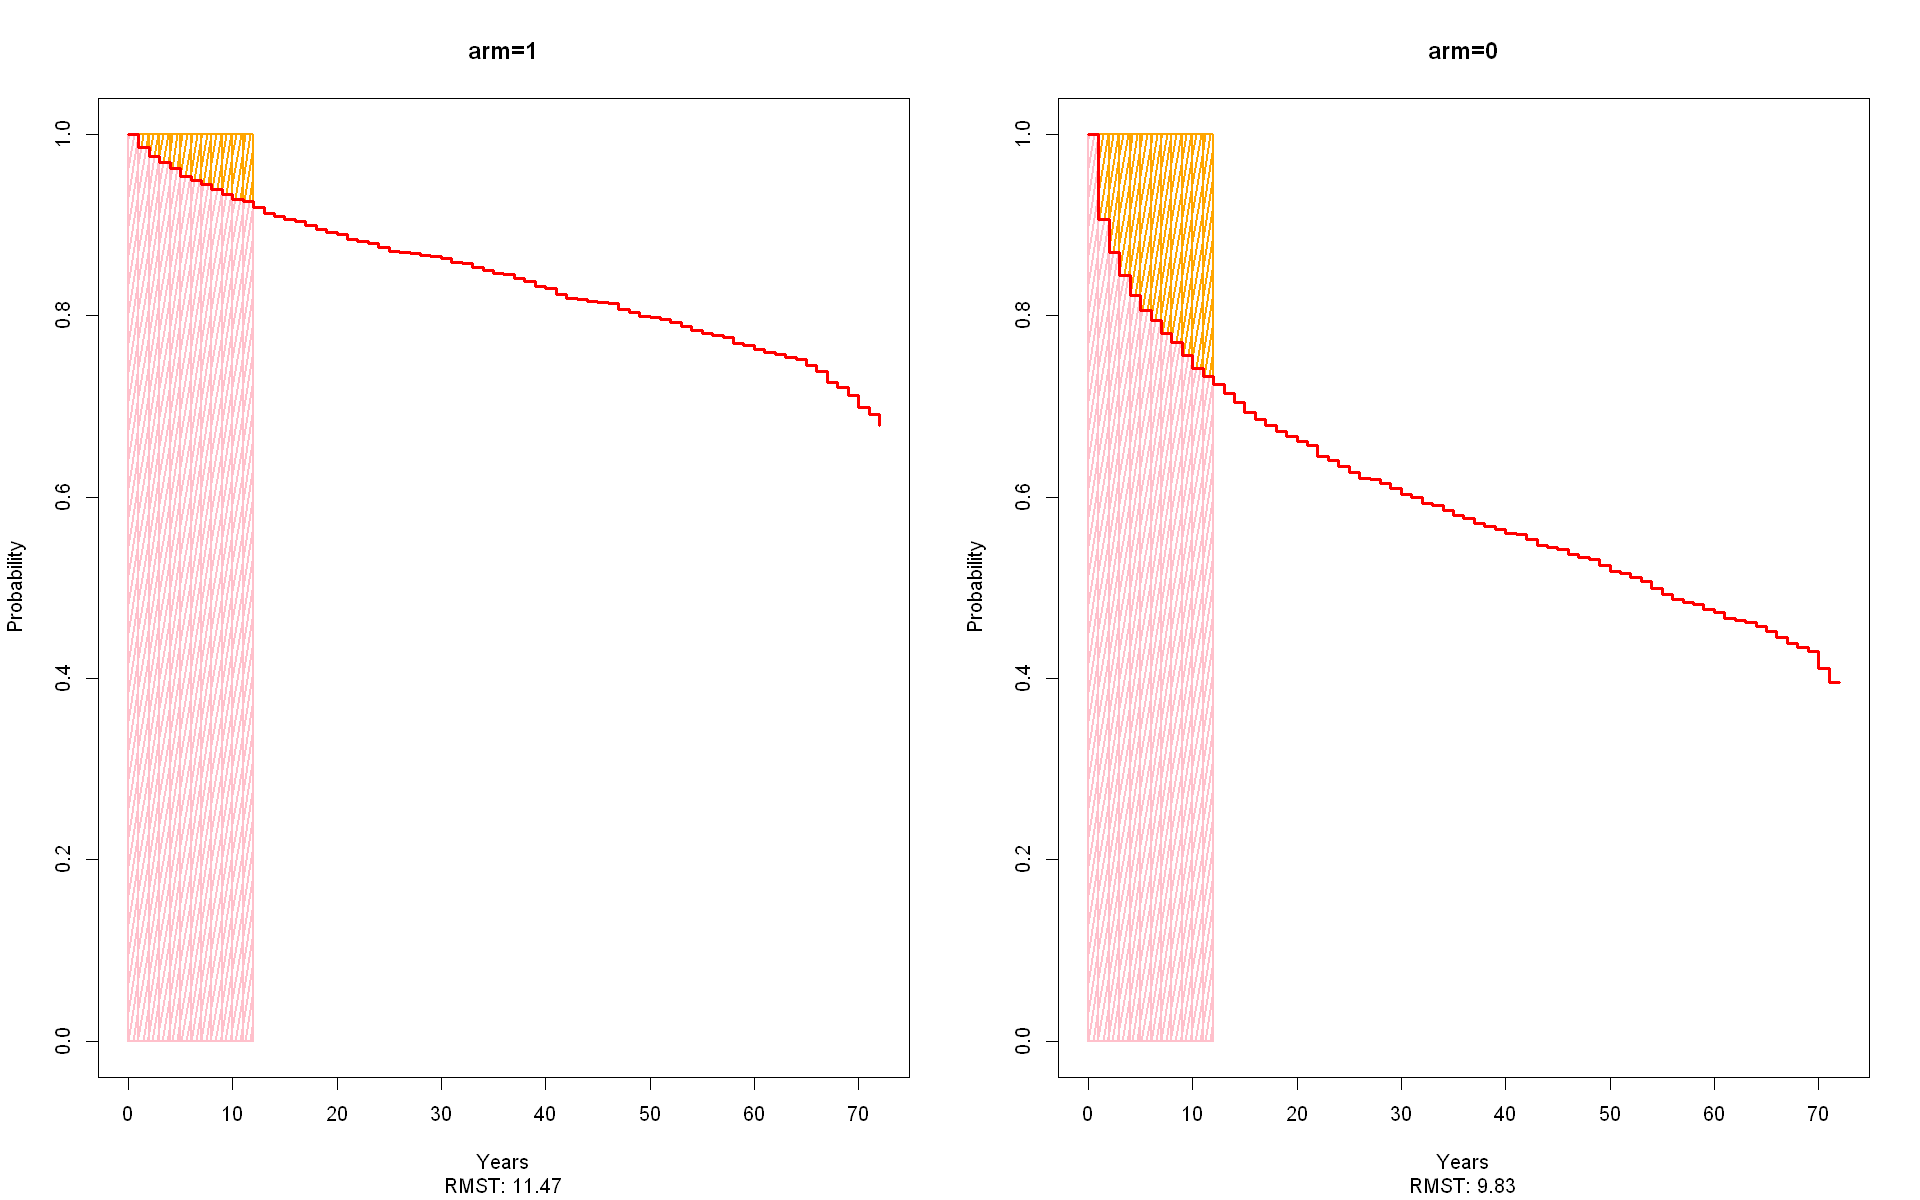

In [190]:
churn_dev = churn_internet %>% mutate(grp = as.factor(ifelse(DeviceProtection=='Yes','1','0')))
plot_RMST(churn_dev,12)

##### a.5) Online Backup
The survival curves for online backup and device protection are almost identical.

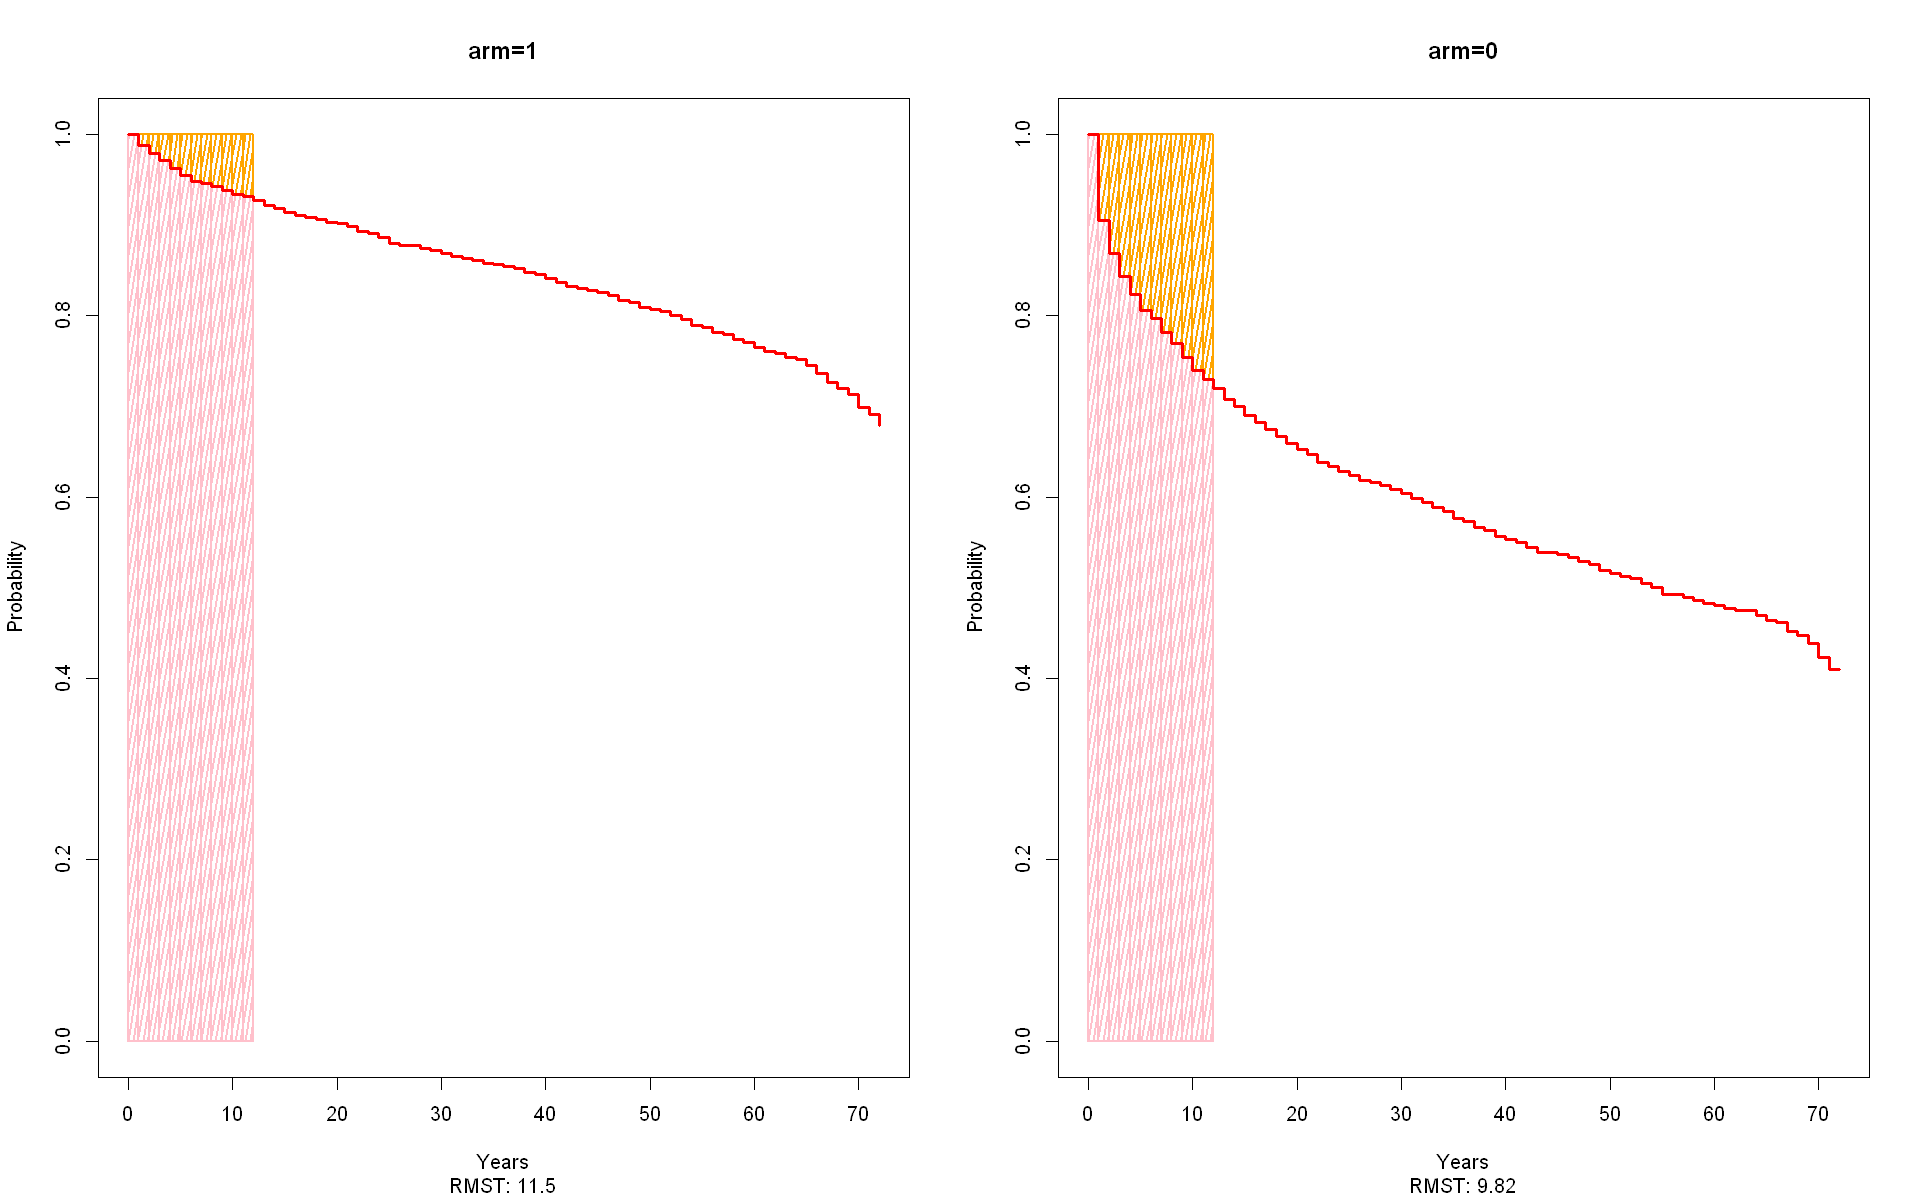

In [191]:
churn_bak = churn_internet %>% mutate(grp = as.factor(ifelse(OnlineBackup=='Yes','1','0')))
plot_RMST(churn_bak,12)

##### a.6) Online Backup
The survival curves for online backup and technical are almost identical.

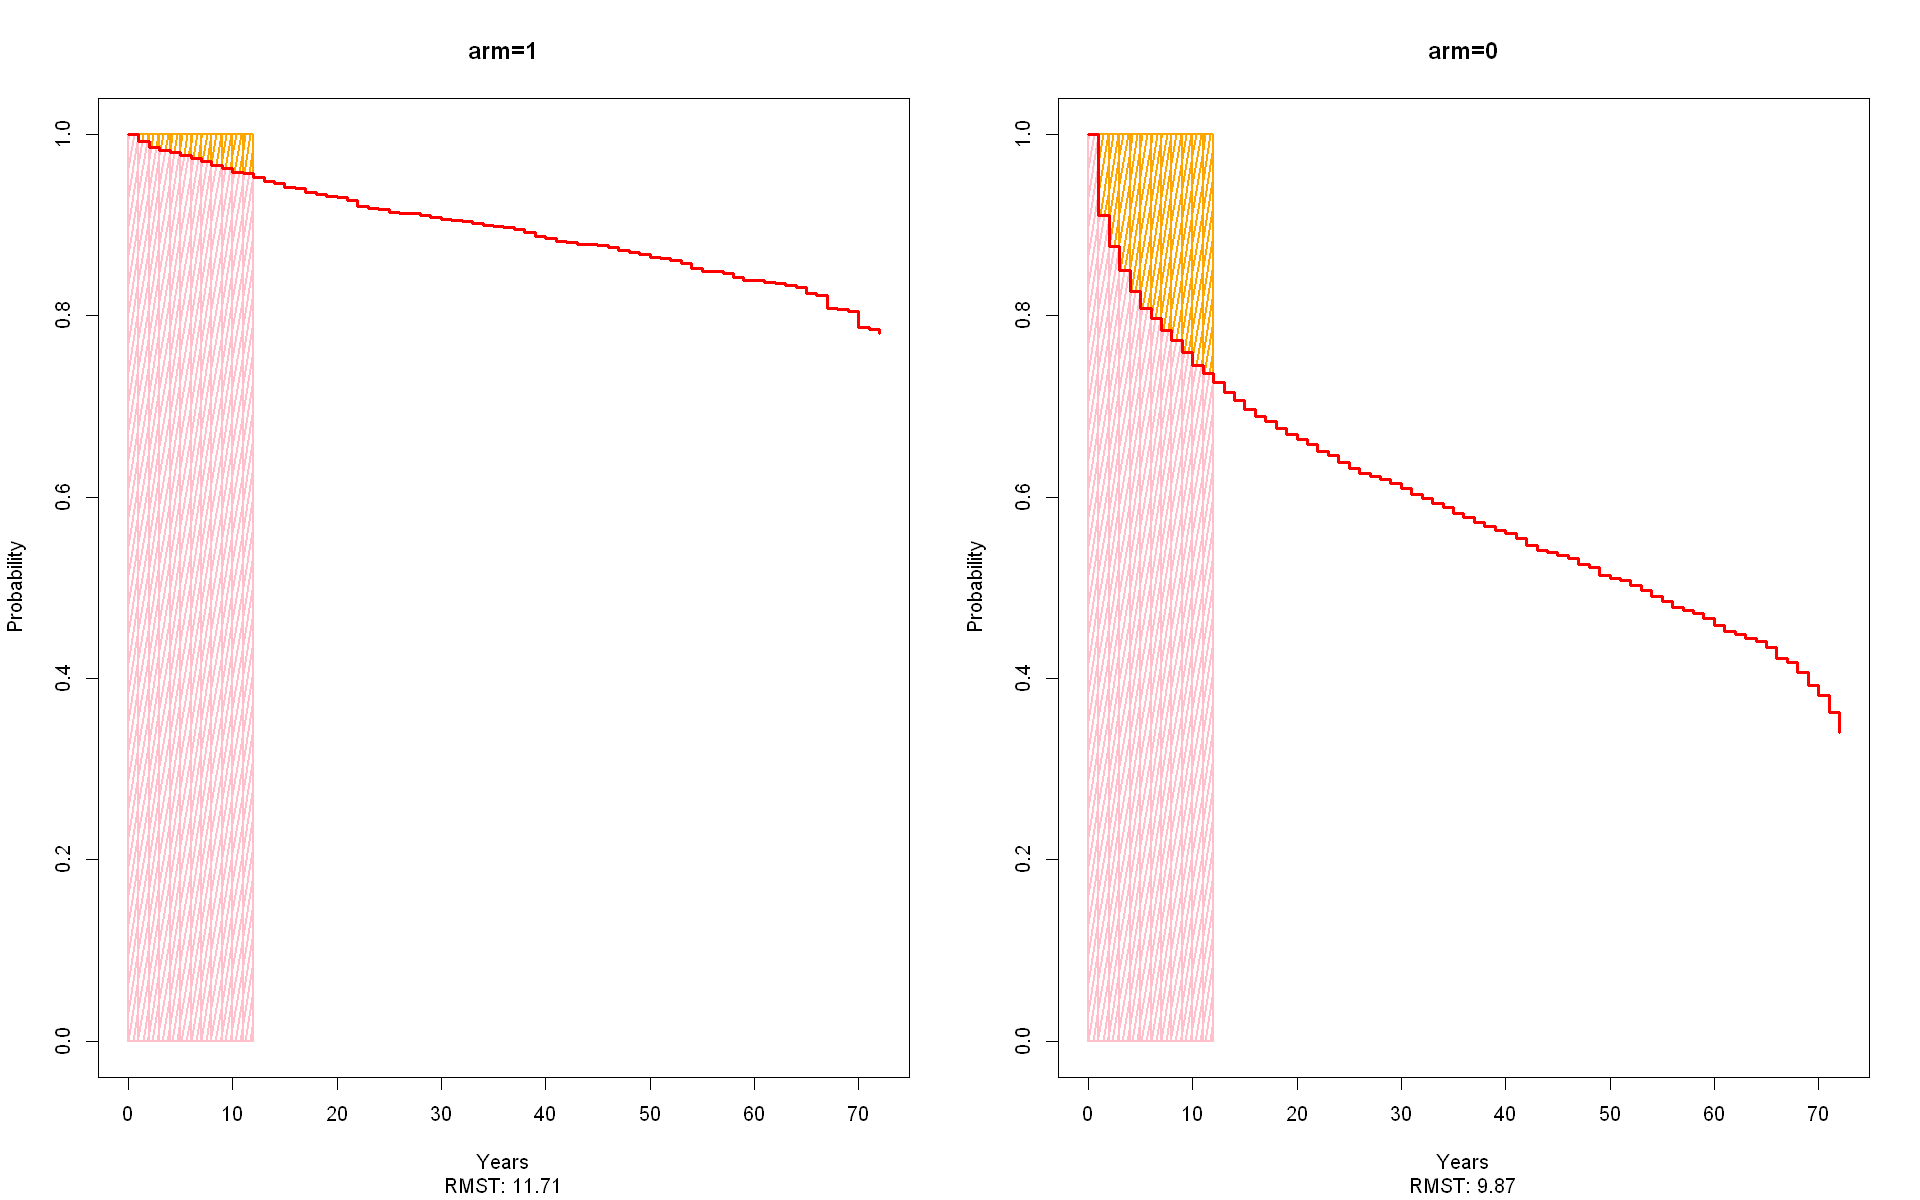

In [192]:
churn_sec = churn_internet %>% mutate(grp = as.factor(ifelse(OnlineSecurity=='Yes','1','0')))
plot_RMST(churn_sec,12)

##### a.7) Streaming TV and Movies
It doesn't matter the type of streaming , TV or Movies, the survival curves are exactly the same. 

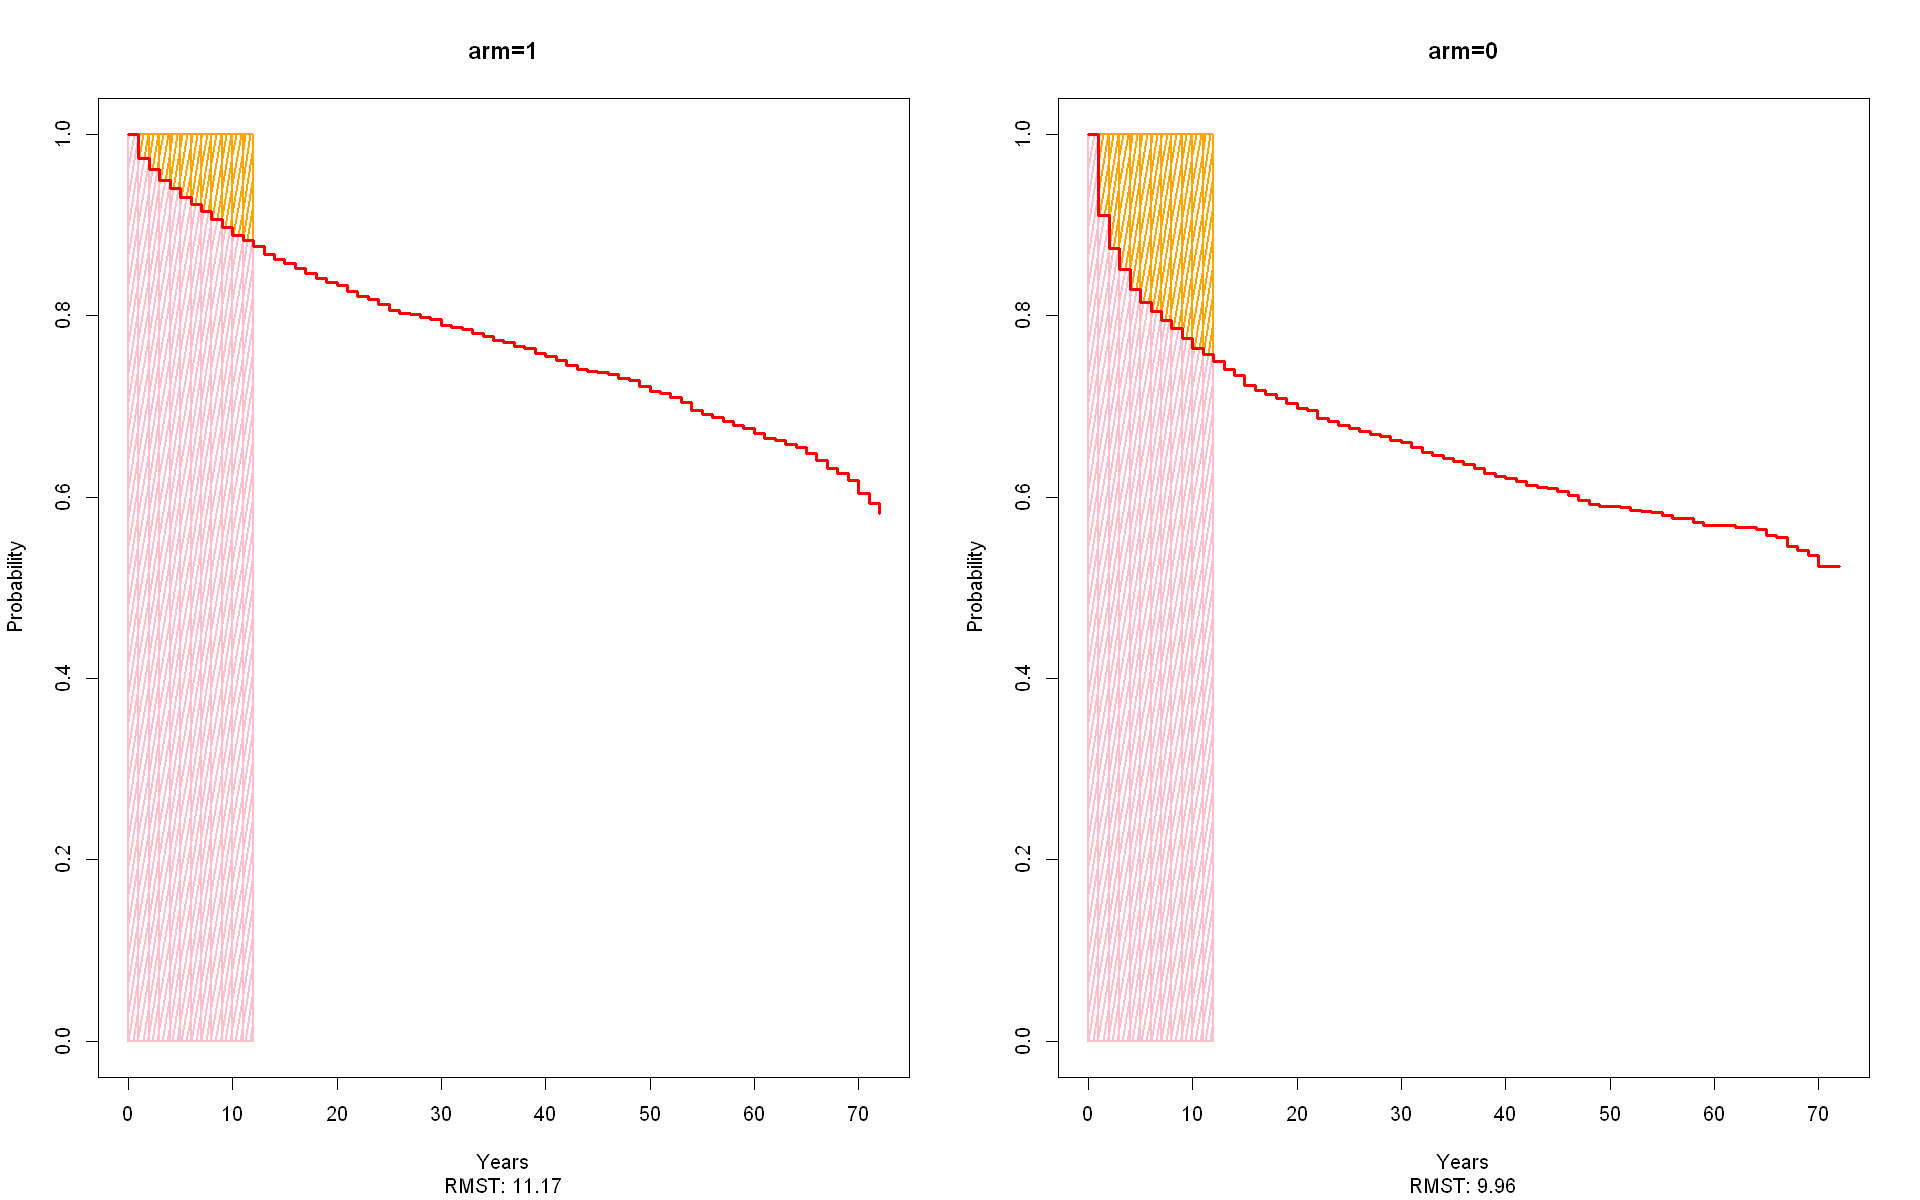

In [179]:
churn_tv = churn_internet %>% mutate(grp = as.factor(ifelse(StreamingTV=='Yes','1','0')))
plot_RMST(churn_tv,12)

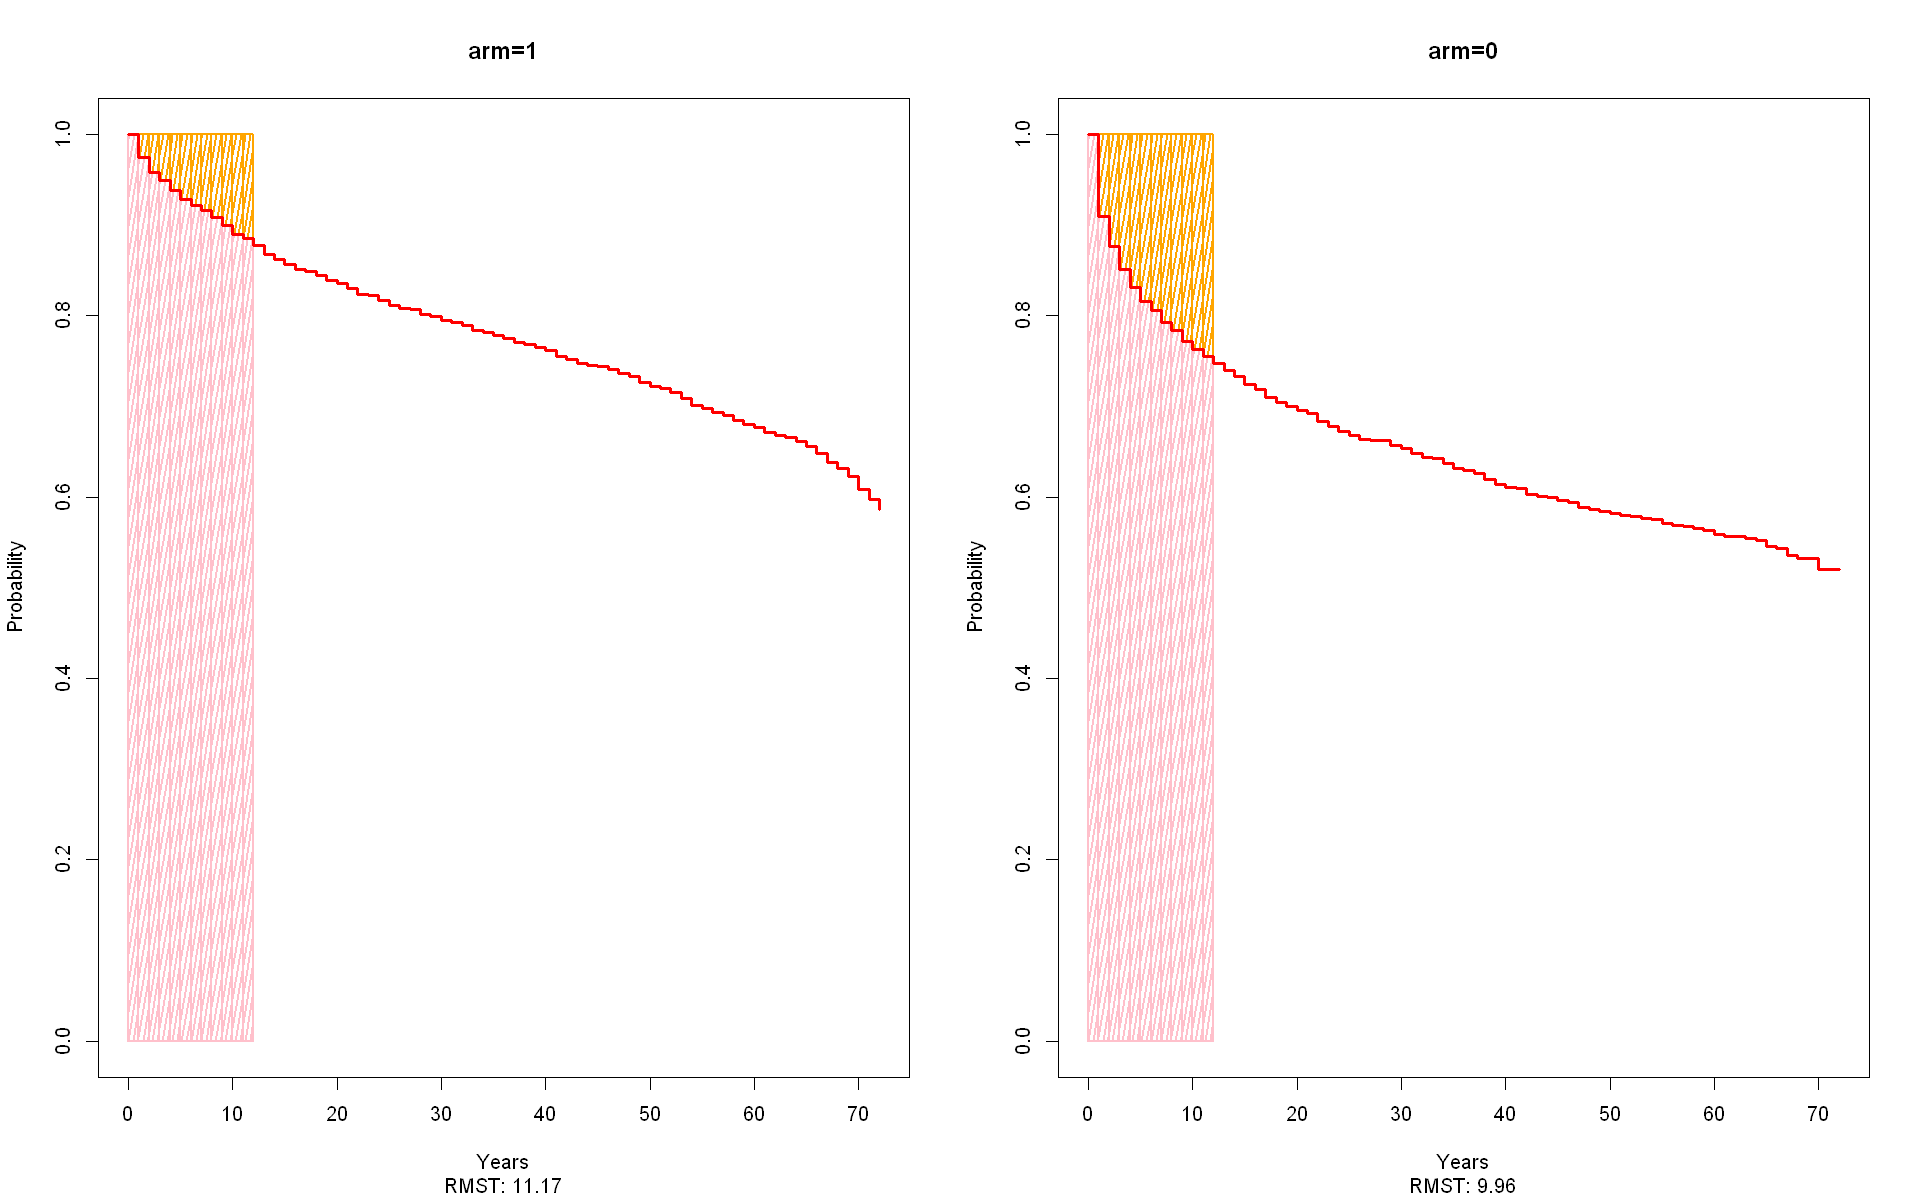

In [180]:
churn_mov = churn_internet %>% mutate(grp = as.factor(ifelse(StreamingMovies=='Yes','1','0')))
plot_RMST(churn_mov,12)

##### a.8) Payment Method
Amongst the payment methods we can check that the automatic categories (credit card and bank transfer) have lower churn rates when compared to the manual ones (electronic and mailed check). 

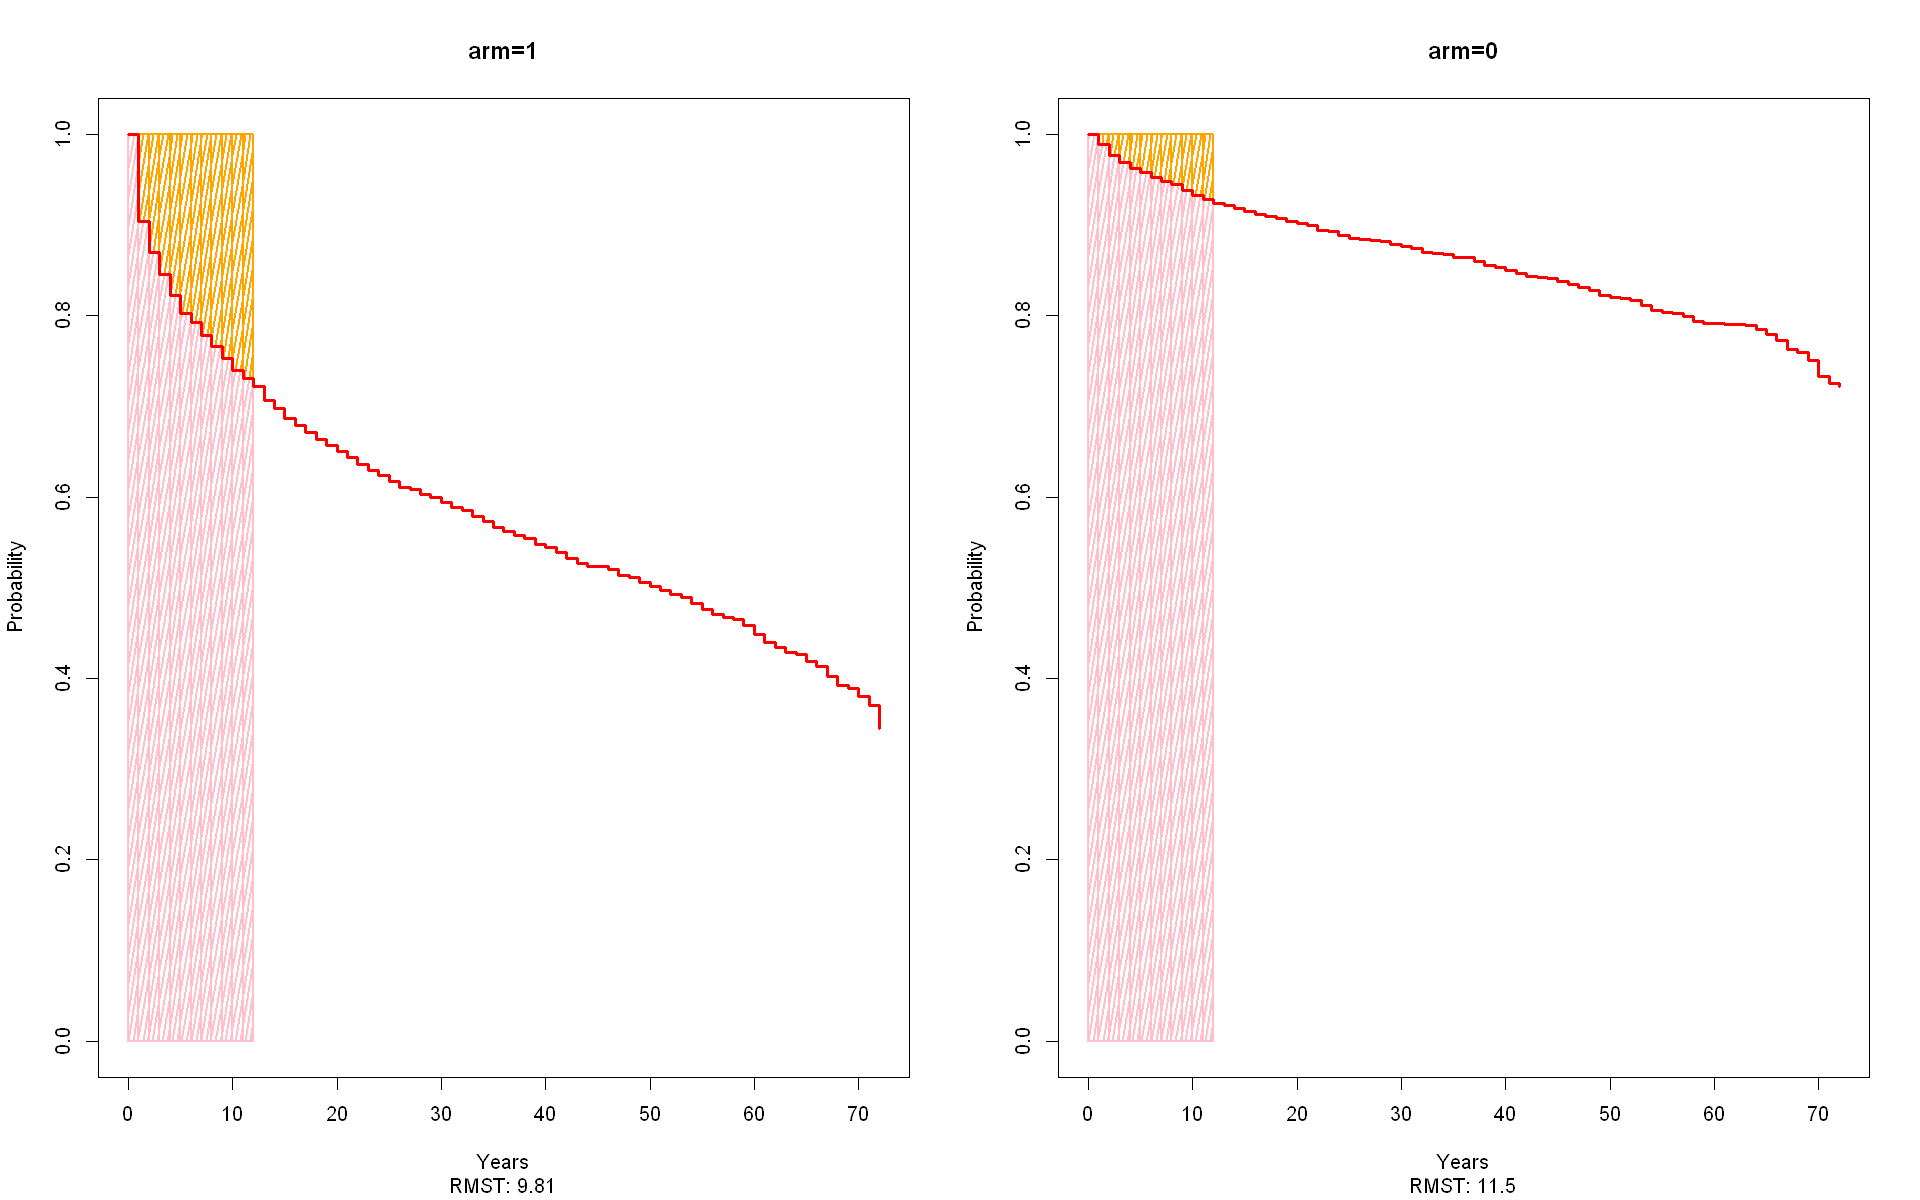

In [223]:
churn_pay = churn_internet %>% mutate(grp = as.factor(ifelse(PaymentMethod=='Mailed check' | 
                                                             PaymentMethod=='Electronic check','1','0')))
plot_RMST(churn_pay,12)

### b) Customers with only Phone Services

In [219]:
churn_phone = churn_seg[which(churn_seg$InternetService=='No'),]

##### b.1) Contract Type
In the first year the churn for customers with monthly contracts is of 20%, but we can see that it doesn't have a constant decrease through time.

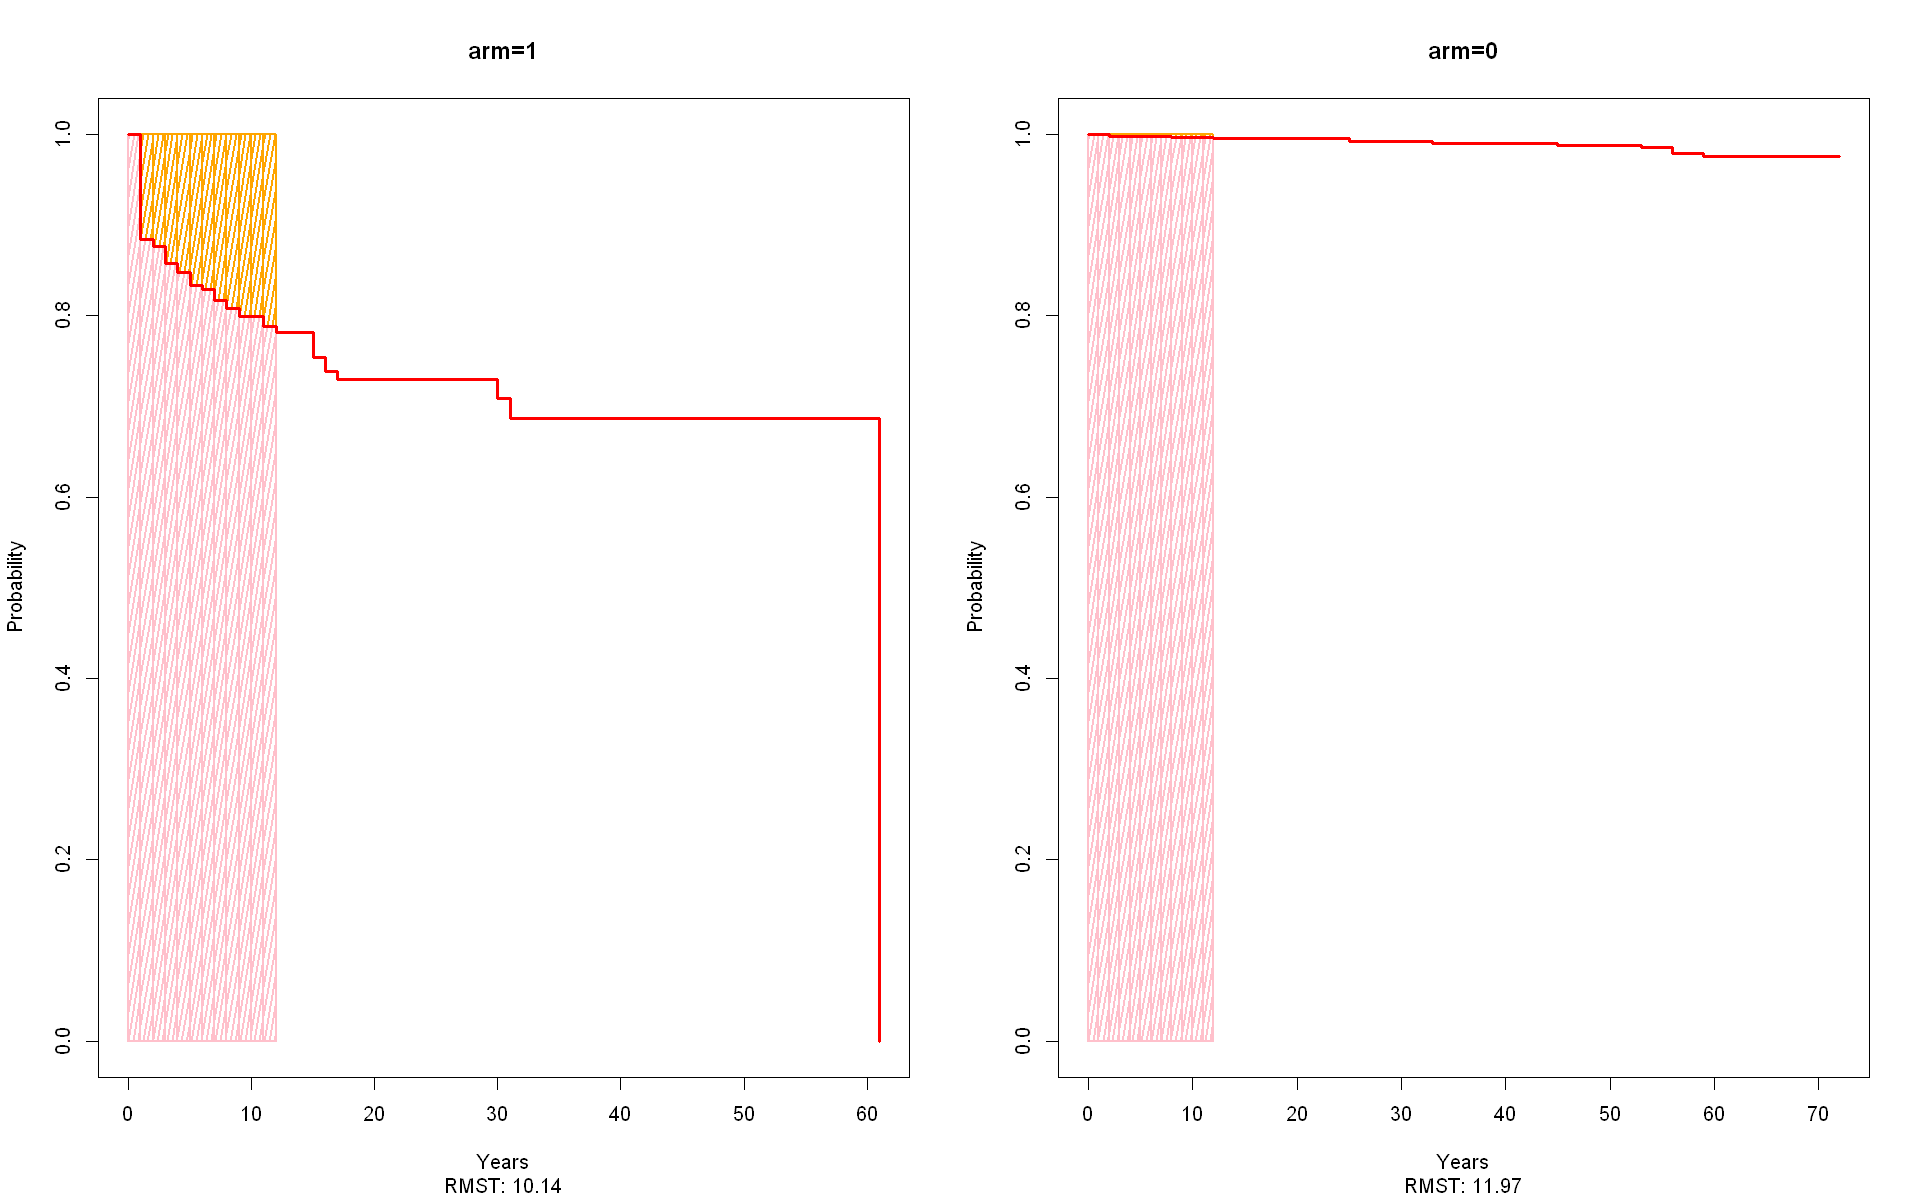

In [224]:
churn_ctr = churn_phone %>% mutate(grp = as.factor(ifelse(Contract=='Month-to-month','1','0')))
plot_RMST(churn_ctr,12)

##### b.2) Multiple Lines
From the survival curve we can observe that multiple lines have a lower risk of churn.

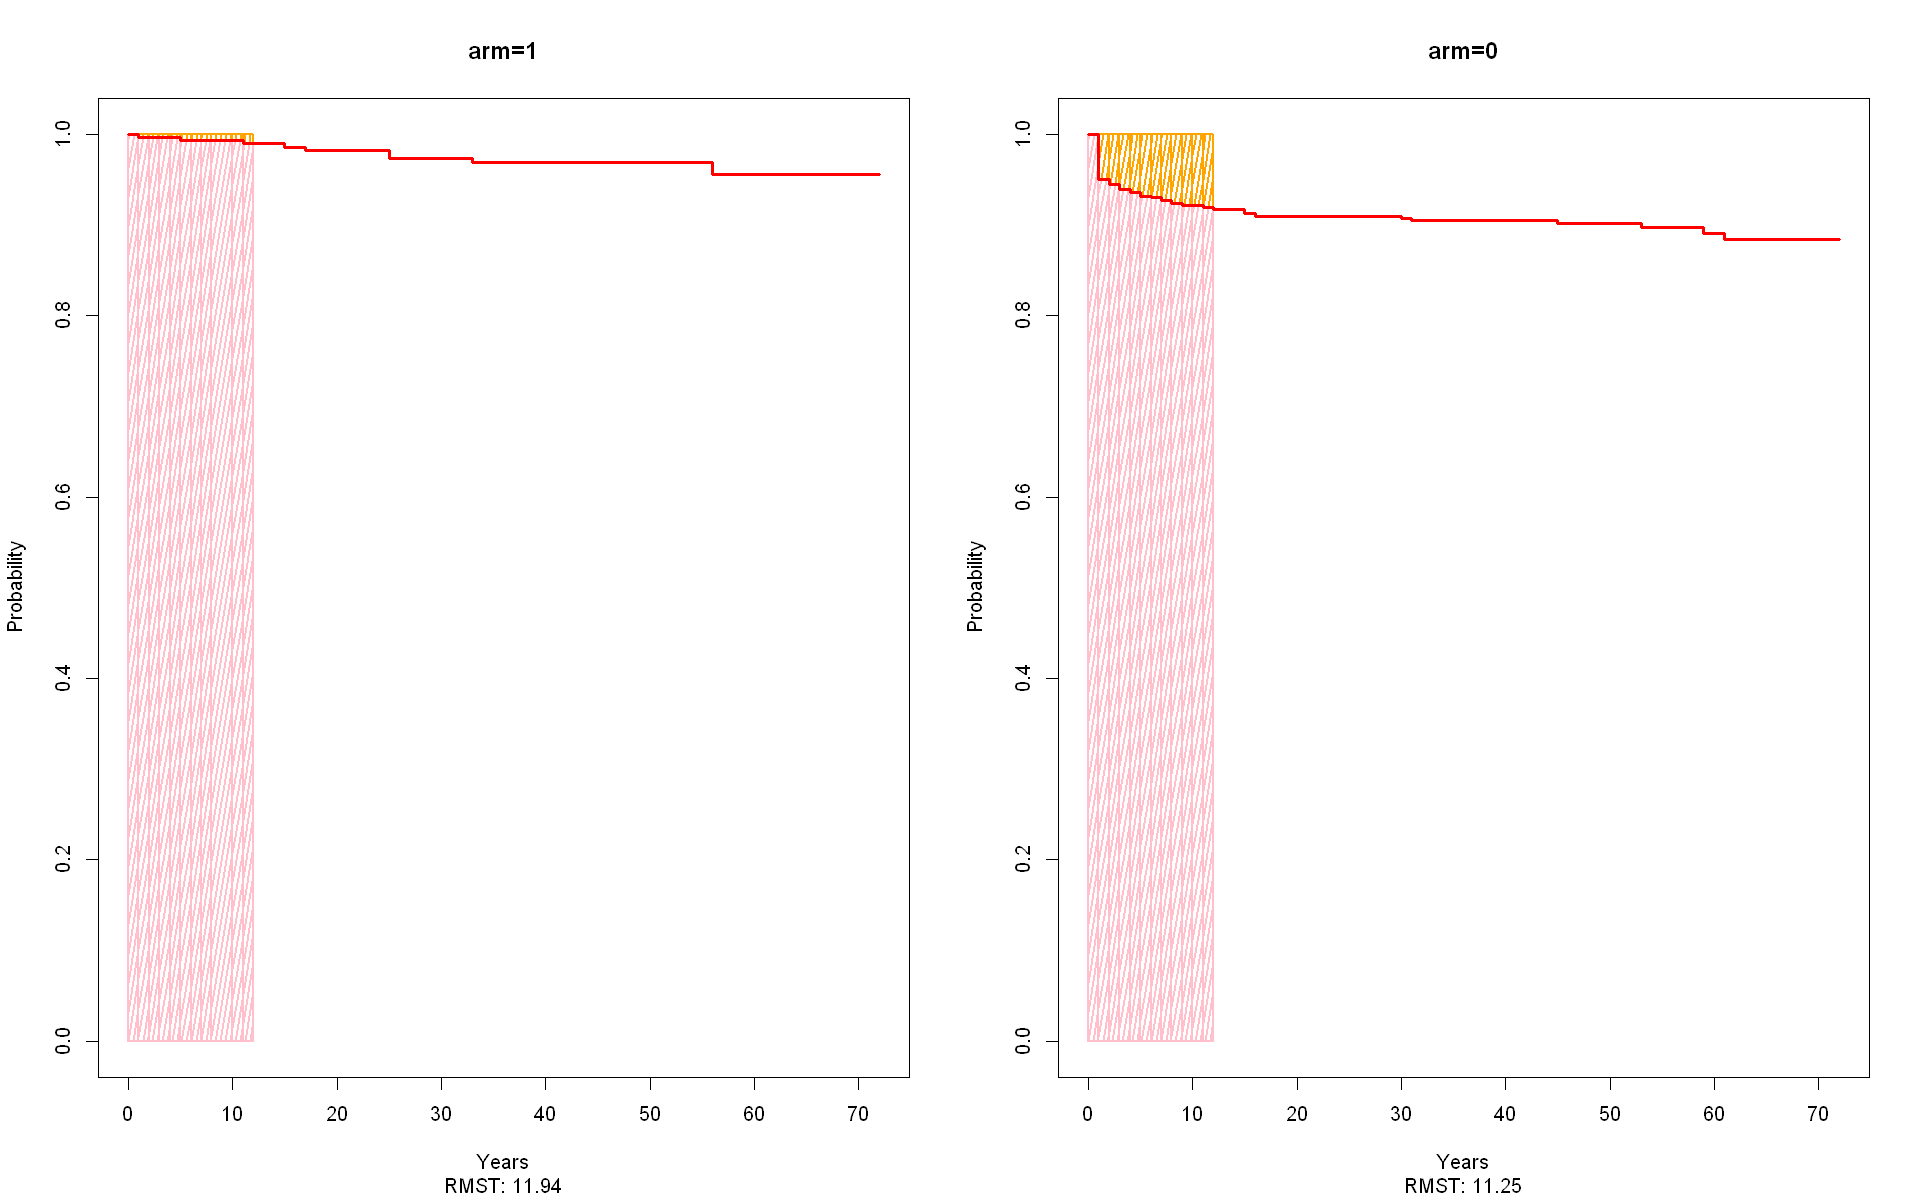

In [227]:
churn_lines = churn_phone %>% mutate(grp = as.factor(ifelse(MultipleLines=='Yes','1','0')))
plot_RMST(churn_lines,12)

##### b.3) Payment Method
Amongst the payment methods we can check that the automatic categories (credit card and bank transfer) have lower churn rates when compared to the manual ones (electronic and mailed check). 

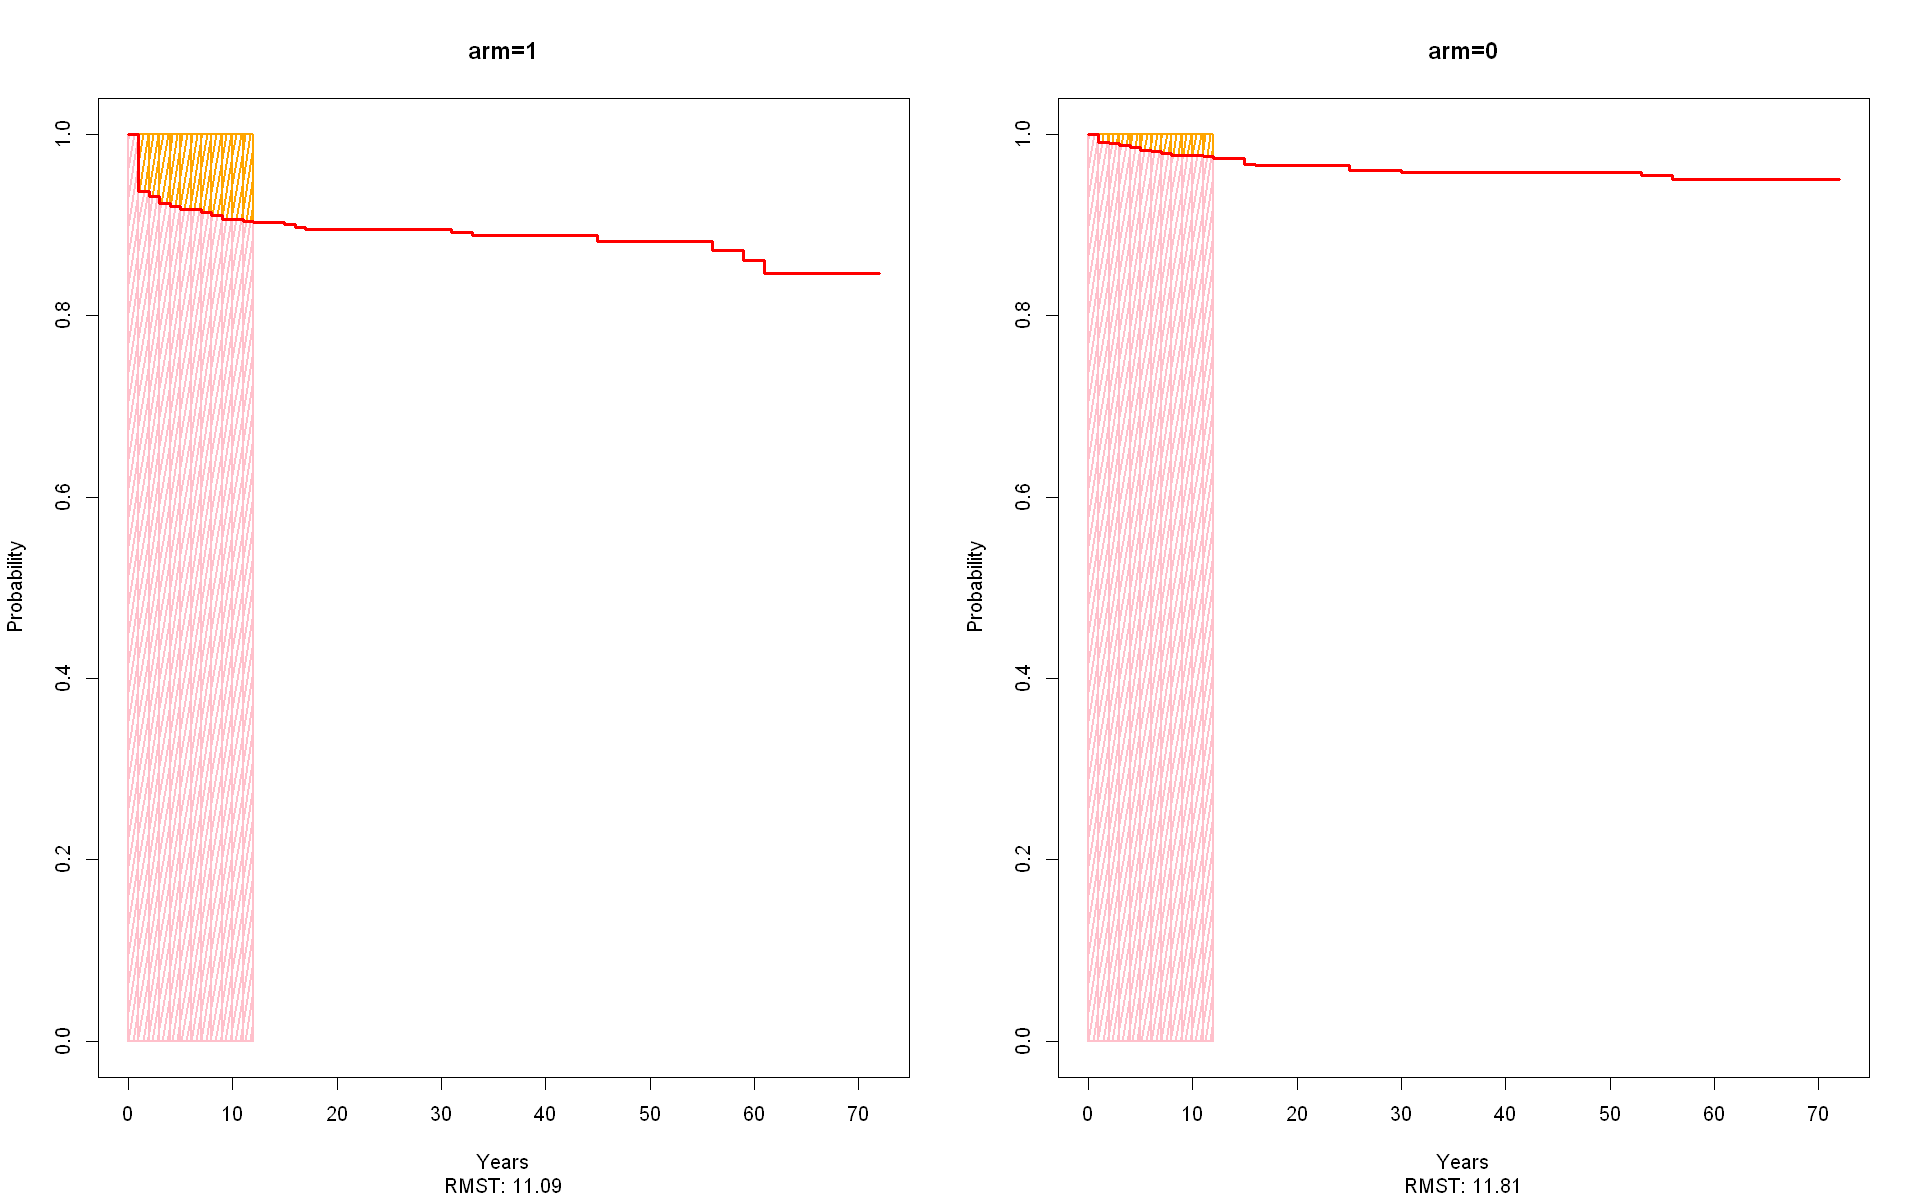

In [222]:
churn_pay = churn_phone %>% mutate(grp = as.factor(ifelse(PaymentMethod=='Mailed check' | 
                                                             PaymentMethod=='Electronic check','1','0')))
plot_RMST(churn_pay,12)

# Conclusion
<hr>

We saw that using Kaplan-Meier we can get the insights of the parameters that impact the churn of customers, in order to define a retention plan the key findings of this study are:

- <B>Contract:</B> 55% of the contracts are of type "month-month", and it is notorious that it presented more incidence of churn over the period, and it is the most relevant factor to define a customer retention strategy.

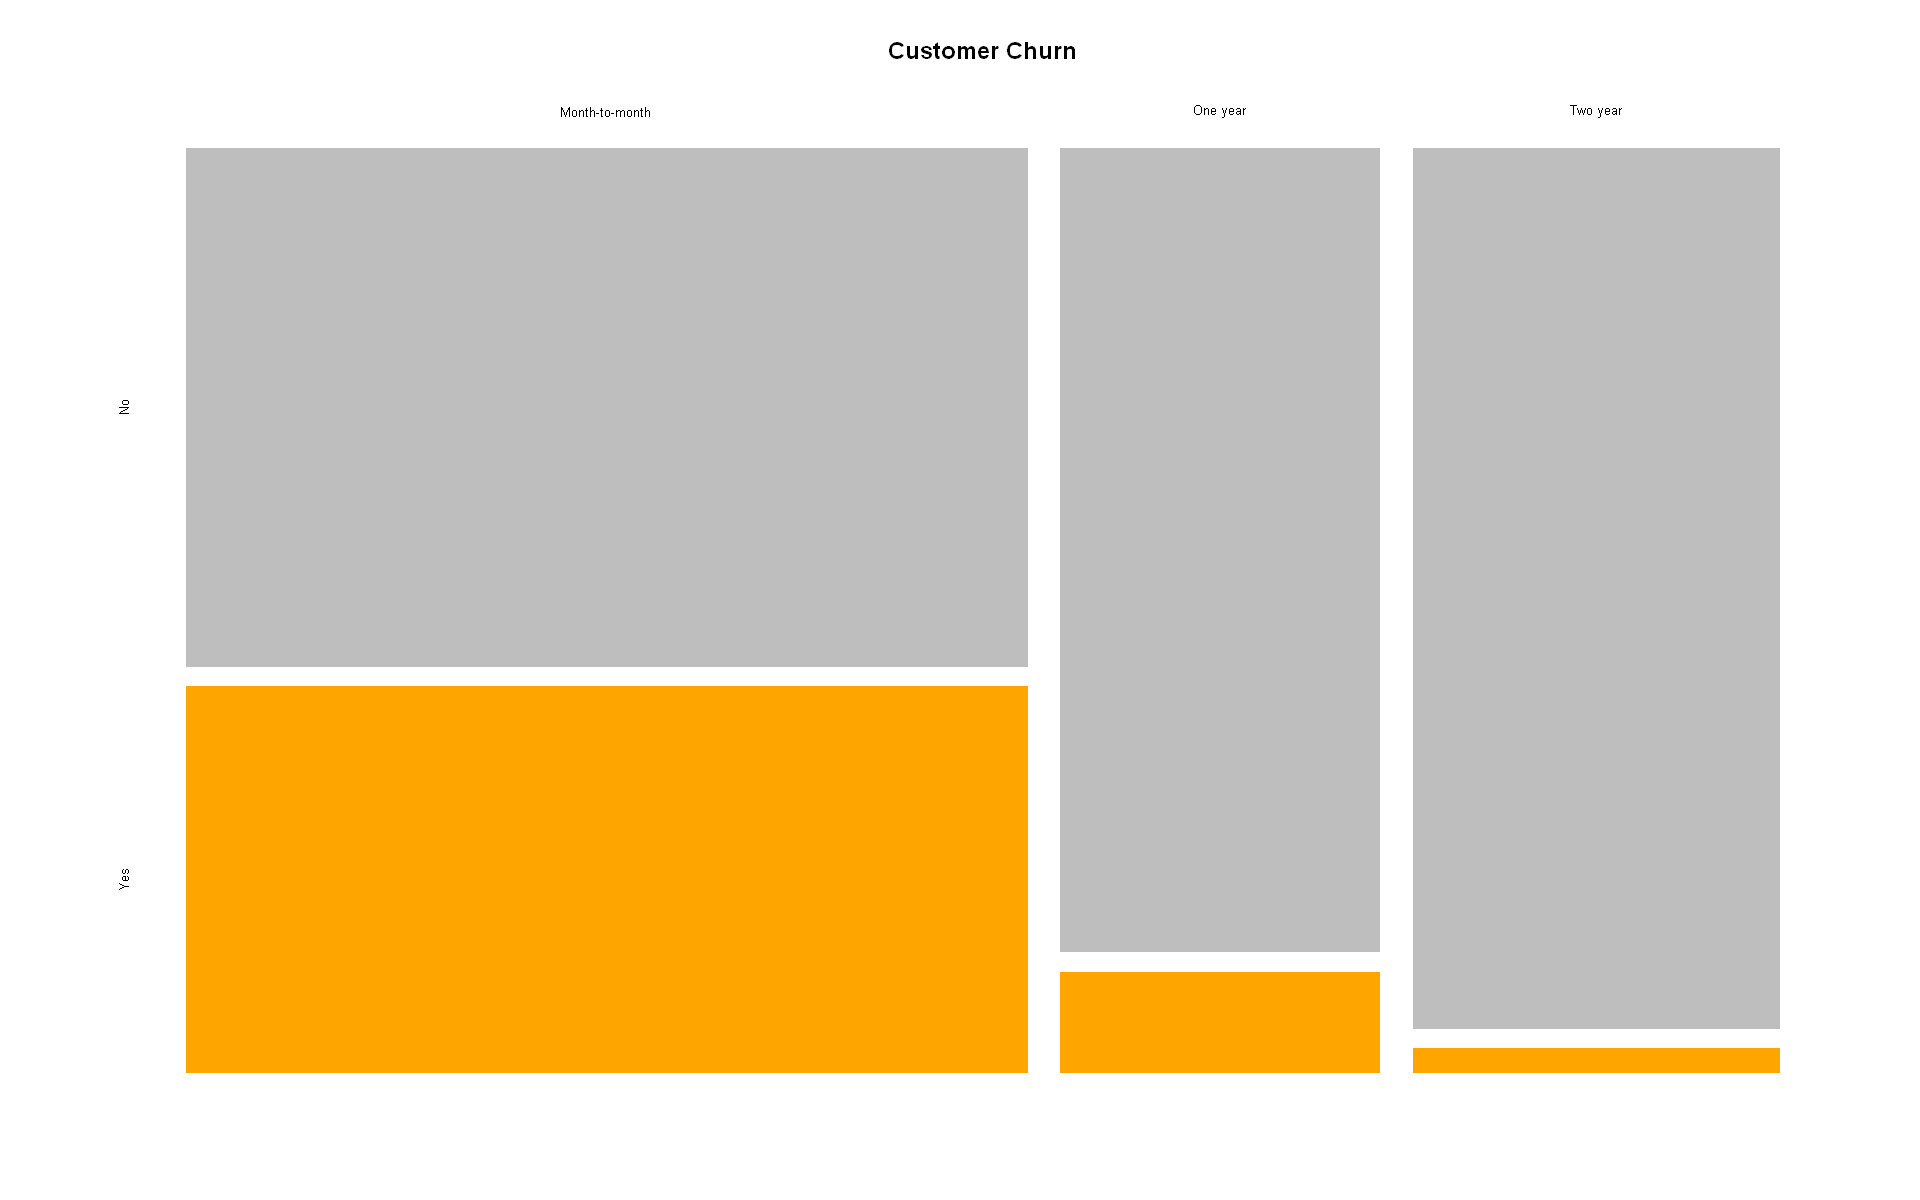

In [49]:
plot(table(churn$Contract, churn$Churn), col=c('gray','orange'), 
     border = 'white', main = "Customer Churn")

- <B>Customer from segment 1:</B> 

Customers of this segment are young, without partners and dependents. It seems to be more complex in terms of requirements to reduce substantially the hazard of churn, because they use a lot of technology resources. The recommendation is to offer tech support for free in exchange for a contract of at least one year. Simulating this scenario where customers have technical support and contracts of one or two years the impact on the reduction in the churn rate is highly significant, as we can see on the chart below. The perpective is to reduce dramatically the churn of customers.

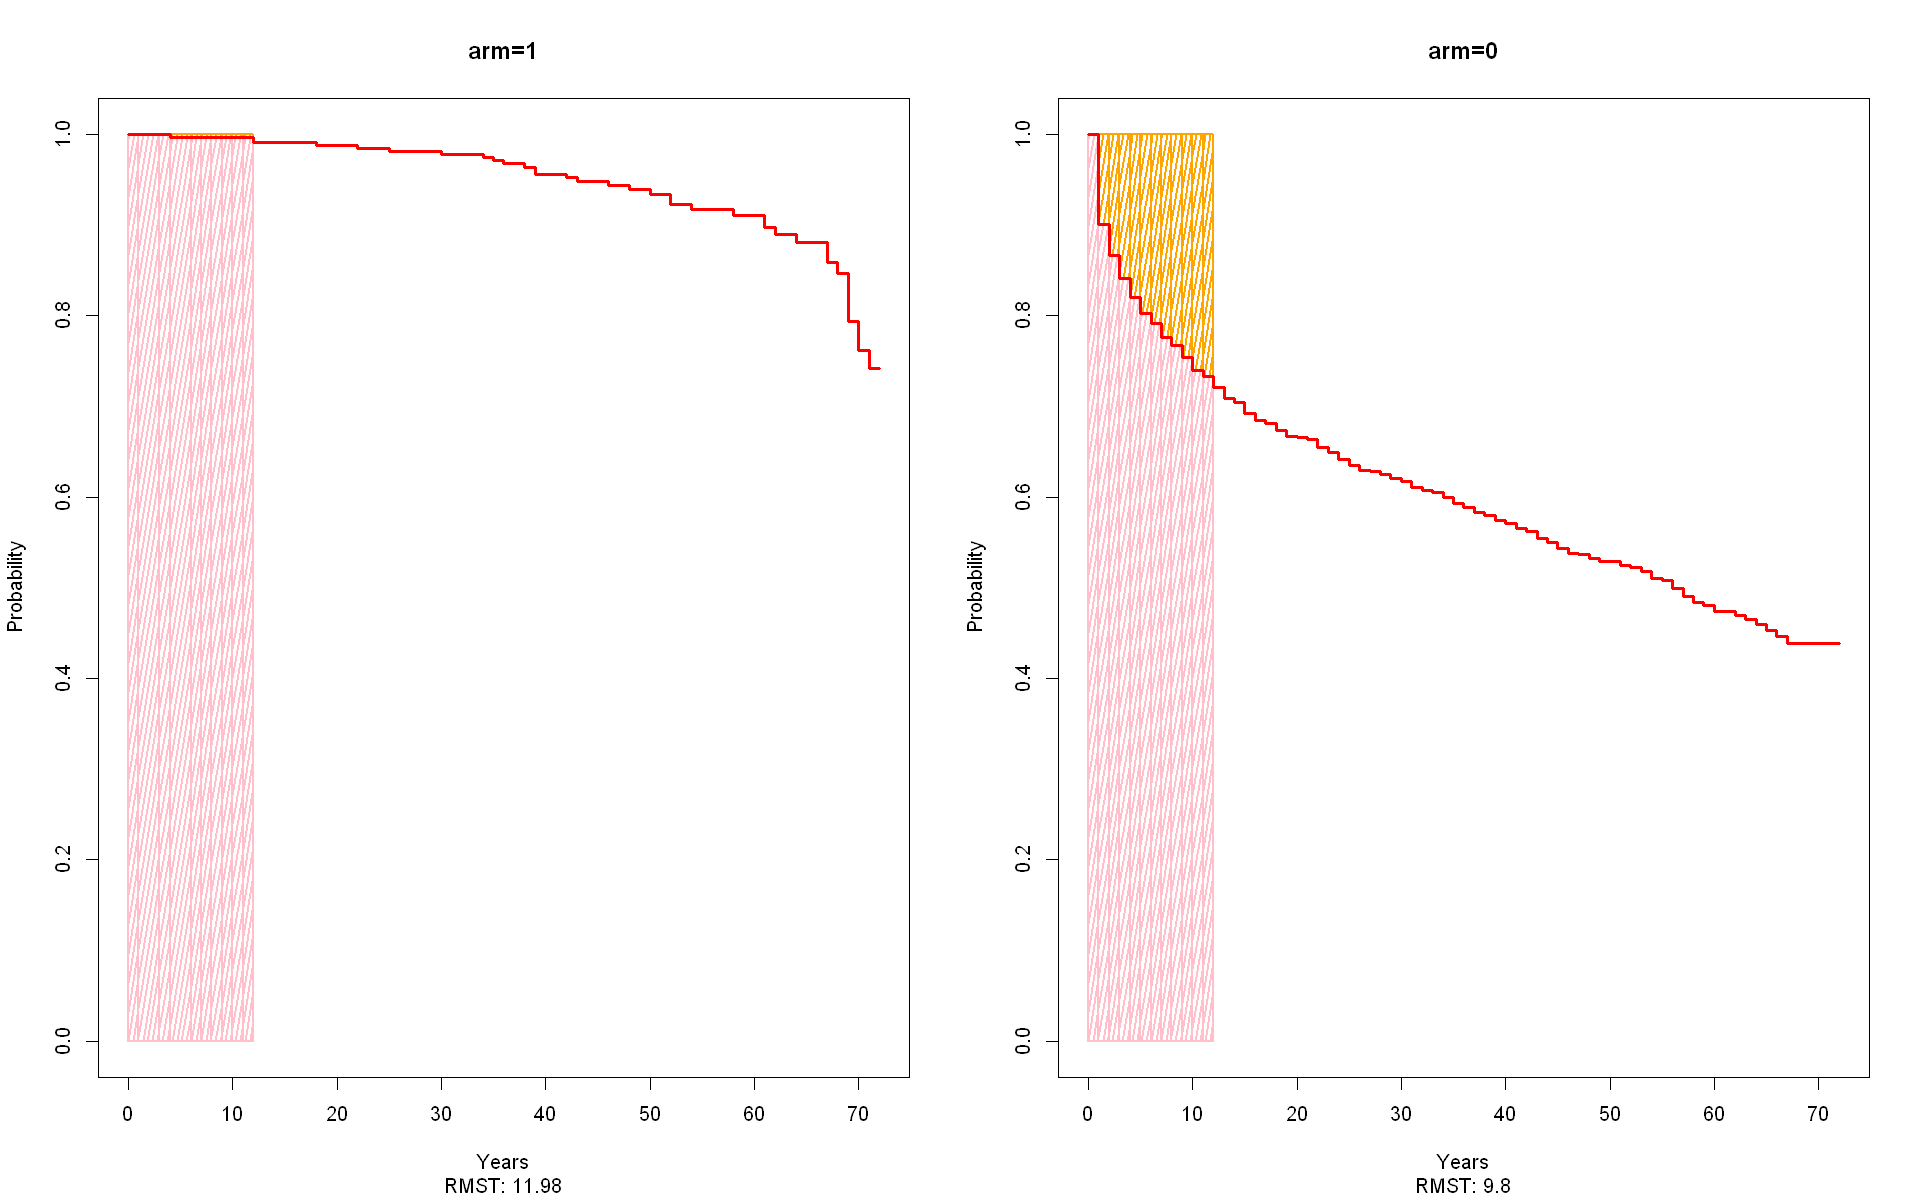

In [235]:
churn_tech = seg1 %>% mutate(grp = as.factor(ifelse(TechSupport=='Yes' & Contract != 'Month-to-month','1','0')))
plot_RMST(churn_tech,12)

During the study we could see that some covariates have a great improvement on reducing the churn when they are combined. The recommendation that we have is to create combos with promotional prices to customers. The first combo should consider the security services and the other the streaming. On the security combo the services are: online backup, device protection and online security, while the streaming would consider the TV and the movies.
Below we present the simulation of the scenarios of combos and the predicted results of the implementation on the retention strategy.

<u><i>Security</i></u>

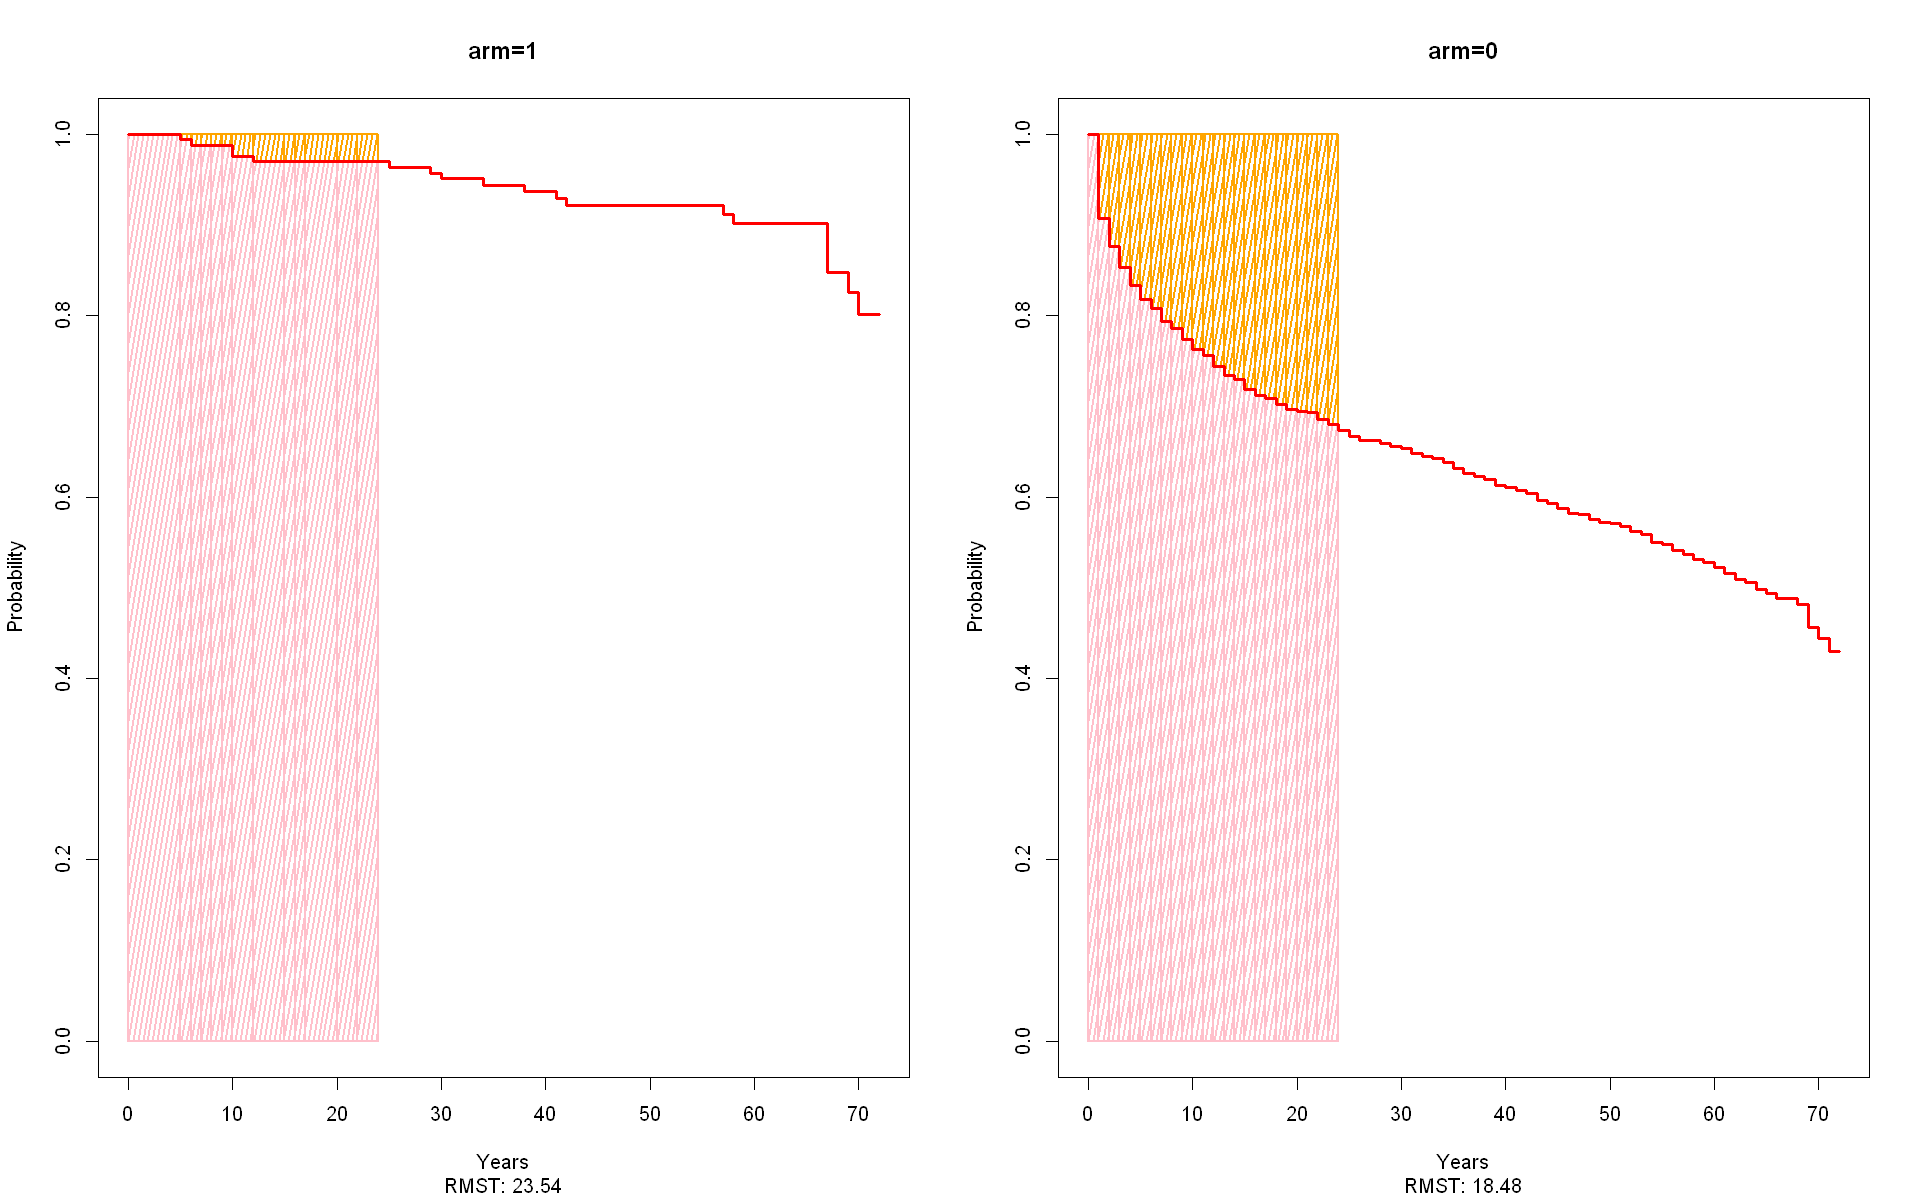

In [249]:
churn_combo1 = seg1 %>% mutate(grp = as.factor(ifelse(OnlineBackup=='Yes' & DeviceProtection =='Yes' & 
                                                      OnlineSecurity == 'Yes','1','0')))
plot_RMST(churn_combo1)

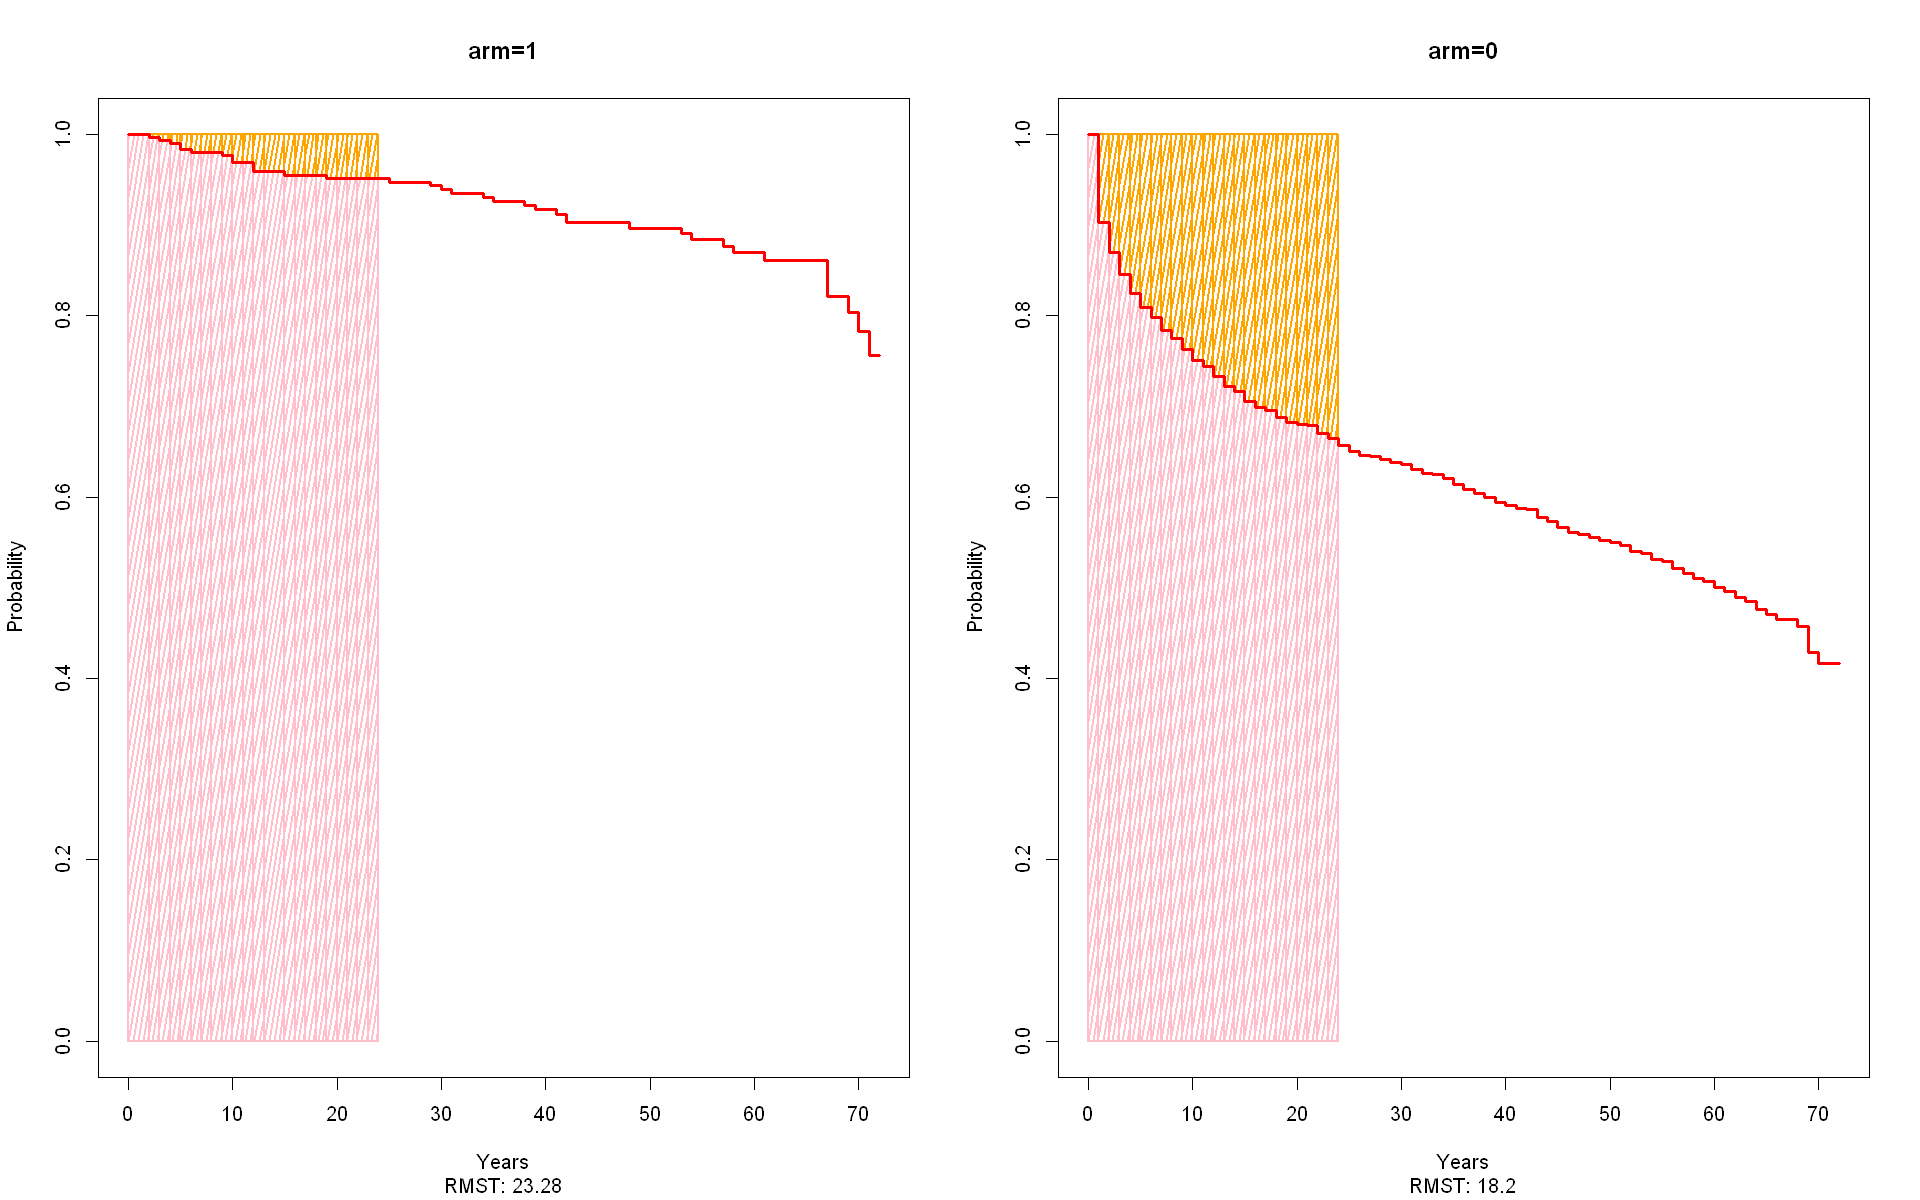

In [250]:
churn_combo2 = seg1 %>% mutate(grp = as.factor(ifelse(OnlineSecurity=='Yes' & DeviceProtection =='Yes','1','0')))
plot_RMST(churn_combo2)

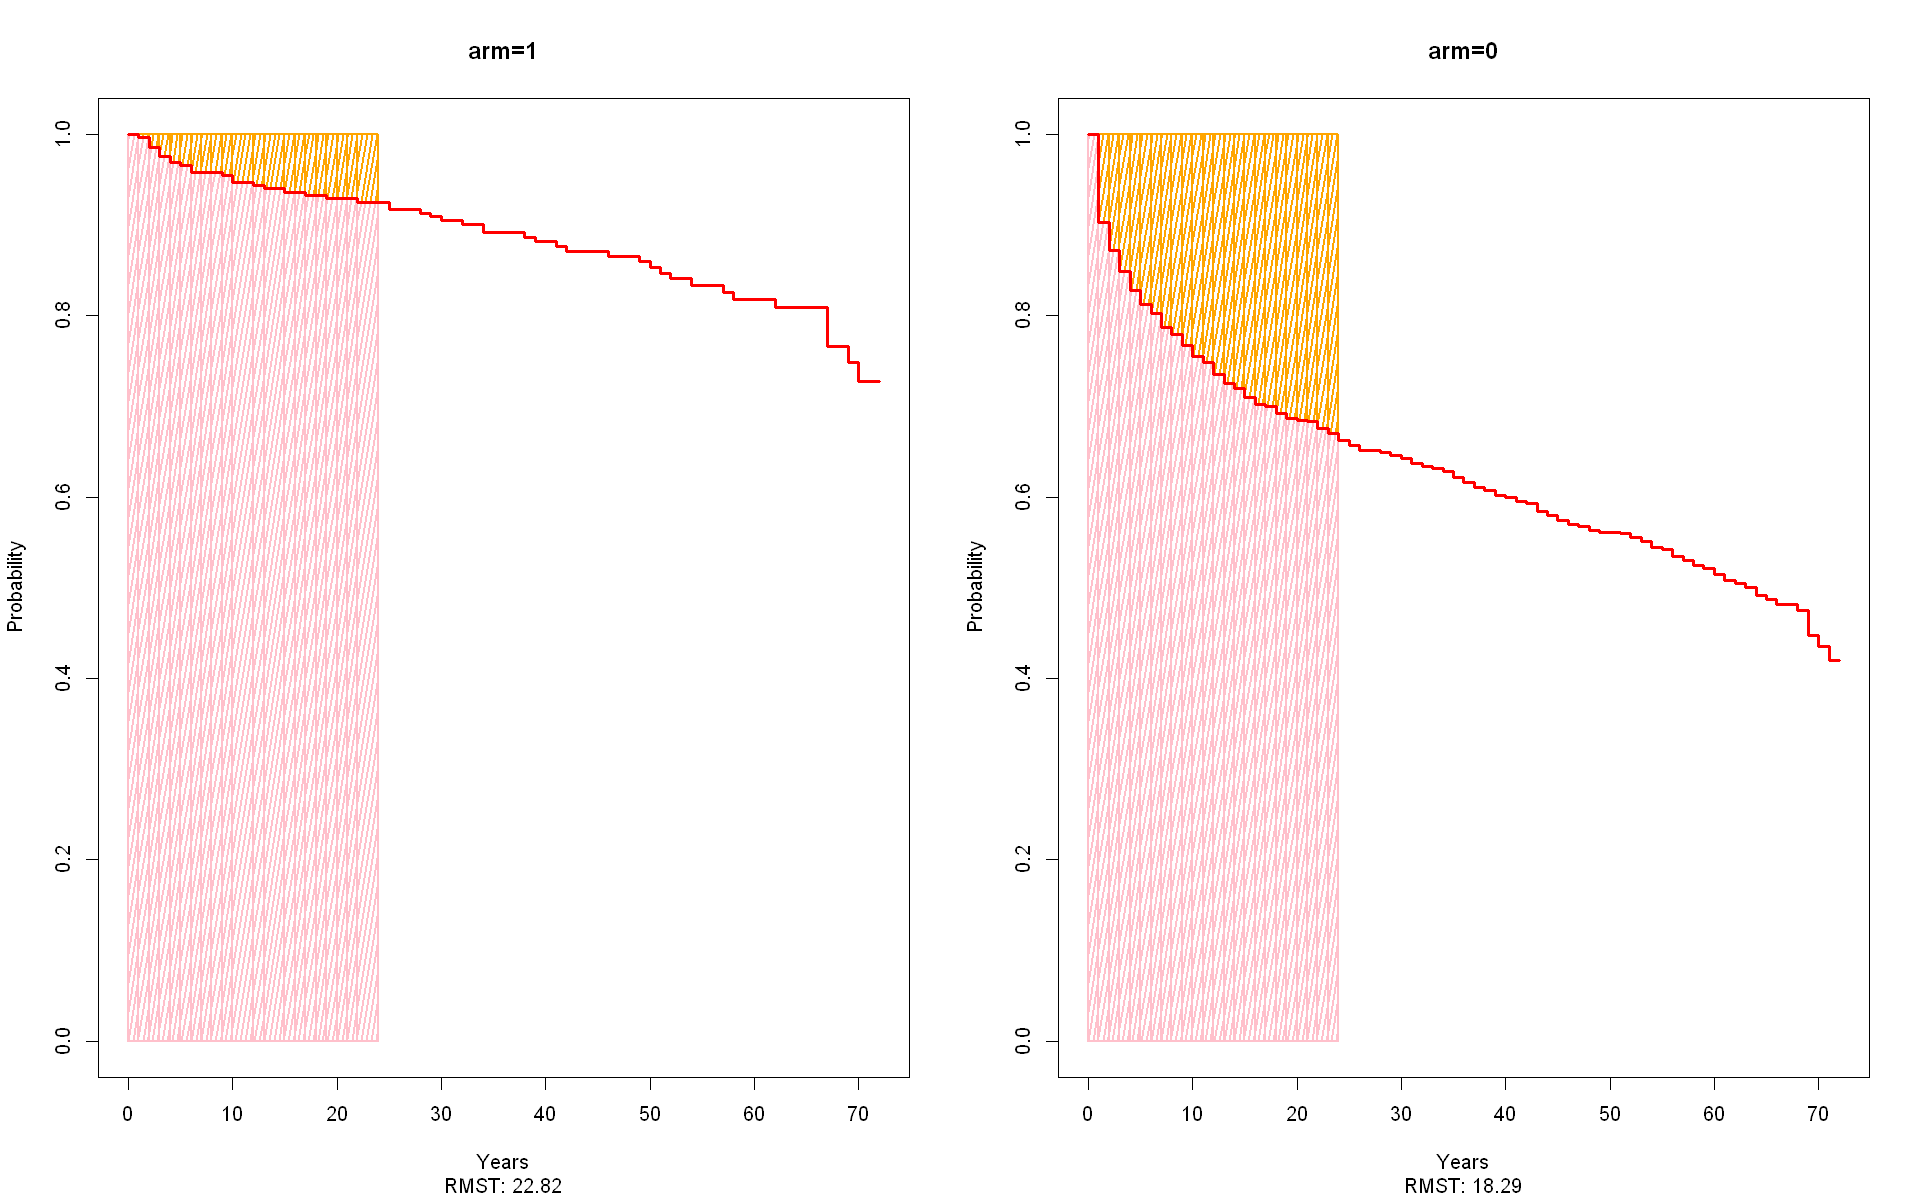

In [251]:
churn_combo3 = seg1 %>% mutate(grp = as.factor(ifelse(OnlineSecurity=='Yes' & OnlineBackup =='Yes','1','0')))
plot_RMST(churn_combo3)

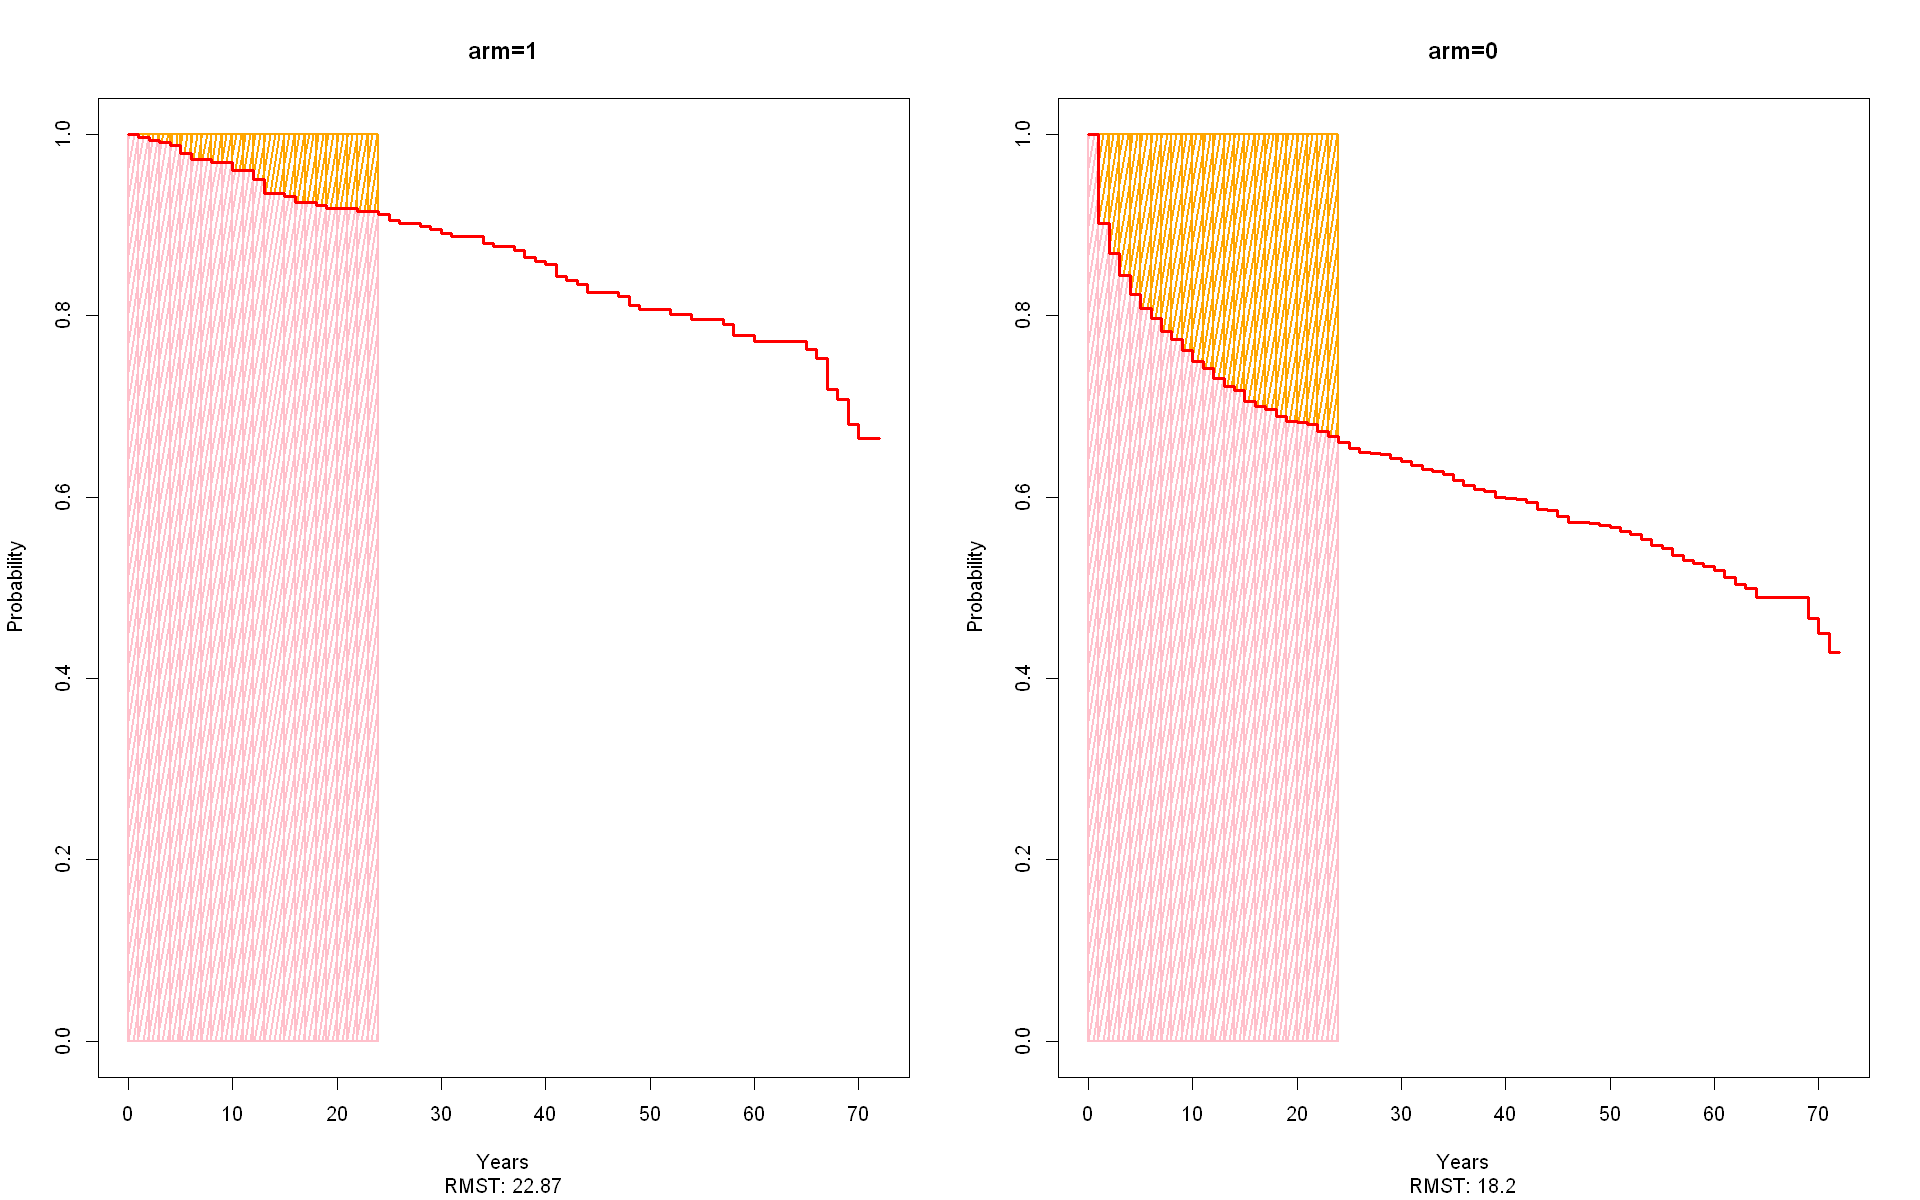

In [252]:
churn_combo4 = seg1 %>% mutate(grp = as.factor(ifelse(OnlineBackup=='Yes' & DeviceProtection =='Yes','1','0')))
plot_RMST(churn_combo4)

<u><i>Streaming</i></u>

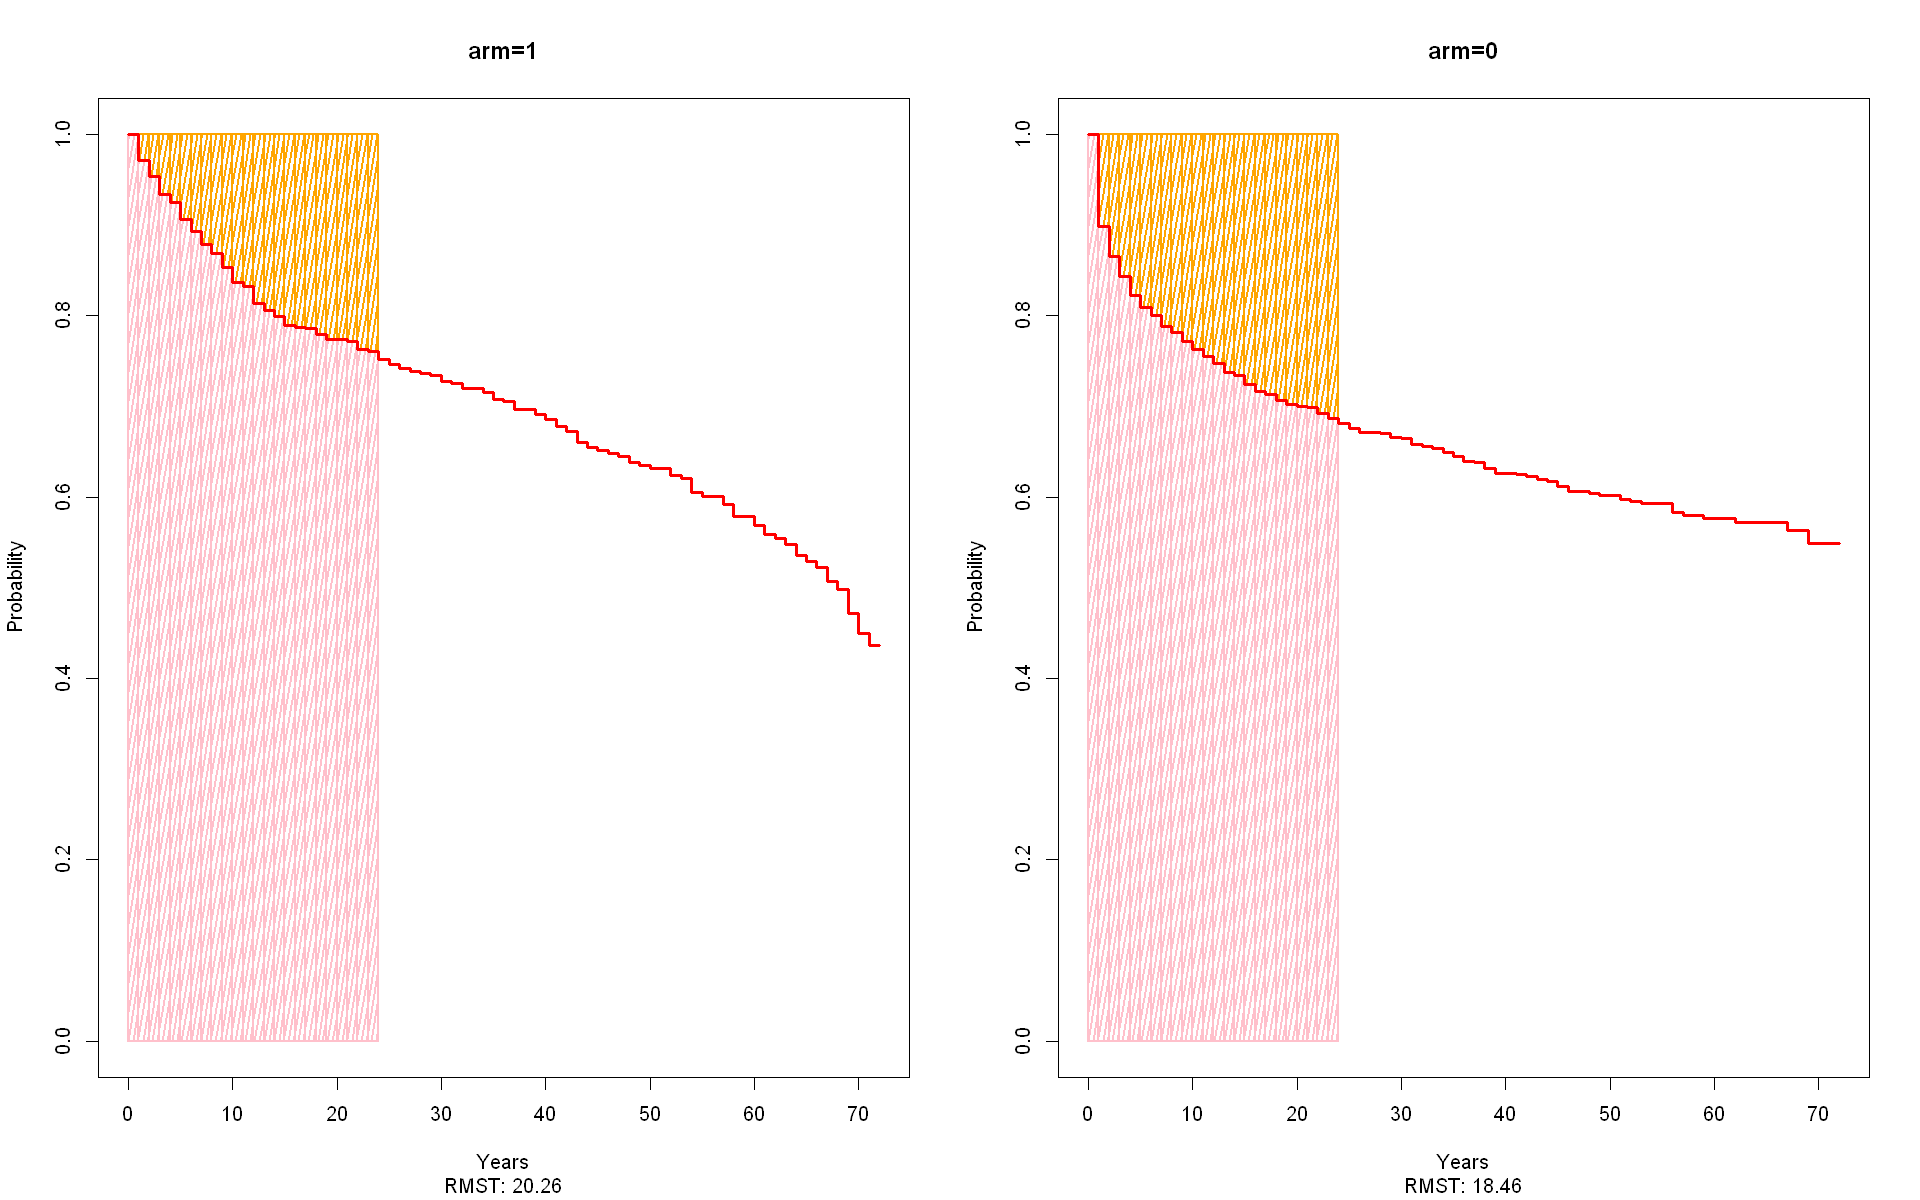

In [253]:
churn_combo5 = seg1 %>% mutate(grp = as.factor(ifelse(StreamingTV=='Yes' & StreamingMovies =='Yes','1','0')))
plot_RMST(churn_combo5)

- <B>Customer from segment 2:</B> 

Customers of this segment are senior, without partners and dependents. The recommendation is to offer online backup or streaming movies for free in exchange for a contract of at least one year. Simulating this scenario where customers have one of this services and a contract of one or two years the impact on the reduction in the churn rate is highly significant, as we can see on the chart below. The perpective is to reduce dramatically the churn of customers.

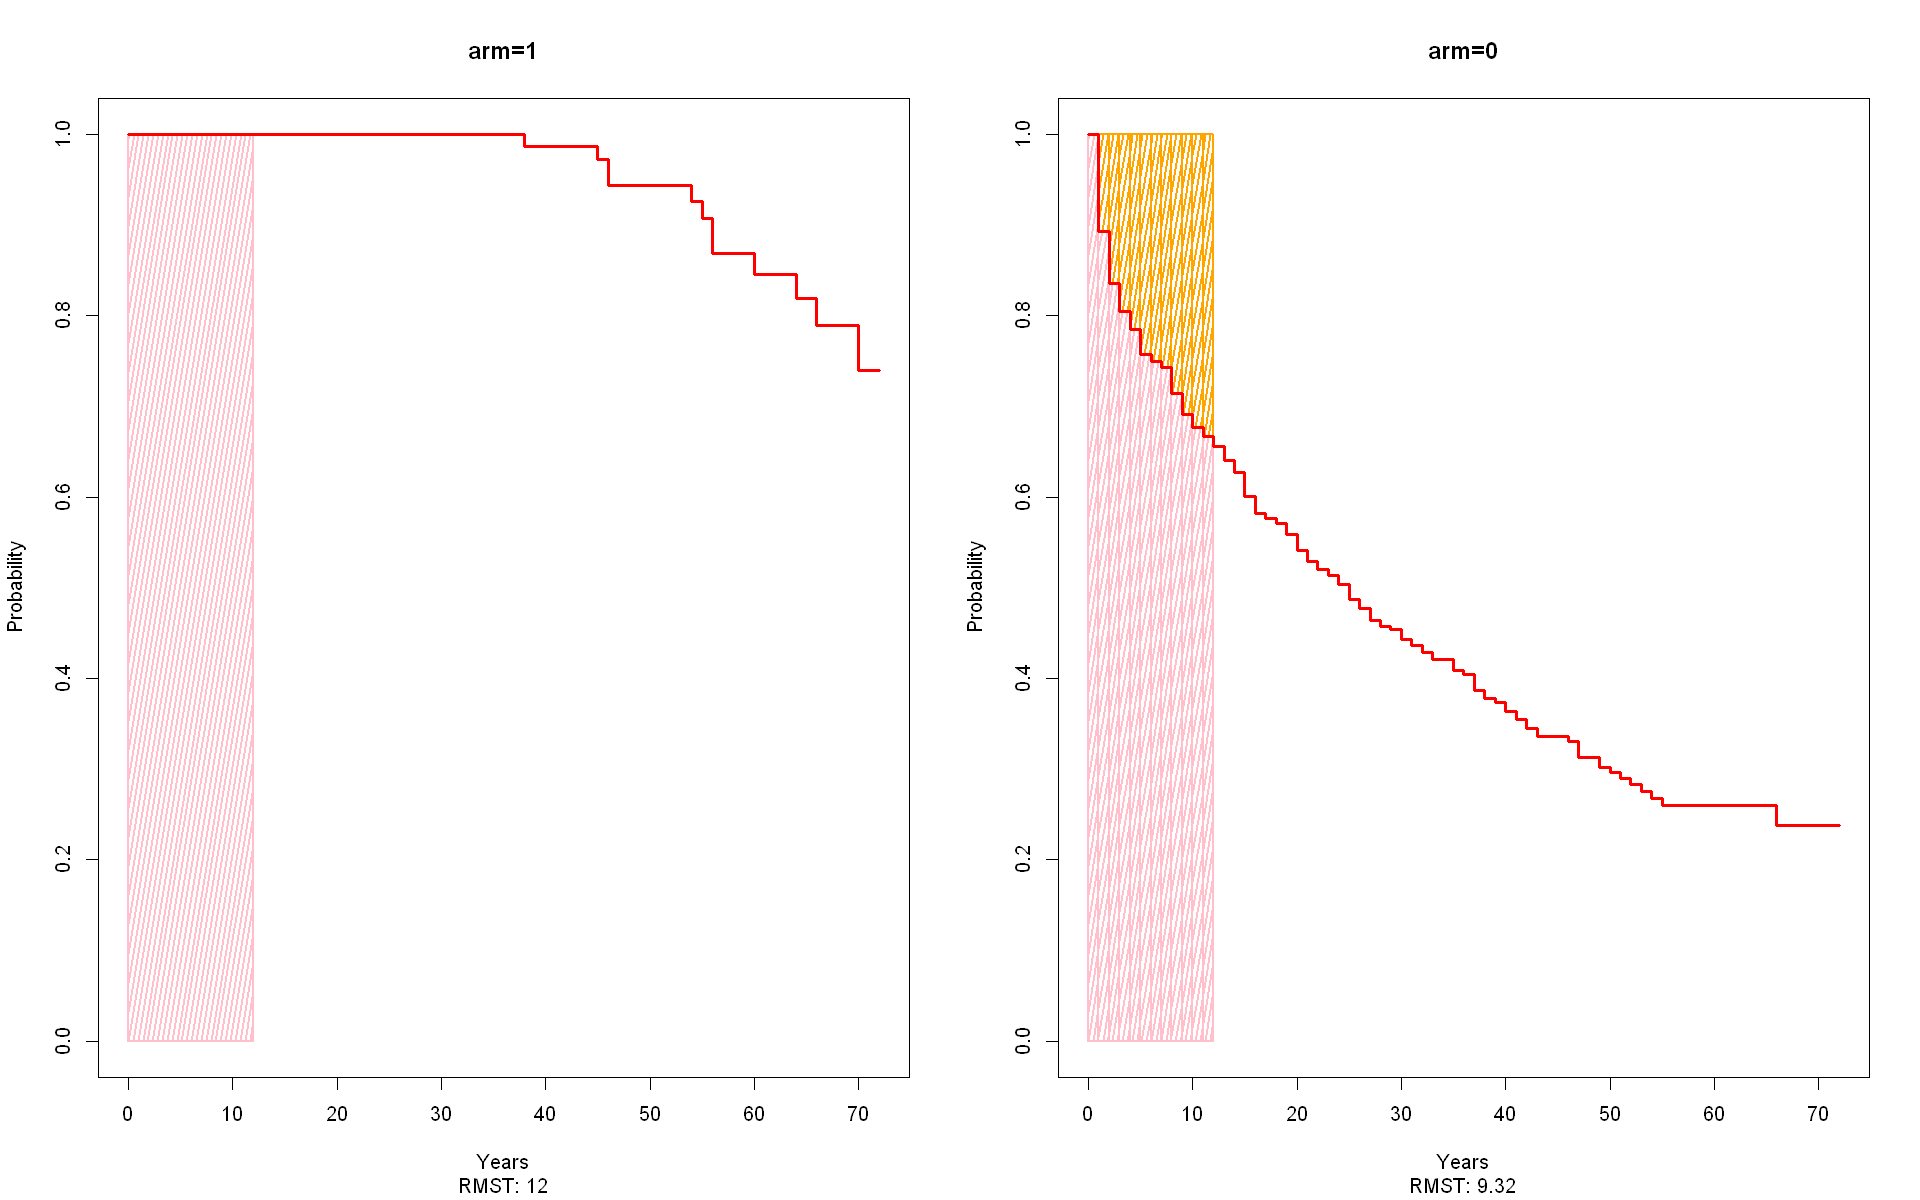

In [259]:
churn_seg2 = seg2 %>% mutate(grp = as.factor(ifelse((OnlineBackup=='Yes' | StreamingMovies =='Yes') 
                                                    & Contract != 'Month-to-month','1','0')))
plot_RMST(churn_seg2,12)

- <B>Customer from segments 3 and 4:</B> 

The profile of this segment is of young people and with partners, and they represent 40% of the customers. When simulating the scenarios with different services we realized that the effect of customer retention is pradtically the same, therefore the recommendation is to offer any extra service for free in exchange for a contract of at least one year. As it is a heterogenous customers set, it's important to anaylize the interest of the customers before offering any service. Simulating this scenario where customers have one of this services and a contract of one or two years we observe a reduction of 10% in churn on the first year.

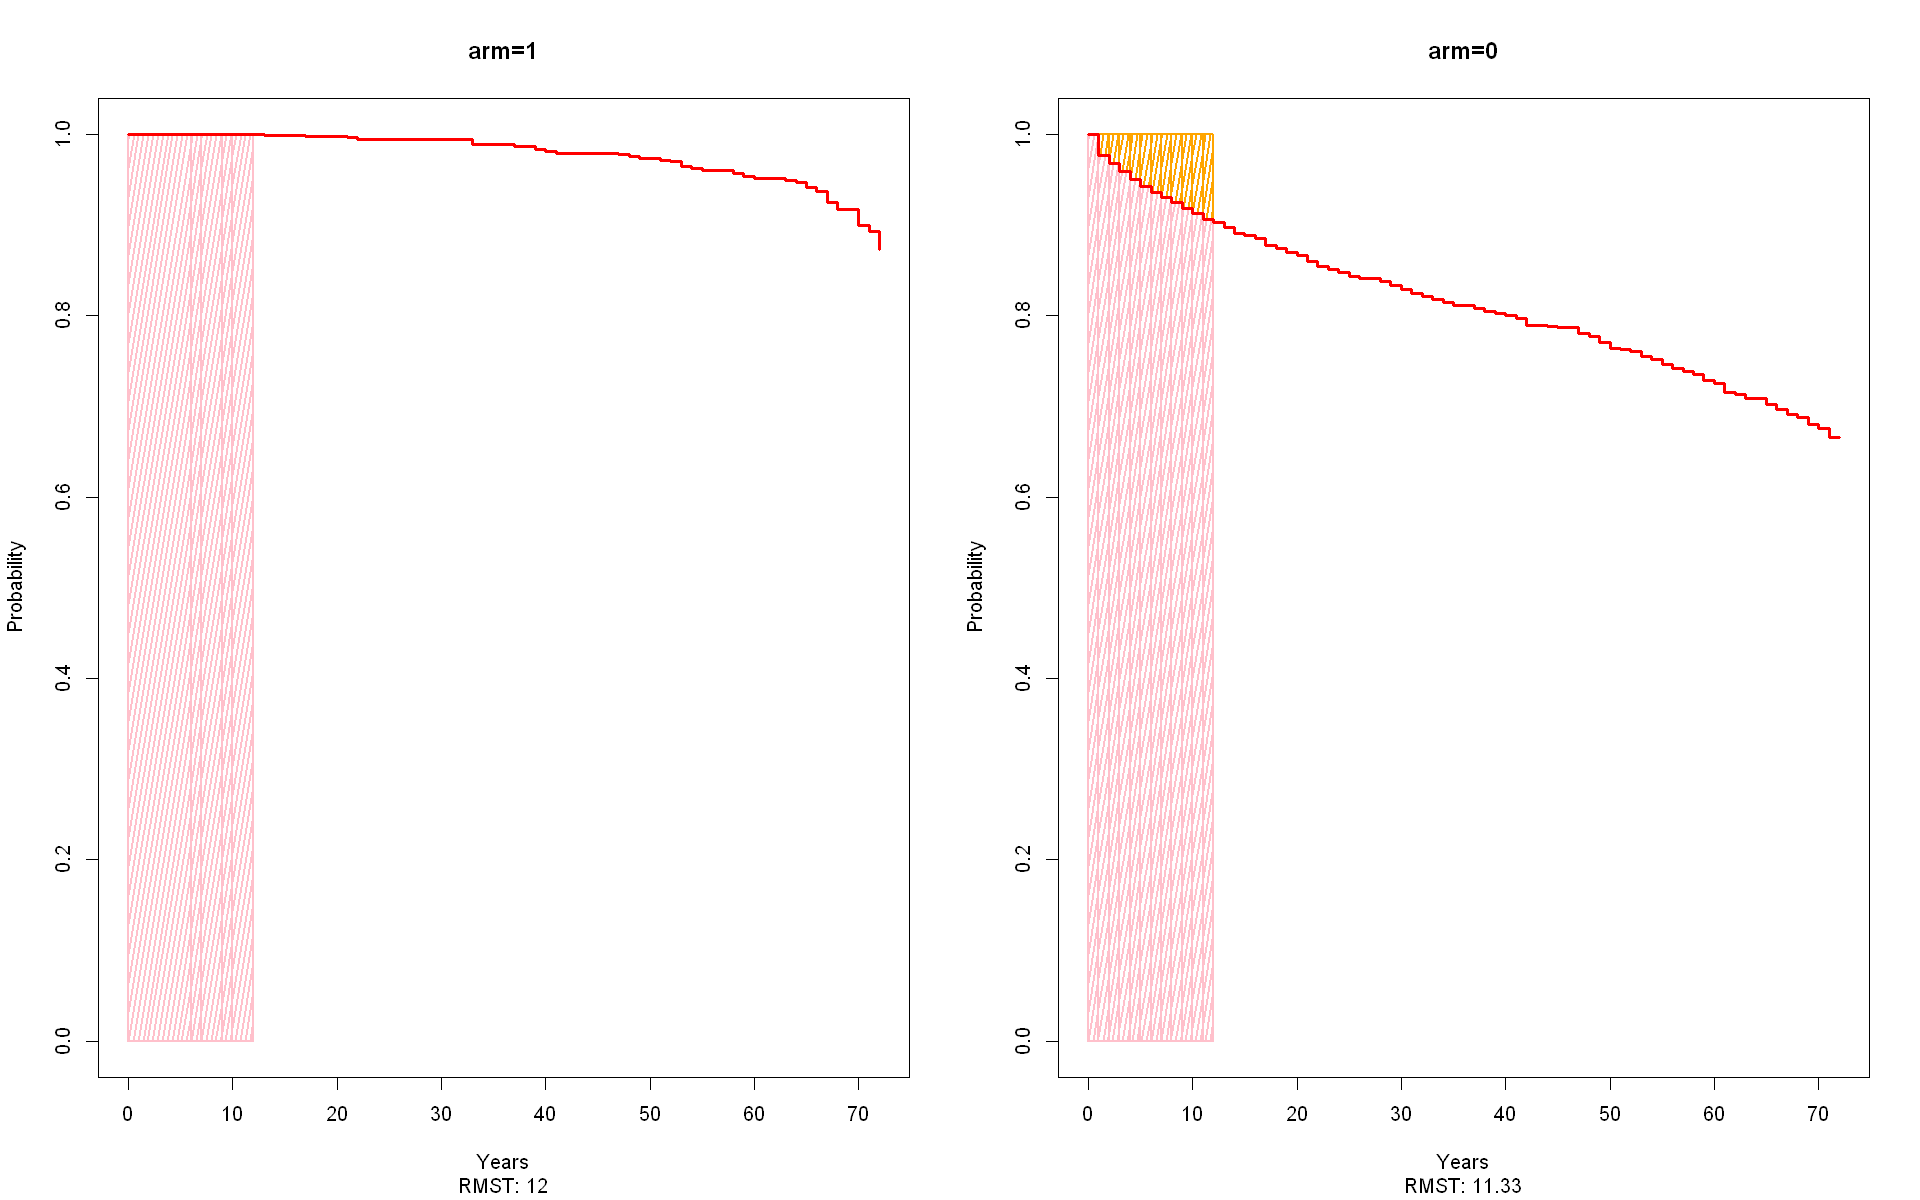

In [289]:
seg_union = rbind(seg3, seg4)
churn_serv = seg_union %>% mutate(grp = as.factor(ifelse(DeviceProtection=='Yes' & Contract != 'Month-to-month','1','0')))
plot_RMST(churn_serv,12)

- <B> Payment Method:</B> if the customer is required to interact monthly to pay the bills the hazard increases substantially. So here, the sales team should be instructed and rewarded to increase the use of automatic payment methods on the contracts with customers.

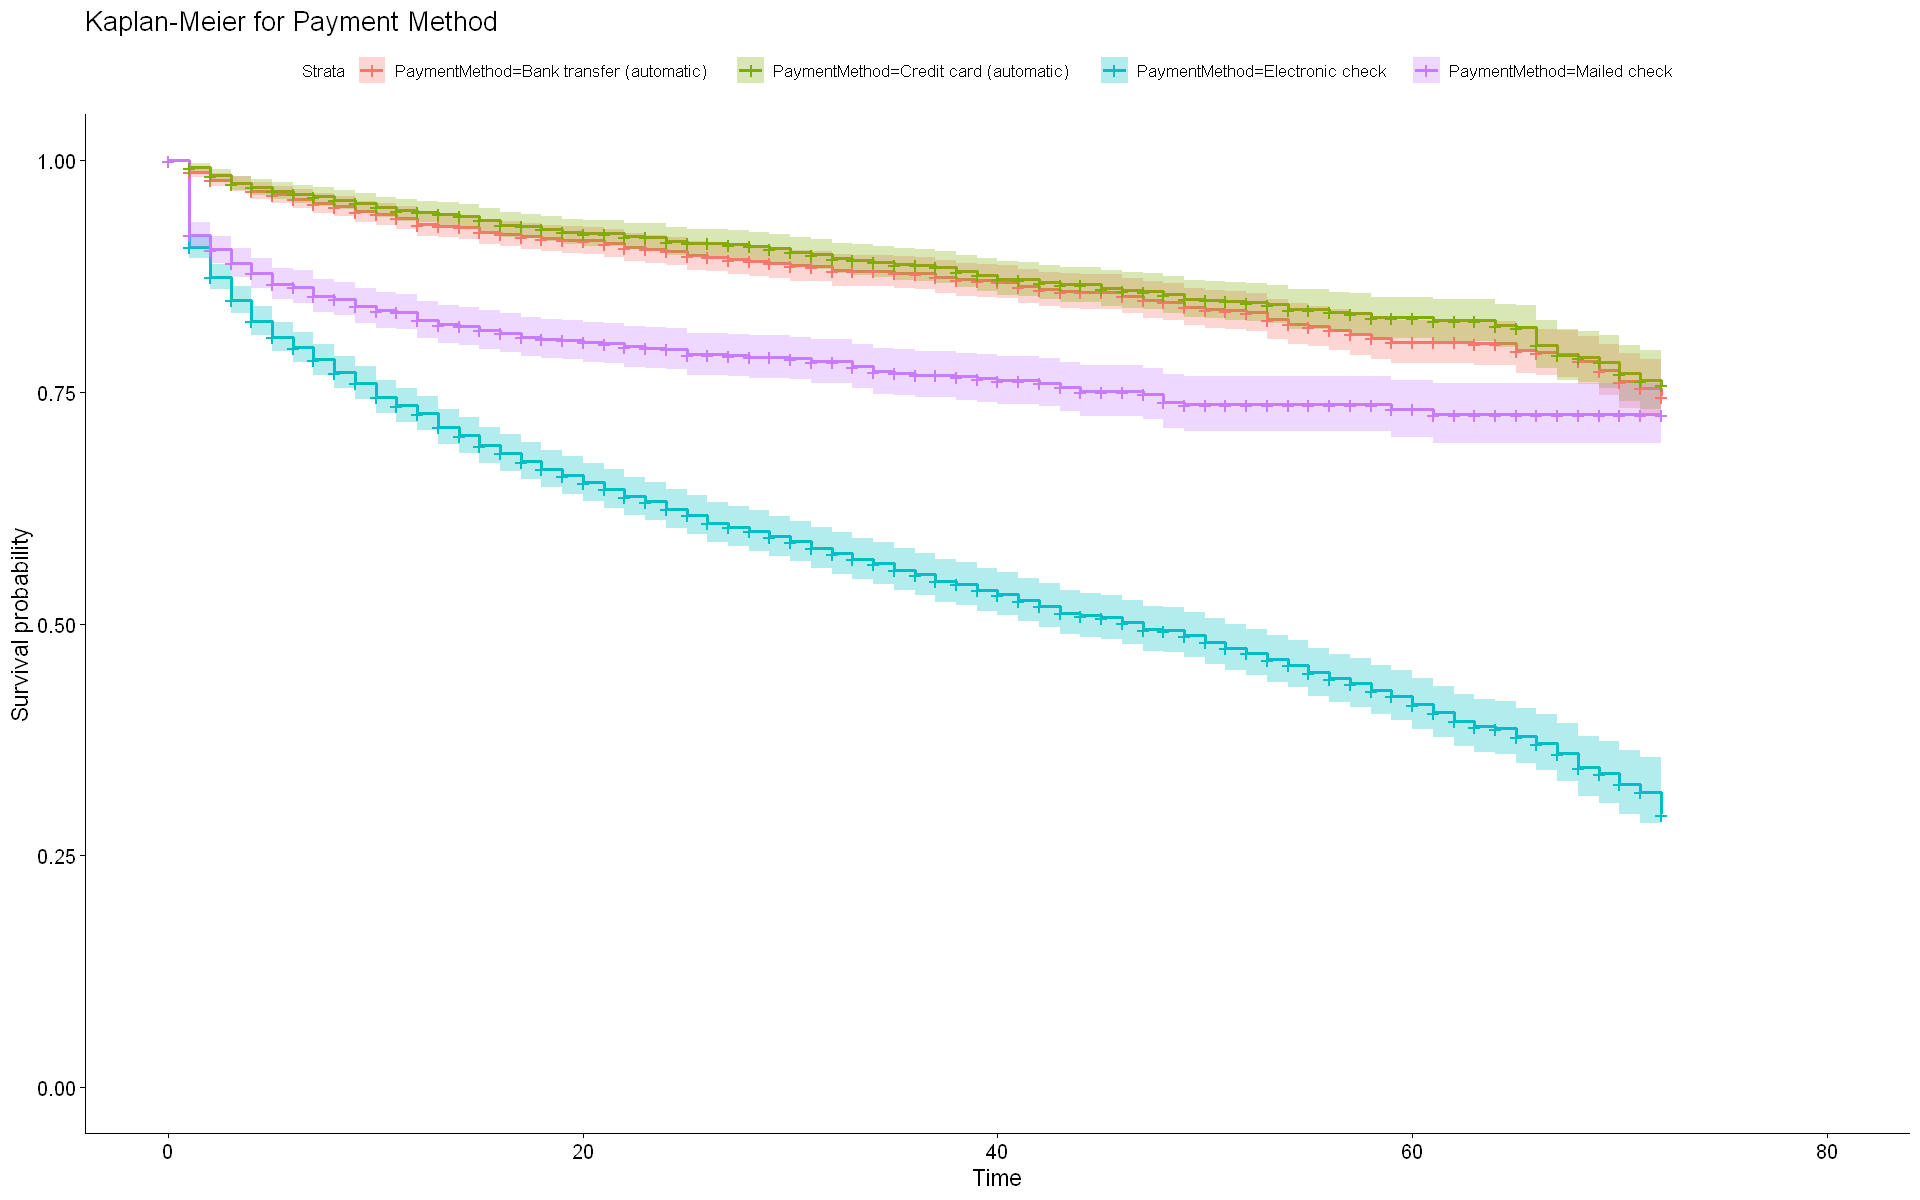

In [51]:
ggsurvplot(survfit(Surv(tenure, event) ~ PaymentMethod, data = churn), conf.int = TRUE,
           title = 'Kaplan-Meier for Payment Method', xlab = 'Time')